**Identifying features that influence low-income student success**

by Ben Lacar
<br>
March 2019

Done:

- add school size (done)

Next:
- re-assess correlated features, apply VIF (if greater than 10 then remove)
- update based on feedback


other technical checks:

- try both random forest and linear/ridge regression (add further explanation on RF)
- apply k-fold cross-validation

Nice to have (later)
- Geospatial data
- Updated census info
- investigate relationship of demographics to COVID cases ([data from NYTimes](https://github.com/nytimes/covid-19-data))


## Introduction

I investigated features of high schools that promote the college eligibility rates of low-income students. The hope is to identify features that can be affected by policy changes to help low income students graduate and become college eligible at a higher rate. I focused on CA public high schools.

To obtain features of schools that could be meaningful for my target, I pulled in data from various sources. I obtained census data for each zip code in the state of CA. I then pulled in information from the CA public schools database. Finally, I used data from GreatSchools both with an API and with custom functions (example of one high school shown [here](https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/#Low-income_students*Graduation_rates*UC_CSU_eligibility)).

In [1]:
# Import packages

# Web scraping
import os
import urllib.request
import requests
from io import StringIO
from bs4 import BeautifulSoup

# Use xml package for GreatSchools data
import xml.etree.ElementTree as ET

# Dataframe munging and statistics
import re
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# Data visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

%matplotlib inline

# Unsupervised learning
from sklearn.decomposition import PCA

# Linear regression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import train_test_split

# classification approaches
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest

In [2]:
# Colors and formatting
# Got Google theme html colors from here https://imagecolorpicker.com
B_beige = "#CDA577"
B_brown = "#643E34"
B_slate = "#3F5B66"
B_dkgray = "#5A7E8E"
B_ltgray = "#6D949B"
B_green = "#01CB8B"
B_lime = "#D3F04A"

B_colors = [B_beige, B_brown, B_slate, B_dkgray, B_ltgray, B_green, B_lime]
B_colors_cat = [B_beige, B_green, B_brown, B_ltgray, B_slate, B_lime, B_dkgray]

# Code formatting Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
parent_path = "/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study/"
os.chdir(parent_path)
os.getcwd()

'/Users/lacar/Documents/Data_science/Jupyter_notebooks/Education_study'

<IPython.core.display.Javascript object>

## Data sources
1. Selected economic characteristics from census for CA by zip code (median income, employment status, worker class, education level)
2. School information (public, charter status, magnet status, address)
3. School enrollment and dropout data (by grades for ethnicity, gender)
4. GreatSchools website

### Data source 1: Population data by zip code (factfinder.census.gov)

Example from site [here](https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk)

In [4]:
df_demo_info = pd.read_csv("data/ACS_15_5YR_DP03_with_ann.csv")
df_demo_info.head()

Id    Id2    Geography  \
0  8600000US89010  89010  ZCTA5 89010   
1  8600000US89019  89019  ZCTA5 89019   
2  8600000US89046  89046  ZCTA5 89046   
3  8600000US89060  89060  ZCTA5 89060   
4  8600000US89061  89061  ZCTA5 89061   

   Estimate; EMPLOYMENT STATUS - Population 16 years and over  \
0                                                484            
1                                               1663            
2                                                404            
3                                               8136            
4                                               4492            

   Margin of Error; EMPLOYMENT STATUS - Population 16 years and over  \
0                                                125                   
1                                                527                   
2                                                136                   
3                                                629                   
4                                                529                   

   Percent; EMPLOYMENT STATUS - Population 16 years and over  \
0                                                484           
1                                               1663           
2                                                404           
3                                               8136           
4                                               4492           

  Percent Margin of Error; EMPLOYMENT STATUS - Population 16 years and over  \
0                                                (X)                          
1                                                (X)                          
2                                                (X)                          
3                                                (X)                          
4                                                (X)                          

   Estimate; EMPLOYMENT STATUS - Population 16 years and over - In labor force  \
0                                                233                             
1                                                852                             
2                                                175                             
3                                               3473                             
4                                               1889                             

   Margin of Error; EMPLOYMENT STATUS - Population 16 years and over - In labor force  \
0                                                 92                                    
1                                                310                                    
2                                                 96                                    
3                                                514                                    
4                                                340                                    

  Percent; EMPLOYMENT STATUS - Population 16 years and over - In labor force  \
0                                               48.1                           
1                                               51.2                           
2                                               43.3                           
3                                               42.7                           
4                                               42.1                           

   ...  \
0  ...   
1  ...   
2  ...   
3  ...   
4  ...   

  Percent; PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL - 65 years and over  \
0                                               19.7                                                                             
1                                               10.1                                                                             
2                                               10.9                                                                        

<IPython.core.display.Javascript object>

In [7]:
for i in df_demo_info['Id2'].unique():
    df_temp = df_demo_info[df_demo_info['Id2']==i]
    if df_temp.shape[0] > 1:
        df_temp
        break

In [8]:
df_demo_info['Id2'].unique()

array([89010, 89019, 89046, ..., 96155, 96161, 97635])

In [9]:
def import_census_data(csv_file):
    df_demo_info = pd.read_csv('data/ACS_15_5YR_DP03_with_ann.csv')
    df_demo_info.set_index('Id2', inplace=True) # set the zip code as the index value
    
    # Rename demographic information columns to improve readability
    demo_column_names = ({'Estimate': 'Est.',
                      'Percent': '%',
                      'EMPLOYMENT STATUS': 'EMPLOY_STATUS',
                      'Population': 'Pop.',
                      'Margin of Error': 'error_margin',
                      'and over': 'and up',
                      'years':'yrs',
                      'COMMUTING TO WORK': 'WORK_COMMUTE',
                      'CLASS OF WORKER': 'WORKER_CLASS',
                      'INCOME AND BENEFITS (IN 2015 INFLATION-ADJUSTED DOLLARS)': 'INCOME_BENEFITS',
                      'HEALTH INSURANCE COVERAGE': 'HEALTH_INS_COVERAGE',
                      '(dollars)': '($)',
                      'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL': '%-AGE_FAMILIES_INCOME_BELOW_POVERTY',
                      '18 to 64': '18-64',
                      'with': 'w/',
                      'With': 'w/',
                      'under 18': '<18',
                      'population': 'pop.',
                      'health insurance coverage': 'health ins coverage'
                     })

    # Replace words in column names
    df_temp = pd.DataFrame()
    df_temp['old_col_names'] = df_demo_info.columns
    df_temp['new_col_names'] = None
    
    for i in range(len(df_temp)):
        string = df_temp.loc[i,'old_col_names']
        for key in demo_column_names:
            string = string.replace(key, demo_column_names[key])
        df_temp.loc[i, 'new_col_names'] = string
    df_demo_info.columns = df_temp['new_col_names']

    # Remove columns that contain "error" since it won't be used in the analysis moving forward.
    mask_col_w_error = df_demo_info.columns.str.contains('error')
    df_demo_info = df_demo_info.copy().loc[:,~mask_col_w_error]

    # Remove columns where most values are (X) 
    mask_of_X = df_demo_info.iloc[:,274]!='(X)'

    mask_of_X = df_demo_info !='(X)'
    samples_w_values = np.sum(mask_of_X)
    mask_columns_samples_wvalues = np.sum(mask_of_X) > 1400

    # Demographic info with values, no errors
    df_demo_info = df_demo_info.copy().loc[:,mask_columns_samples_wvalues]
    
    # Focus on features shown in percentages (other code were things I tried)
    mask_perc = df_demo_info.columns.str.startswith('%')
    #mask_est = df_test.columns.str.startswith('Est.')
    # df_test_only_numbers = df_test.loc[:, (mask_perc + mask_est)].copy()

    # Convert all strings with a dash into NaN
    df_demo_perc_only = df_demo_info.loc[:, mask_perc].copy()

    # Convert all strings with a dash into NaN
    mask_dash = (df_demo_perc_only=='-')  
    mask_x = (df_demo_perc_only=='(X)') 
    df_demo_perc_only[mask_dash | mask_x] = np.nan

    # Convert rest of values from string to floating point
    df_demo_perc_only = df_demo_perc_only.astype('float64', copy=False)
    
    # Identify features where most (90%) of the values are < 100%
    df_temp = pd.DataFrame()
    df_temp['feature'] = None
    df_temp['min'] = None
    df_temp['max'] = None
    df_temp['prop_<100%'] = None

    # Check range of values and determine the proportion less than 100%
    for index, value in enumerate(df_demo_perc_only.columns):
        try:
            df_temp.loc[index, 'feature'] = value
            df_temp.loc[index, ['min', 'max']] = (df_demo_perc_only[value].min(), df_demo_perc_only[value].max())
            # For next line, NaNs are not counted
            df_temp.loc[index, 'prop_<100%'] = sum(df_demo_perc_only[value] <= 100)/len(df_demo_perc_only)
        except:
            continue

    # Get features where most (90%) of the values are < 1 (100%)
    valid_features = df_temp.loc[df_temp['prop_<100%'] >= 0.9, 'feature'].tolist()
    
    # Add the identifying columns back in and include those about income
    income_columns = df_demo_info.columns[df_demo_info.columns.str.contains('income')].tolist()
    
    df_demo_info_perc = pd.merge(df_demo_info[['Id', 'Geography'] + income_columns], df_demo_perc_only[valid_features],
                                  left_index=True, right_index=True)
    
    # Remove rows where 90% of the census info for that zip code is missing
    df_demo_info_final = df_demo_info_perc[df_demo_info_perc.count(axis=1)/df_demo_info_perc.shape[1] >= 0.9]
    
    return df_demo_info_final

In [140]:
def initial_analysis(df):
    """
    Given a dataframe produces a simple report on initial data analytics
    Params:
        - df 
    Returns:
        - Shape of dataframe records and columns
        - Columns and data types
    """
    print("Report of Initial Data Analysis:\n")
    print(f"Shape of dataframe: {df.shape}")
    print(f"Features and Data Types: \n {df.dtypes}")

In [10]:
df_census = import_census_data('ACS_15_5YR_DP03_with_ann.csv')

#### Broad categories in census columns


In [1165]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('%')]
# Broad categories in pct census columns
print(set([i.split('-')[0] for i in col_census_pct.tolist()]))

{'%; INDUSTRY ', '%; WORK_COMMUTE ', '%; OCCUPATION ', '%; WORKER_CLASS ', '%; HEALTH_INS_COVERAGE ', '%; %', '%; EMPLOY_STATUS ', '%; INCOME_BENEFITS '}


In [91]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('%')]
# Broad categories in pct census columns
print(set([i.split('-')[0].lower() for i in col_census_pct.tolist()]))

{'%; occupation ', '%; industry ', '%; income_benefits ', '%; %', '%; work_commute ', '%; health_ins_coverage ', '%; employ_status ', '%; worker_class '}


In [1166]:
# Census columns that start with 'Est'
col_census_est = df_state_info_gs_census.columns[df_state_info_gs_census.columns.str.startswith('Est')]
col_census_est

Index(['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
       'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       'Est.; INCOME_BENEFITS - Families - Median family income ($)',
       'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
       'Est.; INCOME_BENEFITS - Per capita income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)'],
      dtype='object')

### Data Source 2: School information (public, charter status, magnet, address) 

- Import the school info and extract the 5 digit code for each school district

In [863]:
def import_school_info():
    # url = 'ftp://ftp.cde.ca.gov/demo/schlname/pubschls.xls'  # old url
    url = (
        "https://www.cde.ca.gov/SchoolDirectory/report?rid=dl1&tp=xlsx&ict=Y"  # new url
    )
    socket = urllib.request.urlopen(url)
    df = pd.read_excel(socket, skiprows=5)

    # Remove last row which has string and Nas (total records row)
    df = df.iloc[:-1]
    # Change CDSCode column from string to integer for later merging
    df["CDSCode"] = df["CDSCode"].astype("int")

    # Have the zip code format match the census format for later merging
    df["zip_code"] = df["Zip"].str.split("-", expand=True).iloc[:, 0]
    # Deal with missing data and change type to int64 so it can be merged
    df["zip_code"] = df["zip_code"].replace("No Data", 0).fillna(0).astype(np.int64)

    return df

<IPython.core.display.Javascript object>

In [864]:
df_school_info = import_school_info()

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

<IPython.core.display.Javascript object>

In [ ]:
df_school_info.columns

In [851]:
# Test school
df_school_info[df_school_info['School'].str.contains('Bonita Vista')]

CDSCode NCESDist NCESSchool StatusType     County  \
12992  37684113730405  0638640      06475     Active  San Diego   
13011  37684116059745  0638640      06474     Active  San Diego   

                    District                    School               Street  \
12992  Sweetwater Union High  Bonita Vista Senior High  751 Otay Lakes Road   
13011  Sweetwater Union High       Bonita Vista Middle  650 Otay Lakes Road   

                StreetAbr         City   ...       AdmLName1  \
12992  751 Otay Lakes Rd.  Chula Vista   ...     Del Rosario   
13011  650 Otay Lakes Rd.  Chula Vista   ...          Kramer   

                                    AdmEmail1 AdmFName2 AdmLName2 AdmEmail2  \
12992  roman.delrosario@sweetwaterschools.org   No Data   No Data   No Data   
13011     teresa.kramer@sweetwaterschools.org   No Data   No Data   No Data   

      AdmFName3 AdmLName3 AdmEmail3 LastUpDate zip_code  
12992   No Data   No Data   No Data 2019-02-13    91913  
13011   No Data   No Data   No Data 2019-02-13    91910  

[2 rows x 52 columns]

In [852]:
df_school_info.shape

(18073, 52)

In [855]:
df_school_info.groupby('SOCType')['SOCType'].count()

SOCType
Adult Education Centers                       563
Alternative Schools of Choice                 521
Continuation High Schools                     757
County Community                              509
District Community Day Schools                621
Elemen Schools In 1 School Dist. (Public)     291
Elementary Schools (Public)                  7688
High Schools (Public)                        1817
High Schools In 1 School Dist. (Public)        11
Intermediate/Middle Schools (Public)         1668
Junior High Schools (Public)                  124
Juvenile Court Schools                        254
K-12 Schools (Public)                         554
No Data                                      1390
Opportunity Schools                           124
Other County Or District Programs              11
Preschool                                     274
ROC/ROP                                        86
Special Education Schools (Public)            764
State Special Schools                     

In [853]:
df_school_info.groupby('StatusType')['StatusType'].count()

StatusType
Active     11751
Closed      4869
Merged      1444
Pending        9
Name: StatusType, dtype: int64

In [854]:
df_school_info.groupby('Charter')['Charter'].count()

Charter
N          14726
No Data     1390
Y           1957
Name: Charter, dtype: int64

In [856]:
df_school_info.groupby('Magnet')['Magnet'].count()

Magnet
N          10433
No Data     7093
Y            547
Name: Magnet, dtype: int64

### Data Source 3:  School enrollment and dropout data

- Data provided by grades and for ethnicity, gender

In [18]:
def import_enrollment_data(year):
    baseUrl_1 = 'http://dq.cde.ca.gov/dataquest/dlfile/dlfile.aspx?cLevel=School&cYear='
    baseUrl_2 = '&cCat=Dropouts&cPage=filesdropouts'
    url = baseUrl_1 + year + baseUrl_2    # create url including selected year 
    session = requests.Session()
    r = session.post(url)
    data = StringIO(r.text)
    df = pd.read_csv(data, sep="\t")
    
    # Extract demographic enrollment for each school
    df_ethnicity = df.groupby(['CDS_CODE', 'ETHNIC']).agg(sum)
    df_ethnicity.reset_index(inplace=True)
    df_ethnicity_enroll = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='ETOT').fillna(0)
    
    # Extract ethnic demographic dropout for each school
    df_ethnicity_dropout = pd.pivot_table(df_ethnicity, index='CDS_CODE', columns='ETHNIC', values='DTOT').fillna(0)
    
    # Group by to get collapsed enrollment/dropout for each school
    df = df.loc[:,'CDS_CODE':'DTOT'].groupby('CDS_CODE').agg(sum).drop('ETHNIC', axis=1)
    
    # Filter schools having at least 25 students in each of grades 9-12
    df = df[(df['E9'] > 25) & (df['E10'] > 25) &
            (df['E11'] > 25) & (df['E12'] > 25)]
    
    # Merge the ethnic demographic enrollment data
    df_w_enroll = pd.merge(df, df_ethnicity_enroll, left_index=True, right_index=True)
    df_w_enroll_and_dropout = pd.merge(df_w_enroll, df_ethnicity_dropout, left_index=True, right_index=True)

    return df_w_enroll_and_dropout

In [19]:
df_enrollment = import_enrollment_data('2015-16')   # using this year to match census data

In [20]:
df_enrollment.head()

E7  E8   E9  E10  E11  E12  EUS  ETOT  D7  D8 ...    9_x  0_y  \
CDS_CODE                                                     ...               
1100170112607   0   0  115  108   96   88    0   407   0   0 ...    5.0  0.0   
1316170131763  36  26   37   39   50   82    0   208   0   0 ...    5.0  0.0   
1611190106401   0   0   44   47   47   37    0   175   0   0 ...    4.0  0.0   
1611190130229   0   0  429  440  432  381   36  1718   0   0 ...   67.0  0.0   
1611190130609  57  60   47   53   52   52    0   204   0   0 ...   18.0  0.0   

               1_y  2_y  3_y  4_y  5_y  6_y  7_y  9_y  
CDS_CODE                                               
1100170112607  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  
1316170131763  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  
1611190106401  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1611190130229  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0  
1611190130609  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

#### Merge enrollment and school info data together

In [21]:
df_enrollment_w_info = pd.merge(df_enrollment, df_school_info, how='left', left_index=True, right_on='CDSCode').set_index('CDSCode')

In [22]:
df_enrollment_w_info.head()

E7  E8   E9  E10  E11  E12  EUS  ETOT  D7  D8    ...     \
CDSCode                                                         ...      
1100170112607   0   0  115  108   96   88    0   407   0   0    ...      
1316170131763  36  26   37   39   50   82    0   208   0   0    ...      
1611190106401   0   0   44   47   47   37    0   175   0   0    ...      
1611190130229   0   0  429  440  432  381   36  1718   0   0    ...      
1611190130609  57  60   47   53   52   52    0   204   0   0    ...      

               AdmLName1                       AdmEmail1  AdmFName2  \
CDSCode                                                               
1100170112607     Gordon         eve@envisionacademy.org    No Data   
1316170131763   Gonzales       lgonzales@csdf-cde.ca.gov    No Data   
1611190106401   Corbally    tcorbally@alamedaunified.org    No Data   
1611190130229  Ithurburn   rithurburn@alamedaunified.org    No Data   
1611190130609   Goodreau  jeremy.goodreau@alamedaclc.org   Annalisa   

               AdmLName2                      AdmEmail2  AdmFName3  AdmLName3  \
CDSCode                                                                         
1100170112607    No Data                        No Data    No Data    No Data   
1316170131763    No Data                        No Data    No Data    No Data   
1611190106401    No Data                        No Data    No Data    No Data   
1611190130229    No Data                        No Data    No Data    No Data   
1611190130609      Moore  annalisa.moore@clcschools.org    No Data    No Data   

               AdmEmail3  LastUpDate  zip_code  
CDSCode                                         
1100170112607    No Data  2019-07-01   94612.0  
1316170131763    No Data  2019-02-13   94538.0  
1611190106401    No Data  2019-02-13   94501.0  
1611190130229    No Data  2019-08-17   94501.0  
1611190130609    No Data  2019-02-13   94501.0  

[5 rows x 85 columns]

In [23]:
def add_enrollment_dropout_ethnicity_percentages(df):
    dict_ethnicity = ({0: "Not reported", 1: "Native Amer/Alaska Native", 2: "Asian",
                       3: "Pacific Islander", 4:"Filipino", 5: "Hispanic",
                       6: "African American", 7: "White", 9: "Two or More Races"})
    
    for key, value in dict_ethnicity.items():
        df['%_enrolled_of_total_' + value] = 100*(df[str(key) + '_x']/df['ETOT'])   # Percent enrolled in the school
        df['%_dropout_within_' + value ] = 100*(df[str(key) + '_y']/df[str(key) + '_x'])    # Percent dropout within that ethnicity enrolled
    
    df['%_overall_dropout'] = 100*(df['DTOT']/df['ETOT'])
    
    columns_to_drop = (['E7', 'E8', 'EUS', 'D7', 'D8', 'DUS', 'AdmFName2',
                        'AdmLName2', 'AdmEmail2', 'AdmFName3', 'AdmLName3', 'AdmEmail3'])
    df = df.drop(columns_to_drop, axis=1)
   
    return df

In [24]:
df_enrollment_w_ethnicity_perc = add_enrollment_dropout_ethnicity_percentages(df_enrollment_w_info)

In [25]:
df_enrollment_w_ethnicity_perc.head()

E9  E10  E11  E12  ETOT  D9  D10  D11  D12  DTOT  \
CDSCode                                                            
1100170112607  115  108   96   88   407   0    1    1    0     2   
1316170131763   37   39   50   82   208   0    0    0    3     3   
1611190106401   44   47   47   37   175   0    0    0    0     0   
1611190130229  429  440  432  381  1718   0    0    1    3     4   
1611190130609   47   53   52   52   204   0    0    0    1     1   

                     ...          %_dropout_within_Filipino  \
CDSCode              ...                                      
1100170112607        ...                                0.0   
1316170131763        ...                                0.0   
1611190106401        ...                                0.0   
1611190130229        ...                                0.0   
1611190130609        ...                                0.0   

               %_enrolled_of_total_Hispanic  %_dropout_within_Hispanic  \
CDSCode                                                                  
1100170112607                     51.351351                   0.956938   
1316170131763                     50.961538                   0.943396   
1611190106401                      8.571429                   0.000000   
1611190130229                     11.874272                   0.490196   
1611190130609                     17.647059                   0.000000   

               %_enrolled_of_total_African American  \
CDSCode                                               
1100170112607                             38.329238   
1316170131763                             10.576923   
1611190106401                              4.000000   
1611190130229                              6.519208   
1611190130609                             10.294118   

               %_dropout_within_African American  %_enrolled_of_total_White  \
CDSCode                                                                       
1100170112607                           0.000000                   3.194103   
1316170131763                           4.545455                  24.038462   
1611190106401                           0.000000                  12.571429   
1611190130229                           0.000000                  31.082654   
1611190130609                           0.000000                  38.235294   

               %_dropout_within_White  %_enrolled_of_total_Two or More Races  \
CDSCode                                                                        
1100170112607                0.000000                               1.228501   
1316170131763                0.000000                               2.403846   
1611190106401                0.000000                               2.285714   
1611190130229                0.374532                               3.899884   
1611190130609                0.000000                               8.823529   

               %_dropout_within_Two or More Races  %_overall_dropout  
CDSCode                                                               
1100170112607                                 0.0           0.491400  
1316170131763                                20.0           1.442308  
1611190106401                                 0.0           0.000000  
1611190130229                                 0.0           0.232829  
1611190130609                                 0.0           0.490196  

[5 rows x 92 columns]

### Merge school enrollment data and census data

In [26]:
df_school_demographics = pd.merge(df_census, df_enrollment_w_ethnicity_perc, left_index=True, right_on='zip_code')

In [27]:
# Sanity check - look at my high school's zip code
df_school_demographics[df_school_demographics['zip_code']==91913]

Id    Geography  \
CDSCode                                       
37684110111831  8600000US91913  ZCTA5 91913   
37684113730405  8600000US91913  ZCTA5 91913   
37684113731627  8600000US91913  ZCTA5 91913   

               Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
CDSCode                                                                                 
37684110111831                                              84469                       
37684113730405                                              84469                       
37684113731627                                              84469                       

               Est.; INCOME_BENEFITS - Total households - Mean household income ($)  \
CDSCode                                                                               
37684110111831                                              89909                     
37684113730405                                              89909                     
37684113731627                                              89909                     

               Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)  \
CDSCode                                                                                       
37684110111831                                              14467                             
37684113730405                                              14467                             
37684113731627                                              14467                             

                Est.; INCOME_BENEFITS - w/ retirement income  \
CDSCode                                                        
37684110111831                                          2178   
37684113730405                                          2178   
37684113731627                                          2178   

               %; INCOME_BENEFITS - w/ retirement income_x  \
CDSCode                                                      
37684110111831                                        15.9   
37684113730405                                        15.9   
37684113731627                                        15.9   

               Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
CDSCode                                                                                    
37684110111831                                              31338                          
37684113730405                                              31338                          
37684113731627                                              31338                          

                Est.; INCOME_BENEFITS - w/ cash public assistance income  \
CDSCode                                                                    
37684110111831                                                211          
37684113730405                                                211          
37684113731627                                                211          

               %; INCOME_BENEFITS - w/ cash public assistance income_x  \
CDSCode                                                                  
37684110111831                                                1.5        
37684113730405                                                1.5        
37684113731627                                                1.5        

                      ...         %_dropout_within_Filipino  \
CDSCode               ...                                     
37684110111831        ...                          0.189394   
37684113730405        ...                          0.000000   
37684113731627        ...                          0.000000   

               %_enrolled_of_total_Hispanic %_dropout_within_Hispanic  \
CDSCode                                                                 
37684110111831                    53.552997                  0.444774   
37684113730405                    67.748397           

In [28]:
# Sanity check - Palo Alto zip code
df_school_demographics[df_school_demographics['zip_code']==94301]

Id    Geography  \
CDSCode                                       
43696414335782  8600000US94301  ZCTA5 94301   

               Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
CDSCode                                                                                 
43696414335782                                             142168                       

               Est.; INCOME_BENEFITS - Total households - Mean household income ($)  \
CDSCode                                                                               
43696414335782                                             219868                     

               Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)  \
CDSCode                                                                                       
43696414335782                                              21971                             

                Est.; INCOME_BENEFITS - w/ retirement income  \
CDSCode                                                        
43696414335782                                          1096   

               %; INCOME_BENEFITS - w/ retirement income_x  \
CDSCode                                                      
43696414335782                                        15.4   

               Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
CDSCode                                                                                    
43696414335782                                              51404                          

                Est.; INCOME_BENEFITS - w/ cash public assistance income  \
CDSCode                                                                    
43696414335782                                                 95          

               %; INCOME_BENEFITS - w/ cash public assistance income_x  \
CDSCode                                                                  
43696414335782                                                1.3        

                      ...         %_dropout_within_Filipino  \
CDSCode               ...                                     
43696414335782        ...                               0.0   

               %_enrolled_of_total_Hispanic %_dropout_within_Hispanic  \
CDSCode                                                                 
43696414335782                     9.378134                  1.604278   

               %_enrolled_of_total_African American  \
CDSCode                                               
43696414335782                              3.30993   

               %_dropout_within_African American %_enrolled_of_total_White  \
CDSCode                                                                      
43696414335782                          1.515152                 48.946841   

                %_dropout_within_White  %_enrolled_of_total_Two or More Races  \
CDSCode                                                                         
43696414335782                0.409836                               5.466399   

                %_dropout_within_Two or More Races  %_overall_dropout  
CDSCode                                                                
43696414335782                                 0.0           0.451354  

[1 rows x 204 columns]

In [29]:
print('number of CA zip codes with school info: ', len(df_school_demographics['zip_code'].unique()))


number of CA zip codes with school info:  849


### Data Source 4: GreatSchools

https://www.greatschools.org/api/docs/technical-overview/
<br>
https://www.greatschools.org/gk/about/api-terms-use/

Obtained information through API and scraping html with BeautifulSoup

In [ ]:
# BeautifulSoup documentation
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# prettify makes it a little easier to read
print(soup.prettify())

#### Get basic info including URLs for each school using API

sample url:
    'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/'

In [33]:
def get_base_gs_school_info(school):
    my_gs_api = 'hidden'
    school_1st_try = school.strip().replace(' ', '-')
    #print('school search term: ', school_1st_try)
    query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_1st_try
    url = query_school
    #url = query_string
    socket = urllib.request.urlopen(url)
    document2 = urllib.request.urlopen(url).read().decode()
    tree = ET.fromstring(document2)
    district_search_term = ' '.join(district.split(' ')[0:2])
    for child in tree:
        tag_school = []
        text_school = []
        for element in child:
            tag_school.append(element.tag)
            text_school.append(element.text)
        df = pd.DataFrame({'tags':tag_school, 'text':text_school})
        df = df.set_index('tags')
        # This if statement is to avoid similar named schools in different districts
        if df['text'].str.contains(district_search_term).sum()>0:
            break
    # This if statement is to stop searching if information for one school is found
    if (len(df) < 24):
        df = df
    else:
        # Take the text before the first space/hyphen
        school_2nd_try = school.split(' ')[0]
        #print('school search term, second if: ', school_2nd_try)
        query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_2nd_try
        url = query_school
        #url = query_string
        socket = urllib.request.urlopen(url)
        document2 = urllib.request.urlopen(url).read().decode()
        tree = ET.fromstring(document2)
        for child in tree:
            tag_school = []
            text_school = []
            for element in child:
                tag_school.append(element.tag)
                text_school.append(element.text)
            df = pd.DataFrame({'tags':tag_school, 'text':text_school})
            df = df.set_index('tags')
            if df['text'].str.contains(district_search_term).sum()>0:
                break
        if (len(df) < 24):
            df = df
        else:
            # Remove ""Preparatory", "Accelerated", "Charter", "Academy"
            textlist2strip = ['Preparatory', 'Accelerated', 'Charter', 'Academy']
            for text2strip in textlist2strip:
                school = school.replace(text2strip, '')
            school_3rd_try = school.strip().replace(' ', '-')
            #print('school search term, third if: ', school_3rd_try)
            query_school = 'https://api.greatschools.org/search/schools?key=' + my_gs_api + '&state=CA&q=' + school_3rd_try
            url = query_school
            #url = query_string
            socket = urllib.request.urlopen(url)
            document2 = urllib.request.urlopen(url).read().decode()
            tree = ET.fromstring(document2)
            for child in tree:
                    tag_school = []
                    text_school = []
                    for element in child:
                        tag_school.append(element.tag)
                        text_school.append(element.text)
                    df = pd.DataFrame({'tags':tag_school, 'text':text_school})
                    df = df.set_index('tags')
                    # This if statement is to avoid similar named schools in different districts
                    if df['text'].str.contains(district_search_term).sum()>0:
                        break
            if (len(df) < 24):
                df = df

    return df

##### Testing with Sweetwater Union

In [33]:
# Filtering to get only active, public high schools in SUHSD
df_school_info_sd = df_school_info[df_school_info['County']=='San Diego']
df_school_info_sd_schools = df_school_info_sd[df_school_info_sd['School']!='No Data']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['StatusType']=='Active']
df_school_info_sd_schools = df_school_info_sd_schools[df_school_info_sd_schools['SOCType']=='High Schools (Public)']
df_school_info_sd_schools_su = df_school_info_sd_schools[df_school_info_sd_schools['District'].str.contains('Sweetwater')]

In [106]:
# Loop through each school in the district to get information
df_district = pd.DataFrame()

district = 'Sweetwater Union High'
for index, school in enumerate(df_school_info_sd_schools_su['School']):
    # Limit to high schools
    if 'High' in school:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        if len(df_district.columns) < 1:
            df_district = df
            df_district.columns = [school]
        else:
            df_district[school] = df
        print(school, df.shape)

        # Transpose
df_district_tp = df_district.T

Olympian High (23, 1)
Southwest Senior High (23, 1)
Bonita Vista Senior High (23, 1)
Castle Park Senior High (23, 1)
Eastlake High (23, 1)
Chula Vista Senior High (23, 1)
San Ysidro High (23, 1)
Otay Ranch Senior High (23, 1)
Hilltop Senior High (23, 1)
Mar Vista Senior High (23, 1)
Sweetwater High (23, 1)
Montgomery Senior High (23, 1)


##### Testing with LA Unified

In [1184]:
# Filtering to get only active, public high schools in LA Unified School District
df_school_info_LA = df_school_info[df_school_info['County']=='Los Angeles']
df_school_info_LA_schools = df_school_info_LA[df_school_info_LA['School']!='No Data']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['StatusType']=='Active']
df_school_info_LA_schools = df_school_info_LA_schools[df_school_info_LA_schools['SOCType']=='High Schools (Public)']
df_school_info_LA_schools_LU = df_school_info_LA_schools[df_school_info_LA_schools['District'].str.contains('Los Angeles Unified')]

In [ ]:
# Loop through each LA in the district to get info

df_district = pd.DataFrame()

for index, school in enumerate(df_school_info_LA_schools_LU['School']):
    # Limit to high schools
    if index < 200:
        df = get_base_gs_school_info(school)
        #school_info_list.append(df)
        print(str(index), school, df.shape)
        try:
            if len(df_district.columns) < 1:
                df_district = df.copy()
                df_district.columns = [school]
                index2get = df.index
            else:
                df_district[school] = df.copy().loc[index2get, :]
                #df_district[school] = df
        except:
            df_district[school] = None

    else:
        break

# Transpose
df_district_tp_LA = df_district.T

##### Full CA high school data


In [36]:
# Filtering to get only active, public high schools in all of CA
df_school_info_CA_schools = df_school_info[df_school_info['School']!='No Data']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['StatusType']=='Active']
df_school_info_CA_schools = df_school_info_CA_schools[df_school_info_CA_schools['SOCType']=='High Schools (Public)']

In [37]:
print('No. of schools before getting GS data: ', df_school_info_CA_schools.shape[0])
print('No. of districts: ', str(len(df_school_info_CA_schools['District'].unique())))

No. of schools before getting GS data:  1317
No. of districts:  444


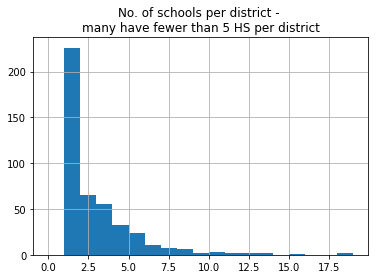

In [38]:
df_school_info_CA_schools.groupby('District').count()['School'].hist(bins=range(20))
plt.title('No. of schools per district - \nmany have fewer than 5 HS per district');

In [40]:
# Loop through each school in CA to get info

df_state = pd.DataFrame()

# Go district by district to avoid potential schools with similar names
for index_district, district in enumerate(df_school_info_CA_schools['District'].unique()):
    if index_district < 1000:
        #print(str(index_district), 'District queried: ', district)
        df_school_info_district = df_school_info_CA_schools.copy()[df_school_info_CA_schools['District']==district]
        for index, school in enumerate(df_school_info_district['School']):
            # Limit to high schools
            if index < 2000:
                try:
                    df = get_base_gs_school_info(school)
                    # Print to monitor, but limit the output
                    if index_district % 5 == 0:
                        print('District index: ', str(index_district), 'School index: ', str(index), school, df.shape, '\n -----')
                    if len(df_state.columns) < 1:
                        df_state = df.copy()
                        df_state.columns = [school]
                        index2get = df.index
                    else:
                        df_state[school] = df.copy().loc[index2get, :]
                        #df_state[school] = df
                except:
                    df_state[school] = None

            else:
                break
                
    else:
        break

# Transpose
df_state_tp = df_state.T

District index:  0 School index:  0 Envision Academy for Arts & Technology (23, 1) 
 -----


/Users/lacar/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/Users/lacar/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


District index:  5 School index:  0 Emery Secondary (23, 1) 
 -----
District index:  10 School index:  0 James Logan High (23, 1) 
 -----
District index:  15 School index:  0 Dublin High (23, 1) 
 -----
District index:  20 School index:  0 Inspire School of Arts and Sciences (23, 1) 
 -----
District index:  20 School index:  1 Chico High (23, 1) 
 -----
District index:  20 School index:  2 Pleasant Valley High (23, 1) 
 -----
District index:  25 School index:  0 Bret Harte Union High (23, 1) 
 -----
District index:  30 School index:  0 Williams Junior/Senior High (23, 1) 
 -----
District index:  35 School index:  0 Heritage High (23, 1) 
 -----
District index:  35 School index:  1 Freedom High (23, 1) 
 -----
District index:  35 School index:  2 Liberty High (23, 1) 
 -----
District index:  40 School index:  0 Dougherty Valley High (23, 1) 
 -----
District index:  40 School index:  1 California High (23, 1) 
 -----
District index:  40 School index:  2 Monte Vista High (23, 1) 
 -----
D

District index:  290 School index:  1 Adelanto High (22, 1) 
 -----
District index:  290 School index:  3 Options for Youth-Victorville Charter (23, 1) 
 -----
District index:  290 School index:  4 Silverado High (23, 1) 
 -----
District index:  290 School index:  5 Victor Valley High (23, 1) 
 -----
District index:  290 School index:  6 Cobalt Institute of Math and Science Academy (23, 1) 
 -----
District index:  295 School index:  0 Summit Leadership Academy-High Desert (23, 1) 
 -----
District index:  295 School index:  1 Mirus Secondary (22, 1) 
 -----
District index:  295 School index:  3 Oak Hills High (23, 1) 
 -----
District index:  295 School index:  4 Hesperia High (23, 1) 
 -----
District index:  295 School index:  5 Sultana High (23, 1) 
 -----
District index:  300 School index:  0 San Diego Workforce Innovation High (20, 1) 
 -----
District index:  300 School index:  1 Borrego Springs High (23, 1) 
 -----
District index:  305 School index:  0 River Valley Charter (23, 1) 


In [42]:
# Count number of rows with less than 5 null values out of the 23 targeted to scrape

print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
      +  ' GS schools info obtained out of ' 
      + str(df_state_tp.shape[0]) 
      + ' schools queried' )


no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()
print('no. of schools with GS link: ', str(no_of_schools_wlink))

no_of_schools_wlink = df_state_tp['overviewLink'].notnull().sum()

1151 GS schools info obtained out of 1253 schools queried
no. of schools with GS link:  1165


In [43]:
df_state_tp['overviewLink'].notnull().sum()

1165

In [44]:
df_state_tp.loc[df_state_tp.isnull().sum(axis=1) > 5, :]

tags                                                gsId  name  type  \
Silver Oak High Public Montessori Charter           None  None  None   
MetWest High                                        None  None  None   
McClymonds High                                     None  None  None   
Paradise eLearning Academy                          None  None  None   
Maxwell Sr High                                     None  None  None   
Clayton Valley Charter High                         None  None  None   
De Anza High                                        None  None  None   
El Cerrito High                                     None  None  None   
Big Picture Educational Academy                     None  None  None   
McLane High                                         None  None  None   
McKinleyville High                                  None  None  None   
YouthBuild Charter School of California             None  None  None   
Rosamond High Early College Campus                  None  None  None   
McFarland High                                      None  None  None   
Hanford Online Charter                              None  None  None   
Da Vinci RISE High                                  None  None  None   
Whitney (Gretchen) High                             None  None  None   
Warren (Earl) High                                  None  None  None   
Options For Youth - Duarte, Inc                     None  None  None   
City Honors College Preparatory Academy             None  None  None   
ICEF View Park Preparatory High                     None  None  None   
CATCH Prep Charter High, Inc.                       None  None  None   
Dr. Richard A. Vladovic Harbor Teacher Preparat...  None  None  None   
CHAMPS - Charter HS of Arts-Multimedia & Perfor...  None  None  None   
Animo Ralph Bunche Charter High                     None  None  None   
School of Business and Tourism at Contreras Lea...  None  None  None   
Contreras Learning Center-Academic Leadership C...  None  None  None   
Alain Leroy Locke College Preparatory Academy       None  None  None   
Esteban Torres East LA Performing Arts Magnet       None  None  None   
Cesar E. Chavez Learning Academies-Arts/Theatre...  None  None  None   
...                                                  ...   ...   ...   
SAVA - Sacramento Academic and Vocational Acade...  None  None  None   
SAVA - Sacramento Academic and Vocational Acade...  None  None  None   
C. K. McClatchy High                                None  None  None   
Kit Carson International Academy                    None  None  None   
Grand Terrace High School at the Ray Abril Jr. ...  None  None  None   
Lakeview Leadership Academy                         None  None  None   
Encore Jr./Sr. High School for the Performing a...  None  None  None   
Elite Academic Academy - Adult Work Force Inves...  None  None  None   
Triumph Academy                                     None  None  None   
San Diego Business/Leadership                       None  None  None   
Kearny School of Biomedical Science and Technology  None  None  None   
Kearny College Connections                          None  None  None   
Kearny Eng Innov & Design                           None  None  None   
San Dieguito HS Academy                             None  None  None   
Five Keys Independence HS (SF Sheriff's)            None  None  None   
Ronald E. McNair High                               None  None  None   
Stockton Early College Academy                      None  None  None   
Grizzly ChalleNGe Charter                           None  None  None   
Tide Academy                                        None  None  None   
Dr. TJ Owens Gilroy Early College Academy           None  None  None   
Santa Cruz County Cypress Charter High              None  None  None   
Diamond Technology Institute                        None  None  None   
Shasta Charter Academy                              None  None  None   
McCloud High                            

In [47]:
# Save csv so it's not necessary to reprocess
#df_state_tp.to_csv('repo/df_state_tp_WITH_URL_191006.csv')

#### Get high-level ratings using school profile page

For college readiness, test scores, advanced courses,
equity overview, race ethnicity, low income, disabilities

**Note: (API not required here)**

In [769]:
# Test query
# school = df_school_info_sd_schools_su['School'].iloc[5]
# print(school.replace(' ','-'))
# url = df_district_tp.loc[school, 'overviewLink']
# socket_read = urllib.request.urlopen(url).read()
# soup = BeautifulSoup(socket_read, 'html.parser')
# url_test = 'https://www.greatschools.org/california/chula-vista/6279-Bonita-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral'

In [34]:
def get_high_level_ratings(url_school):

    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
    
    except:
        soup = None

    rating_categories = (['College_readiness', 'Test_scores', 'Advanced_courses',
                         'Equity_overview', 'Race_ethnicity', 'Low-income_students',
                         'Students_with_Disabilities'])
        
    rating_list = list()
    for rating_cat in rating_categories:
        #print(rating_cat)
        try:
            tags = soup.find_all(href=re.compile(rating_cat))
            this_cat_rating_list = []
            for tag in tags:
                for index, child in enumerate(tag.contents):
                    if "rating" in str(child):
                        this_child = str(child)
                        rating = (int(this_child.split('--')[1].split()[0]))
                        this_cat_rating_list.append(rating)
                    else:
                        #print("no rating")
                        this_cat_rating_list.append('no_rating')

                # If there's no rating in any tag for that category, record it as None
                if False not in [i=='no_rating' for i in this_cat_rating_list]:
                    rating = None

        except:
            rating = None
            
        rating_list.append(rating)
        
    return rating_list

##### Testing with Sweetwater Union

In [ ]:
# Commented out if needed to start next loop at a certain index

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp.loc[:, rating] = None



In [92]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Use enumerate option to start at a certain index and not start over
for i, url in enumerate(df_district_tp['overviewLink'], 9):
    print(i)
    #try:
#     index_school = df_district_tp.index[i]
#     df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#     print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    #except:
    #    continue


9
10
11
12
13
14
15
16
17
18
19
20


In [114]:
df_district_tp['overviewLink'].iloc[9:]

Mar Vista Senior High     https://www.greatschools.org/california/imperi...
Sweetwater High           https://www.greatschools.org/california/nation...
Montgomery Senior High    https://www.greatschools.org/california/san-di...
Name: overviewLink, dtype: object

In [117]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# Careful with this - 

start_val = 9
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:]):
    index_school = df_district_tp.index[i+start_val]
    print(i, index_school, url)
#     try:
#         index_school = df_district_tp.index[i]
#         df_district_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
#         no_of_values = df_district_tp.loc[index_school, col_hl_ratings].notnull().sum()
#         print(str(i+1) + ' of ' + str(len(df_district_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output
#     except:
#         continue



0 Mar Vista Senior High https://www.greatschools.org/california/imperial-beach/6289-Mar-Vista-Senior-High-School/?utm_source=GSAPI&utm_medium=referral
1 Sweetwater High https://www.greatschools.org/california/national-city/6297-Sweetwater-High-School/?utm_source=GSAPI&utm_medium=referral
2 Montgomery Senior High https://www.greatschools.org/california/san-diego/6291-Montgomery-Senior-High-School/?utm_source=GSAPI&utm_medium=referral


#####  Testing with LA Unified

In [1291]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     df_district_tp_LA.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)

1 of 160: High Tech LA
2 of 160: Wallis Annenberg High
3 of 160: Central City Value
4 of 160: ICEF View Park Preparatory Accelerated High
5 of 160: CATCH Prep Charter High, Inc.
6 of 160: Oscar De La Hoya Animo Charter High
7 of 160: Animo South Los Angeles Charter
8 of 160: Middle College High
9 of 160: Dr. Richard A. Vladovic Harbor Teacher Preparation Academy
10 of 160: Camino Nuevo Charter High
11 of 160: Animo Venice Charter High
12 of 160: Animo Pat Brown
13 of 160: Northridge Academy High
14 of 160: Port of Los Angeles High
15 of 160: CHAMPS - Charter HS of Arts-Multimedia & Performing
16 of 160: Alliance Judy Ivie Burton Technology Academy High
17 of 160: Alliance Collins Family College-Ready High
18 of 160: Santee Education Complex
19 of 160: South East High
20 of 160: Maywood Academy High
21 of 160: New Village Girls Academy
22 of 160: Alliance Patti And Peter Neuwirth Leadership Academy
23 of 160: Alliance Dr. Olga Mohan High
24 of 160: Animo Ralph Bunche Charter High
25 of 

##### Full CA high school data

In [114]:
# Commented out if needed to start next loop at a certain index

col_hl_ratings = ['college_readiness', 'test_scores', 'advanced_courses', 'equity_overview', 'race_ethnicity', 'low_income', 'disabilities']
# # Initiate columns
# for rating in col_hl_ratings:
#     df_state_tp.loc[:, rating] = None


In [119]:
# NOTE: This cell takes a while to run, likely due to internet speed limitations

# For debugging - start at a certain row and not have to start over
# Don't use enumerate option since the url doesn't track with the option

start_val = 350
for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:]):
    index_school = df_state_tp.index[i+start_val]
    try:
        if url is not None:
            df_state_tp.loc[index_school, col_hl_ratings] = get_high_level_ratings(url)
            no_of_values = df_state_tp.loc[index_school, col_hl_ratings].notnull().sum()
        else:
            df_state_tp.loc[index_school, col_hl_ratings] = None
    except:
        df_state_tp.loc[index_school, col_hl_ratings] = None
    if i % 10 == 0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school + ' - ' + str(no_of_values))    # To monitor output


1 of 1253: Contreras Learning Center-Academic Leadership Community - 4
11 of 1253: Alliance Tennenbaum Family Technology High - 4
21 of 1253: Valley Academy of Arts and Sciences - 4
31 of 1253: Synergy Quantum Academy - 4
41 of 1253: Augustus F. Hawkins High B Community Health Advocates - 4
51 of 1253: Alliance Alice M. Baxter College-Ready High - 3
61 of 1253: Collegiate Charter High School of Los Angeles - 3
71 of 1253: Matrix for Success Academy - 0
81 of 1253: Grover Cleveland Charter High - 4
91 of 1253: Ulysses S. Grant Senior High - 4
101 of 1253: James Monroe High - 4
111 of 1253: University High School Charter - 4
121 of 1253: Monrovia High - 4
131 of 1253: Odyssey STEM Academy - 0
141 of 1253: Fremont Academy of Engineering and Design - 4
151 of 1253: Pioneer High - 4
161 of 1253: Opportunities for Learning - Santa Clarita - 4
171 of 1253: John A. Rowland High - 4
181 of 1253: Mira Costa High - 4
191 of 1253: Madera South High - 4
201 of 1253: San Rafael High - 4
211 of 1253:

In [98]:
# Something to fix if there's time
# df_state_tp.iloc[360:365, :]

tags                                                 gsId  \
Alliance Tennenbaum Family Technology High          25748   
Math, Science, & Technology Magnet Academy at R...   2496   
Esteban Torres East LA Performing Arts Magnet        None   
Humanitas Academy of Art and Technology at Este...  25437   
Social Justice Leadership Academy at Esteban E....  25474   

tags                                                                                             name  \
Alliance Tennenbaum Family Technology High                 Alliance Tennenbaum Family Technology High   
Math, Science, & Technology Magnet Academy at R...                         Windsor Hills Math Science   
Esteban Torres East LA Performing Arts Magnet                                                    None   
Humanitas Academy of Art and Technology at Este...  Humanitas Academy Of Art And Technology At Est...   
Social Justice Leadership Academy at Esteban E....  Social Justice Leadership Academy At Esteban E...   

tags                                                   type gradeRange  \
Alliance Tennenbaum Family Technology High          charter       9-12   
Math, Science, & Technology Magnet Academy at R...   public        K-5   
Esteban Torres East LA Performing Arts Magnet          None       None   
Humanitas Academy of Art and Technology at Este...   public       9-12   
Social Justice Leadership Academy at Esteban E....   public       9-12   

tags                                               enrollment gsRating  \
Alliance Tennenbaum Family Technology High                408        6   
Math, Science, & Technology Magnet Academy at R...        530        4   
Esteban Torres East LA Performing Arts Magnet            None     None   
Humanitas Academy of Art and Technology at Este...        493        4   
Social Justice Leadership Academy at Esteban E....        406        3   

tags                                               parentRating         city  \
Alliance Tennenbaum Family Technology High                    4  Los Angeles   
Math, Science, & Technology Magnet Academy at R...            4  Los Angeles   
Esteban Torres East LA Performing Arts Magnet              None         None   
Humanitas Academy of Art and Technology at Este...          NaN  Los Angeles   
Social Justice Leadership Academy at Esteban E....          NaN  Los Angeles   

tags                                               state districtId  \
Alliance Tennenbaum Family Technology High            CA        286   
Math, Science, & Technology Magnet Academy at R...    CA        286   
Esteban Torres East LA Performing Arts Magnet       None       None   
Humanitas Academy of Art and Technology at Este...    CA        286   
Social Justice Leadership Academy at Esteban E....    CA        286   

tags                                                   ...       \
Alliance Tennenbaum Family Technology High             ...        
Math, Science, & Technology Magnet Academy at R...     ...        
Esteban Torres East LA Performing Arts Magnet          ...        
Humanitas Academy of Art and Technology at Este...     ...        
Social Justice Leadership Academy at Esteban E....     ...        

tags                                                                                      ratingsLink  \
Alliance Tennenbaum Family Technology High          https://www.greatschools.org/california/los-an...   
Math, Science, & Technology Magnet Academy at R...  https://www.greatschools.org/california/los-an...   
Esteban Torres East LA Performing Arts Magnet                                                    None   
Humanitas Academy of Art and Technology at Este...  https://www.greatschools.org/california/los-an...   
Social Justice Leadership Academy at Esteban E....  https://www.greatschools.org/california/los-an...   

tags                                                                                      reviewsLink  \
Alliance Tennenbaum Family Technology High          https://www.g

In [130]:
# Count number of rows with some null values out of the 30 targeted to scrape
# print(str((df_state_tp.isnull().sum(axis=1) < 5).sum())
#       +  ' GS schools info obtained out of ' 
#       + str(df_state_tp.shape[0]) 
#       + ' schools queried' )

no_of_schools_w_4HLratings = (df_state_tp.loc[:, col_hl_ratings].notnull().sum(axis=1) >=3).sum()
print(str(no_of_schools_w_4HLratings) + ' GS schools with at least 3 of the 4 high-level ratings out of ' + str(no_of_schools_wlink) + ' with a link')

1028 GS schools with at least 3 of the 4 high-level ratings out of 1165 with a link


In [125]:
# CSV to save I don't have to start over
#df_state_tp.to_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_191006.csv')

In [126]:
#df_state_tp.tail()

tags                                      gsId  \
Woodland Senior High                      7829   
Lindhurst High                            7771   
Marysville Charter Academy for the Arts  11901   
Marysville High                           7773   
Wheatland Union High                      7785   

tags                                                                        name  \
Woodland Senior High                                 Woodland Senior High School   
Lindhurst High                                             Lindhurst High School   
Marysville Charter Academy for the Arts  Marysville Charter Academy For The Arts   
Marysville High                                           Marysville High School   
Wheatland Union High                                 Wheatland Union High School   

tags                                        type gradeRange enrollment  \
Woodland Senior High                      public       9-12       1318   
Lindhurst High                            public       9-12       1122   
Marysville Charter Academy for the Arts  charter       7-12        376   
Marysville High                           public       9-12        893   
Wheatland Union High                      public       9-12        707   

tags                                    gsRating parentRating        city  \
Woodland Senior High                           5            3    Woodland   
Lindhurst High                                 3            4  Olivehurst   
Marysville Charter Academy for the Arts        8            5  Marysville   
Marysville High                                5            4  Marysville   
Wheatland Union High                           5            3   Wheatland   

tags                                    state districtId     ...       \
Woodland Senior High                       CA       1041     ...        
Lindhurst High                             CA       1032     ...        
Marysville Charter Academy for the Arts    CA       1032     ...        
Marysville High                            CA       1032     ...        
Wheatland Union High                       CA       1035     ...        

tags                                                                           ratingsLink  \
Woodland Senior High                     https://www.greatschools.org/california/woodla...   
Lindhurst High                           https://www.greatschools.org/california/oliveh...   
Marysville Charter Academy for the Arts  https://www.greatschools.org/california/marysv...   
Marysville High                          https://www.greatschools.org/california/marysv...   
Wheatland Union High                     https://www.greatschools.org/california/wheatl...   

tags                                                                           reviewsLink  \
Woodland Senior High                     https://www.greatschools.org/california/woodla...   
Lindhurst High                           https://www.greatschools.org/california/oliveh...   
Marysville Charter Academy for the Arts  https://www.greatschools.org/california/marysv...   
Marysville High                          https://www.greatschools.org/california/marysv...   
Wheatland Union High                     https://www.greatschools.org/california/wheatl...   

tags                                                                       schoolStatsLink  \
Woodland Senior High                     https://www.greatschools.org/california/woodla...   
Lindhurst High                           https://www.greatschools.org/california/oliveh...   
Marysville Charter Academy for the Arts  https://www.greatschools.org/california/marysv...   
Marysville High                          https://www.greatschools.org/california/marysv...   
Wheatland Union High                     https://www.greatschools.org/california/wheatl...   

tags                                    college_readiness test_scores  \
Woodland Senior High                                    5           4   
Lindhu

In [31]:
# Loading CSV back into memory
df_state_tp = pd.read_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_191006.csv', index_col=0)

In [32]:
df_state_tp.head()

gsId  \
Envision Academy for Arts & Technology  16870.0   
Alameda High                                1.0   
Alternatives in Action                  11903.0   
Albany High                                19.0   
Berkeley High                              25.0   

                                                                          name  \
Envision Academy for Arts & Technology  Envision Academy For Arts & Technology   
Alameda High                                               Alameda High School   
Alternatives in Action                                  Alternatives in Action   
Albany High                                                 Albany High School   
Berkeley High                                             Berkeley High School   

                                           type gradeRange  enrollment  \
Envision Academy for Arts & Technology  charter       9-12       407.0   
Alameda High                             public       9-12      1853.0   
Alternatives in Action                  charter       9-12       165.0   
Albany High                              public       9-12      1210.0   
Berkeley High                            public       9-12      3205.0   

                                        gsRating  parentRating      city  \
Envision Academy for Arts & Technology       4.0           3.0   Oakland   
Alameda High                                 9.0           4.0   Alameda   
Alternatives in Action                       NaN           4.0   Oakland   
Albany High                                  9.0           4.0    Albany   
Berkeley High                                8.0           4.0  Berkeley   

                                       state  districtId     ...       \
Envision Academy for Arts & Technology    CA      1069.0     ...        
Alameda High                              CA         1.0     ...        
Alternatives in Action                    CA         1.0     ...        
Albany High                               CA         2.0     ...        
Berkeley High                             CA         3.0     ...        

                                                                              ratingsLink  \
Envision Academy for Arts & Technology  https://www.greatschools.org/california/oaklan...   
Alameda High                            https://www.greatschools.org/california/alamed...   
Alternatives in Action                  https://www.greatschools.org/california/oaklan...   
Albany High                             https://www.greatschools.org/california/albany...   
Berkeley High                           https://www.greatschools.org/california/berkel...   

                                                                              reviewsLink  \
Envision Academy for Arts & Technology  https://www.greatschools.org/california/oaklan...   
Alameda High                            https://www.greatschools.org/california/alamed...   
Alternatives in Action                  https://www.greatschools.org/california/oaklan...   
Albany High                             https://www.greatschools.org/california/albany...   
Berkeley High                           https://www.greatschools.org/california/berkel...   

                                                                          schoolStatsLink  \
Envision Academy for Arts & Technology  https://www.greatschools.org/california/oaklan...   
Alameda High                            https://www.greatschools.org/california/alamed...   
Alternatives in Action                  https://www.greatschools.org/california/oaklan...   
Albany High                             https://www.greatschools.org/california/albany...   
Berkeley High                           https://www.greatschools.org/california/berkel...   

                                       college_readiness test_scores  \
Envision Academy for Arts & Technology               1.0         4.0   
Alameda High                                        10.0         9.0   
Alternati

#### Obtain GS details on teacher and low income data

In [35]:
def get_school_page_doc(url_school):
    try:
        socket_read = urllib.request.urlopen(url_school).read()   # uncomment when there's internet
        soup = BeautifulSoup(socket_read, 'html.parser')
        school_page_doc = soup.get_text()
    except:
        school_page_doc = None
    return school_page_doc

In [36]:
def get_relevant_texts_teachers(my_text):
    try:
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        for this_match in range(len(my_str_loc)):
            #if "\"label\"" in school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]:
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
    except:
        relevant_text = None
    return relevant_text

In [37]:
# This was arbitrarily chosen because it's the middle category
# but I tried other things and this seemed to work well to get the right section
# teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')

In [38]:
def get_ratios_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        ratio_loc = teacher_text.replace('\n', '').find(':', text2get_loc_end)
        student_to_one_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:ratio_loc].strip())
    except:
        student_to_one_staff = None
    return student_to_one_staff


In [39]:
def get_percentages_for_staff(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('%', text2get_loc_end)
        percent_staff = int(teacher_text.replace('\n', '')[text2get_loc_end:character_loc].strip())
    except:
        percent_staff = None
    return percent_staff

In [40]:
def get_salary(text):
    try:
        text2get = text
        # Added this next line
        teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
        text2get_loc_start = teacher_text.replace('\n', '').find(text2get)
        text2get_loc_end = text2get_loc_start + len(text2get)
        character_loc = teacher_text.replace('\n', '').find('$', text2get_loc_end)
        end_of_salary_loc = teacher_text.replace('\n', '').find(' ', character_loc)
        salary = int(teacher_text.replace('\n', '')[character_loc+1:end_of_salary_loc].replace(',',''))
    except:
        salary = None
    return salary

In [41]:
# Testing
# Add this to individual school info and then dataframe
# (get_ratios_for_staff('Students per teacher'),
#  get_ratios_for_staff('Students per counselor'),
#  get_percentages_for_staff('Percentage of teachers with 3 or more years experience'),
#  get_percentages_for_staff('% of full time teachers who are certified '),
#  get_salary('Average teacher salary'))

In [42]:
def get_pct_lowincome_students(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        #min_max_to_look = 250  # use for other things
        min_max_to_look = 100
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if '"breakdown":"Low-income","breakdown_in_english":"Economically disadvantaged"' in relevant_text:
                #print('   =============   ' + str(counter) + '   === (no. of low income?) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:
        str2find = '"percentage":'
        str2find_loc_start = relevant_text.find(str2find)
        str2find_loc_end = str2find_loc_start + len(str2find)
        pct_low_income_loc_end = relevant_text.find(',', str2find_loc_end)
        pct_low_income = int(relevant_text[str2find_loc_end:pct_low_income_loc_end].strip('"'))
    except:
        pct_low_income = None
    
    return pct_low_income

In [43]:
def get_lowincome_test_scores_overview(school_page_doc):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 400
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and counter==0:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
        
    try:  
        str2find = '"All students","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_AS = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_AS = None

    try:
        str2find = '"Economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_LI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_LI = None

    try:
        str2find = '"Not economically disadvantaged","label":'
        text_loc_start = relevant_text.find(str2find)
        text_loc_end = text_loc_start + len(str2find)
        score_start = relevant_text.find('"score":', text_loc_end)
        score_end = relevant_text.find(',', score_start)
        score_notLI = int(relevant_text[score_start:score_end].split(':')[1])
    except:
        score_notLI = None

    return (score_AS, score_LI, score_notLI)

In [44]:
def get_lowincome_test_scores_for_subject(school_page_doc, subject):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 350
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and subject in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
    except:
        relevant_text = None
    
    # Get all students info
    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_AS = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_AS = None
    
    # Get low income info
    try:
        str2find = '"Economically disadvantaged","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None
        
    try:    
        str2find_no_students = '"number_students_tested":'
        no_students_loc_start = relevant_text.find(str2find_no_students, low_inc_score_loc_end)
        no_students_loc_end = no_students_loc_start + len(str2find_no_students)
        #score_start = no_students_loc_end + 1
        score_end = relevant_text.find(',', no_students_loc_end)
        no_students_tested_LI = int(relevant_text[no_students_loc_end:score_end])
    except:
        no_students_tested_LI = None
    
    return (score_AS, no_students_tested_AS, score_LI, no_students_tested_LI)

In [45]:
def get_lowincome_gradrates_college_eligibility(school_page_doc, grad_category):
    try:
        my_text = 'Low-income'
        my_str_loc = [(m.start(0), m.end(0)) for m in re.finditer(my_text,school_page_doc)]
        min_max_to_look = 300
        counter = 0
        for this_match in range(len(my_str_loc)):
            relevant_text = school_page_doc[my_str_loc[this_match][0]-min_max_to_look:my_str_loc[this_match][1]+min_max_to_look]
            if 'label' in relevant_text and grad_category in relevant_text:
                #print('   =============   ' + str(counter) + '   === (label) ==========   ')
                #print(relevant_text)
                counter += 1
                break
                
    except:
        relevant_text = None

    try:
        str2find = '"All students","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_AS = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_AS = None

    try:
        str2find = '"Low-income","label":'
        low_inc_score_loc_start = relevant_text.find(str2find)
        low_inc_score_loc_end = low_inc_score_loc_start + len(str2find)
        score_end = relevant_text.find(',', low_inc_score_loc_end)
        score_LI = int(relevant_text[low_inc_score_loc_end:score_end].strip('"'))
    except:
        score_LI = None

    return (score_AS, score_LI)

##### Testing with Sweetwater Union

In [160]:
# Initiate teacher rating columns
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
for rating in col_teacher_ratings:
    df_district_tp.loc[:, rating] = None

# Initiate low income data columns
col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])
for rating in col_lowincome_ratings:
    df_district_tp.loc[:, rating] = None

    

start_val = 3
end_val = 5
for i, url in enumerate(df_district_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_district_tp.index[i+start_val]
     
# for i, url in enumerate(df_district_tp['overviewLink']):
#     index_school = df_district_tp.index[i]
    print(str(i+1+start_val) + ' of ' + str(len(df_district_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_district_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_district_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_district_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_district_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_district_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_district_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_district_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_district_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_district_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_district_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_district_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

4 of 12: Castle Park Senior High
5 of 12: Eastlake High
done getting schools in this set


##### Testing with LA Unified

In [227]:
#col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# # Initiate columns
# for rating in col_teacher_ratings:
#     df_district_tp_LA.loc[:, rating] = None
    
# for i, url in enumerate(df_district_tp_LA['overviewLink']):
#     index_school = df_district_tp_LA.index[i]
#     print(str(i+1) + ' of ' + str(len(df_district_tp_LA)) + ': ' + index_school)    # To monitor output
#     school_page_doc = get_school_page_doc(url)
#     #teacher_text = get_relevant_texts_teachers('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
#     # print(get_ratios_for_staff('Students per teacher'))
#     df_district_tp_LA.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
#     df_district_tp_LA.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
#     df_district_tp_LA.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')

##### Full CA high school data

In [288]:
col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']

col_lowincome_ratings = (['test_score_rating_allStudents',
                          'test_score_rating_LIstudents',
                          'test_score_rating_notLIstudents',
                          'test_scores_english_allStudents',
                          'test_scores_english_allStudents_n_students',
                          'test_scores_english_LIstudents',
                          'test_scores_english_LIstudents_n_students',
                          'test_scores_math_allStudents',
                          'test_scores_math_allStudents_n_students',
                          'test_scores_math_LIstudents',
                          'test_scores_math_LIstudents_n_students',
                          'graduation_rates_UCCSU_eligibility_allStudents',
                          'graduation_rates_UCCSU_eligibility_LIstudents',
                          'graduation_rates_gradRates_eligibility_allStudents',
                          'graduation_rates_gradRates_eligibility_LIstudents',
                          'pct_LI_students'])

In [60]:
# Initiate teacher rating columns - comment out to start mid-loop
# col_teacher_ratings = ['students_per_teacher', 'students_per_counselor', 'pct_teachers_3years_or_more', 'pct_teachers_who_r_certified', 'avg_teacher_salary']
# for rating in col_teacher_ratings:
#     df_state_tp.loc[:, rating] = None

# # Initiate low income data columns
# col_lowincome_ratings = (['test_score_rating_allStudents',
#                           'test_score_rating_LIstudents',
#                           'test_score_rating_notLIstudents',
#                           'test_scores_english_allStudents',
#                           'test_scores_english_allStudents_n_students',
#                           'test_scores_english_LIstudents',
#                           'test_scores_english_LIstudents_n_students',
#                           'test_scores_math_allStudents',
#                           'test_scores_math_allStudents_n_students',
#                           'test_scores_math_LIstudents',
#                           'test_scores_math_LIstudents_n_students',
#                           'graduation_rates_UCCSU_eligibility_allStudents',
#                           'graduation_rates_UCCSU_eligibility_LIstudents',
#                           'graduation_rates_gradRates_eligibility_allStudents',
#                           'graduation_rates_gradRates_eligibility_LIstudents',
#                           'pct_LI_students'])
# for rating in col_lowincome_ratings:
#     df_state_tp.loc[:, rating] = None

# Set start and end to avoid hangups
start_val = 799
end_val = len(df_state_tp)
#for i, url in enumerate(df_state_tp['overviewLink'].iloc[start_val:end_val]):
    index_school = df_state_tp.index[i+start_val]
    #print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    # Monitor output but don't print everything
    if i % 10==0:
        print(str(i+1+start_val) + ' of ' + str(len(df_state_tp)) + ': ' + index_school)    # To monitor output
    school_page_doc = get_school_page_doc(url)
    
    # Detailed teacher info
    df_state_tp.loc[index_school, 'students_per_teacher'] = get_ratios_for_staff('Students per teacher')
    df_state_tp.loc[index_school, 'students_per_counselor'] = get_ratios_for_staff('Students per counselor')
    df_state_tp.loc[index_school, 'pct_teachers_3years_or_more'] = get_percentages_for_staff('Percentage of teachers with 3 or more years experience')
    df_state_tp.loc[index_school, 'pct_teachers_who_r_certified'] = get_percentages_for_staff('% of full time teachers who are certified')
    df_state_tp.loc[index_school, 'avg_teacher_salary'] = get_salary('Average teacher salary')
    
    # Detailed low income info
    df_state_tp.loc[index_school, col_lowincome_ratings[0:3]] = get_lowincome_test_scores_overview(school_page_doc)
    df_state_tp.loc[index_school, col_lowincome_ratings[3:7]] = get_lowincome_test_scores_for_subject(school_page_doc, 'English Language Arts')
    df_state_tp.loc[index_school, col_lowincome_ratings[7:11]] = get_lowincome_test_scores_for_subject(school_page_doc, 'Math')
    df_state_tp.loc[index_school, col_lowincome_ratings[11:13]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'UC/CSU eligibility')
    df_state_tp.loc[index_school, col_lowincome_ratings[13:15]] = get_lowincome_gradrates_college_eligibility(school_page_doc, 'Graduation rates')
    df_state_tp.loc[index_school, col_lowincome_ratings[15]] = get_pct_lowincome_students(school_page_doc)

print('done getting schools in this set')

800 of 1253: Natomas High
810 of 1253: Big Bear High
820 of 1253: Ruben S. Ayala High
830 of 1253: Fontana High
840 of 1253: Rialto High
850 of 1253: San Gorgonio High
860 of 1253: Baker High
870 of 1253: Elite Academic Academy - Adult Work Force Investment
880 of 1253: Classical Academy High
890 of 1253: Steele Canyon High
900 of 1253: Westview High
910 of 1253: San Diego Science and Technology
920 of 1253: Charter School of San Diego
930 of 1253: Canyon Crest Academy
940 of 1253: MAAC Community Charter
950 of 1253: Vista High
960 of 1253: High Tech High Chula Vista
970 of 1253: Burton (Phillip and Sala) Academic High
980 of 1253: O'Connell (John) High
990 of 1253: be.tech
1000 of 1253: Millennium Charter
1010 of 1253: Morro Bay High
1020 of 1253: Terra Nova High
1030 of 1253: Summit Preparatory Charter High
1040 of 1253: Lompoc High
1050 of 1253: Summit Public School: Tahoma
1060 of 1253: ACE Charter High
1070 of 1253: James Lick High
1080 of 1253: Dr. TJ Owens Gilroy Early College A

In [61]:
# No. of schools with at least 5 of the 21 detailed ratings
no_of_schools_wdetailed_ratings = (df_state_tp.loc[:, col_teacher_ratings + col_lowincome_ratings].isnull().sum(axis=1) < 5).sum()
print('', str(no_of_schools_wdetailed_ratings))

 1001


In [62]:
# CSV to save I don't have to start over
# df_state_tp.to_csv('repo/df_state_tp_WITH_URL-HLdone997schoolsWinfo_WdetailsALLschools_191007.csv')

In [63]:
df_state_tp.tail()

gsId  \
Woodland Senior High                      7829.0   
Lindhurst High                            7771.0   
Marysville Charter Academy for the Arts  11901.0   
Marysville High                           7773.0   
Wheatland Union High                      7785.0   

                                                                            name  \
Woodland Senior High                                 Woodland Senior High School   
Lindhurst High                                             Lindhurst High School   
Marysville Charter Academy for the Arts  Marysville Charter Academy For The Arts   
Marysville High                                           Marysville High School   
Wheatland Union High                                 Wheatland Union High School   

                                            type gradeRange  enrollment  \
Woodland Senior High                      public       9-12      1318.0   
Lindhurst High                            public       9-12      1122.0   
Marysville Charter Academy for the Arts  charter       7-12       376.0   
Marysville High                           public       9-12       893.0   
Wheatland Union High                      public       9-12       707.0   

                                         gsRating  parentRating        city  \
Woodland Senior High                          5.0           3.0    Woodland   
Lindhurst High                                3.0           4.0  Olivehurst   
Marysville Charter Academy for the Arts       8.0           5.0  Marysville   
Marysville High                               5.0           4.0  Marysville   
Wheatland Union High                          5.0           3.0   Wheatland   

                                        state  districtId       ...        \
Woodland Senior High                       CA      1041.0       ...         
Lindhurst High                             CA      1032.0       ...         
Marysville Charter Academy for the Arts    CA      1032.0       ...         
Marysville High                            CA      1032.0       ...         
Wheatland Union High                       CA      1035.0       ...         

                                        test_scores_english_LIstudents_n_students  \
Woodland Senior High                                                          196   
Lindhurst High                                                                194   
Marysville Charter Academy for the Arts                                       119   
Marysville High                                                               118   
Wheatland Union High                                                           72   

                                         test_scores_math_allStudents  \
Woodland Senior High                                               18   
Lindhurst High                                                     13   
Marysville Charter Academy for the Arts                            40   
Marysville High                                                    16   
Wheatland Union High                                               23   

                                        test_scores_math_allStudents_n_students  \
Woodland Senior High                                                        303   
Lindhurst High                                                              230   
Marysville Charter Academy for the Arts                                      60   
Marysville High                                                             185   
Wheatland Union High                                                        162   

                                        test_scores_math_LIstudents  \
Woodland Senior High                                             14   
Lindhurst High                                                   12   
Marysville Charter Academy for the Arts                          40   
Marysville High                                                  11   
Wheatland Union High             

### Merge datasets

In [ ]:
#  Merge on this - TO DO LATER
# From school info: NCESDist	NCESSchool  :  622710 + 11365
# On GS info: ncesId:   62271011365

# And filter out unrated schools (gsRating = None)
# df_school_info.head().loc[:, 'NCESDist'] + df_school_info.head().loc[:, 'NCESSchool']

# df_state_tp.head().loc[:, 'ncesId']

In [74]:
# Merge on school and zip code due to same named schools

# Need zip code in GS data
df_temp = df_state_tp['address'].str.split(expand=True)
col_index4zip = len(df_temp.columns) - df_temp.isnull().sum(axis=1) - 1

zipcode_list = list()
for i, col in enumerate(col_index4zip):
    if col != -1:
        zipcode = df_temp.iloc[i, col]
    else:
        zipcode = df_temp.iloc[i, 8]
    try:
        zipcode_list.append(int(zipcode))
    except:
        zipcode_list.append(None)
        
df_state_tp['zip_code_GS'] = zipcode_list
df_state_tp['schoolname4merge'] = df_state_tp.index

In [83]:
df_state_tp.head().index

Index(['Envision Academy for Arts & Technology', 'Alameda High',
       'Alternatives in Action', 'Albany High', 'Berkeley High'],
      dtype='object')

In [84]:
df_state_tp['name'].head()

Envision Academy for Arts & Technology    Envision Academy For Arts & Technology
Alameda High                                                 Alameda High School
Alternatives in Action                                    Alternatives in Action
Albany High                                                   Albany High School
Berkeley High                                               Berkeley High School
Name: name, dtype: object

In [86]:
bool_name_dup = df_state_tp['name'].duplicated(keep=False)

In [87]:
df_state_tp.loc[bool_name_dup, :]

gsId  \
Silver Oak High Public Montessori Charter               NaN   
MetWest High                                            NaN   
McClymonds High                                         NaN   
Paradise eLearning Academy                              NaN   
Maxwell Sr High                                         NaN   
Clayton Valley Charter High                             NaN   
De Anza High                                            NaN   
El Cerrito High                                         NaN   
Big Picture Educational Academy                         NaN   
McLane High                                             NaN   
McKinleyville High                                      NaN   
YouthBuild Charter School of California                 NaN   
Bakersfield High                                     1277.0   
East Bakersfield High                                1277.0   
Rosamond High Early College Campus                      NaN   
McFarland High                                          NaN   
Hanford Online Charter                                  NaN   
Da Vinci RISE High                                      NaN   
Whitney (Gretchen) High                                 NaN   
Warren (Earl) High                                      NaN   
Options For Youth - Duarte, Inc                         NaN   
City Honors College Preparatory Academy                 NaN   
ICEF View Park Preparatory High                         NaN   
CATCH Prep Charter High, Inc.                           NaN   
Dr. Richard A. Vladovic Harbor Teacher Preparat...      NaN   
CHAMPS - Charter HS of Arts-Multimedia & Perfor...      NaN   
Animo Ralph Bunche Charter High                         NaN   
School of Business and Tourism at Contreras Lea...      NaN   
Contreras Learning Center-Academic Leadership C...      NaN   
Alain Leroy Locke College Preparatory Academy           NaN   
...                                                     ...   
C. K. McClatchy High                                    NaN   
Kit Carson International Academy                        NaN   
San Juan High                                       32653.0   
Grand Terrace High School at the Ray Abril Jr. ...      NaN   
Lakeview Leadership Academy                             NaN   
Encore Jr./Sr. High School for the Performing a...      NaN   
Elite Academic Academy - Adult Work Force Inves...      NaN   
Triumph Academy                                         NaN   
San Diego Business/Leadership                           NaN   
Kearny School of Biomedical Science and Technology      NaN   
Kearny College Connections                              NaN   
Kearny Eng Innov & Design                               NaN   
San Dieguito HS Academy                                 NaN   
Pathways Academy Charter - Adult Education          32634.0   
Five Keys Independence HS (SF Sheriff's)                NaN   
Ronald E. McNair High                                   NaN   
Stockton Early College Academy                          NaN   
Grizzly ChalleNGe Charter                               NaN   
Tide Academy                                            NaN   
Dr. TJ Owens Gilroy Early College Academy               NaN   
Santa Cruz County Cypress Charter High                  NaN   
Diamond Technology Institute                            NaN   
Shasta Charter Academy                                  NaN   
McCloud High                                            NaN   
Online Academy - Sonoma County                          NaN   
Northwest Prep Charter                                  NaN   
Corning Independent Study                               NaN   
Alpaugh -Senior High                                    NaN   
Exeter Union High                                       NaN   
IvyTech Charter                                         NaN   

                                                                                        name  \
Silver Oak High Public Montessori Charter           

In [91]:
# Merge great schools and school info on zip code
df_state_info_gs = pd.merge(df_school_info, df_state_tp, how='inner',
                            left_on=['School', 'zip_code'],
                            right_on=['schoolname4merge', 'zip_code_GS'])

# Inspection showed a handful of schools in df_school_info with duplicate values for some reason
df_state_info_gs = df_state_info_gs.drop_duplicates(subset=['School', 'Street'], keep='last')

In [92]:
# Merge great schools, school info and demographic info on zip code
df_state_info_gs_census = pd.merge(df_state_info_gs, df_census,
                                      how='inner', left_on='zip_code', right_index=True)

In [195]:
# Save but comment after doing so
# df_state_info_gs_census.to_csv('repo/df_state_info_gs_census_ALL.csv')

### Read in to avoid re-downloading data if necessary

In [5]:
# df_state_info_gs_census = pd.read_csv('df_state_info_gs_census_ALL.csv', index_col=0)
df_state_info_gs_census = pd.read_csv(
    "~/Documents/Goals_and_careers/Edu_Data_Science/Insight/edu_project_for_interview/df_state_info_gs_census_ALL.csv"
)

<IPython.core.display.Javascript object>

In [261]:
print("Dimensions of dataframe after data merging:\n", df_state_info_gs_census.shape)

Dimensions of dataframe after data merging:
 (1152, 218)


<IPython.core.display.Javascript object>

In [279]:
[print(i) for i in df_state_info_gs_census.columns]

Unnamed: 0
CDSCode
NCESDist
NCESSchool
StatusType
County
District
School
Street
StreetAbr
City
Zip
State
MailStreet
MailStrAbr
MailCity
MailZip
MailState
Phone
Ext
WebSite
OpenDate
ClosedDate
Charter
CharterNum
FundingType
DOC
DOCType
SOC
SOCType
EdOpsCode
EdOpsName
EILCode
EILName
GSoffered
GSserved
Virtual
Magnet
YearRoundYN
FederalDFCDistrictID
Latitude
Longitude
AdmFName1
AdmLName1
AdmEmail1
AdmFName2
AdmLName2
AdmEmail2
AdmFName3
AdmLName3
AdmEmail3
LastUpDate
zip_code
gsId
name
type
gradeRange
enrollment
gsRating
parentRating
city
state
districtId
district
districtNCESId
address
phone
fax
website
ncesId
lat
lon
overviewLink
ratingsLink
reviewsLink
schoolStatsLink
college_readiness
test_scores
advanced_courses
equity_overview
race_ethnicity
low_income
disabilities
students_per_teacher
students_per_counselor
pct_teachers_3years_or_more
pct_teachers_who_r_certified
avg_teacher_salary
test_score_rating_allStudents
test_score_rating_LIstudents
test_score_rating_notLIstudents
test_scor

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

#### Evaluate enrollment

In [283]:
df_state_info_gs_census.loc[
    df_state_info_gs_census["name"].str.contains("Bonita"), ["name", "enrollment"]
]

name  enrollment
233               Bonita High School      1993.0
829  Bonita Vista Senior High School      2496.0

<IPython.core.display.Javascript object>

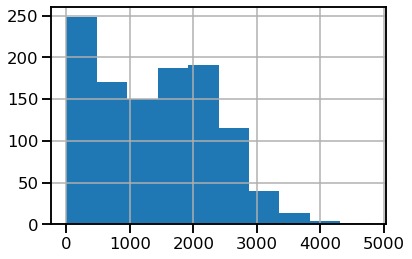

<IPython.core.display.Javascript object>

In [295]:
df_state_info_gs_census["enrollment"].hist();

In [299]:
np.arange(0.1, 1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

<IPython.core.display.Javascript object>

In [300]:
df_state_info_gs_census["enrollment"].quantile(np.arange(0.1, 1, 0.1))

0.1     214.0
0.2     435.0
0.3     623.2
0.4    1060.4
0.5    1409.0
0.6    1716.0
0.7    1987.6
0.8    2238.2
0.9    2603.6
Name: enrollment, dtype: float64

<IPython.core.display.Javascript object>

In [317]:
df_state_info_gs_census.loc[
    :,
    [
        "name",
        "enrollment",
        "graduation_rates_gradRates_eligibility_allStudents",
        "graduation_rates_gradRates_eligibility_LIstudents",
    ],
].sort_values(by="enrollment").head(20)

name  enrollment  \
475                 Yosemite Park High School         1.0   
1112                 Cold Springs High School         4.0   
190          Clear Passage Educational Center         4.0   
1111                   South Fork High School         4.0   
132       Mattole Triple Junction High School         9.0   
488                   Whale Gulch High School         9.0   
489                Leggett Valley High School        14.0   
146                 Death Valley High Academy        17.0   
462                 Mountain Oaks High School        18.0   
1013    Downieville Junior-Senior High School        20.0   
148                  Owens Valley High School        22.0   
865             Life Learning Academy Charter        22.0   
506                    Lee Vining High School        26.0   
1081             Southern Trinity High School        30.0   
636   Moreno Valley Community Learning Center        34.0   
1116                    Don Pedro High School        36.0   
760                         Baker High School        38.0   
145                      Big Pine High School        39.0   
122       Elk Creek Junior-Senior High School        42.0   
501               Surprise Valley High School        47.0   

      graduation_rates_gradRates_eligibility_allStudents  \
475                                                 NaN    
1112                                                NaN    
190                                                 NaN    
1111                                              100.0    
132                                                 NaN    
488                                               100.0    
489                                                 NaN    
146                                                80.0    
462                                               100.0    
1013                                              100.0    
148                                                80.0    
865                                                72.0    
506                                               100.0    
1081                                              100.0    
636                                                 NaN    
1116                                               83.0    
760                                                83.0    
145                                                83.0    
122                                               100.0    
501                                               100.0    

      graduation_rates_gradRates_eligibility_LIstudents  
475                                                 NaN  
1112                                                NaN  
190                                                 NaN  
1111                                              100.0  
132                                                 NaN  
488                                               100.0  
489                                                 NaN  
146                                                75.0  
462                                               100.0  
1013                                              100.0  
148                                                67.0  
865                                                71.0  
506                                               100.0  
1081                                              100.0  
636                                                 NaN  
1116                                               80.0  
760                                                82.0  
145                                                80.0  
122                                               100.0  
501                                               100.0

<IPython.core.display.Javascript object>

In [311]:
df_state_info_gs_census["enrollment"].isnull().sum()

33

<IPython.core.display.Javascript object>

### Add COVID data

Are some areas being hit harder?
(3/27/20)

In [ ]:
os.listdir()
df_covid = pd.read_csv("data/covid_2020/us-counties.csv")

df_covid["county_state"] = df_covid["county"] + " County, " + df_covid["state"]
df_covid.head()

In [149]:
df_covid.shape

(15836, 7)

<IPython.core.display.Javascript object>

#### CA

In [150]:
df_covid_CA = df_covid[df_covid["state"].isin(states_list)].copy()
df_covid_CA_by_date = df_covid_CA.groupby("date").sum()
df_covid_CA_by_date.reset_index(inplace=True)
df_covid_CA_by_date[["new_cases", "new_deaths"]] = df_covid_CA_by_date.loc[
    :, ["cases", "deaths"]
].diff()
df_covid_CA_by_date

date       fips  cases  deaths  new_cases  new_deaths
0   2020-01-21    53061.0      1       0        NaN         NaN
1   2020-01-22    53061.0      1       0        0.0         0.0
2   2020-01-23    53061.0      1       0        0.0         0.0
3   2020-01-24    53061.0      1       0        0.0         0.0
4   2020-01-25    59120.0      2       0        1.0         0.0
..         ...        ...    ...     ...        ...         ...
62  2020-03-23  2073197.0   4606     153      721.0        19.0
63  2020-03-24  2091304.0   5433     181      827.0        28.0
64  2020-03-25  2241517.0   6176     208      743.0        27.0
65  2020-03-26  2241517.0   7740     245     1564.0        37.0
66  2020-03-27  2306618.0   9265     293     1525.0        48.0

[67 rows x 6 columns]

<IPython.core.display.Javascript object>

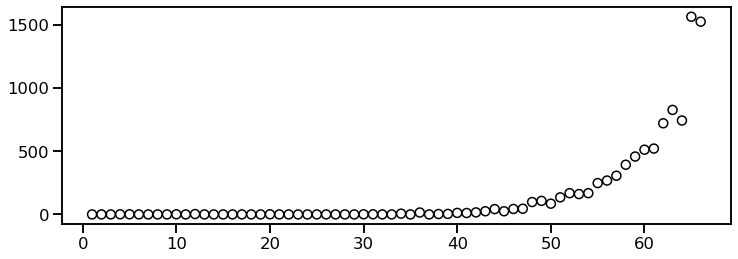

<IPython.core.display.Javascript object>

In [151]:
f, ax1 = plt.subplots(figsize=(12, 4))

ax1.scatter(df_covid_CA_by_date.index, df_covid_CA_by_date["new_cases"], facecolors='none', edgecolors='k');


In [191]:
def reorg_table_by_category(df_county_state_lim, category):
    # Re-org table
    df_covid_states_county_by_date_county_category = (
        df_county_state_lim.groupby(["date", "county_state"]).sum()[category].unstack()
    )
    df_covid_states_county_by_date_county_category.dropna(how="all", inplace=True)
    df_covid_states_county_by_date_county_category.reset_index(inplace=True)

    return df_covid_states_county_by_date_county_category

<IPython.core.display.Javascript object>

## Feature confirmation

In [327]:
sns.set_context(
    "talk", rc={"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 10}
)

<IPython.core.display.Javascript object>

In [328]:
def scatter_plot_open_circles(df, feature_x, feature_y, ax):
    x = df[feature_x]
    y = df[feature_y]
    ax.scatter(x, y, facecolors="none", edgecolors=B_dkgray)
    ax.set_xlabel(feature_x)
    ax.set_ylabel(feature_y)

<IPython.core.display.Javascript object>

In [329]:
def hist_plot(df, feature, ax):
    df[feature].hist(ax=ax, bins=30, color=B_slate)
    ax.set_title(feature)

<IPython.core.display.Javascript object>

### Feature categories

In [330]:
# Replace magnet and charter status with category encoding variables
df_state_info_gs_census["Magnet_cat_encoded"] = df_state_info_gs_census[
    "Magnet"
].replace({"No Data": None, "N": 0, "Y": 1})
df_state_info_gs_census["Charter_cat_encoded"] = df_state_info_gs_census[
    "Charter"
].replace({"No Data": None, "N": 0, "Y": 1})

<IPython.core.display.Javascript object>

In [331]:
# Census columns that start with '%'
col_census_pct = df_state_info_gs_census.columns[
    df_state_info_gs_census.columns.str.startswith("%")
]
# Broad categories in pct census columns
print(set([i.split("-")[0] for i in col_census_pct.tolist()]))

{'%; %', '%; INCOME_BENEFITS ', '%; HEALTH_INS_COVERAGE ', '%; WORK_COMMUTE ', '%; EMPLOY_STATUS ', '%; INDUSTRY ', '%; WORKER_CLASS ', '%; OCCUPATION '}


<IPython.core.display.Javascript object>

In [332]:
# Census income columns (starts with 'Est')
col_census_est = df_state_info_gs_census.columns[
    df_state_info_gs_census.columns.str.startswith("Est")
]
# Change so that all are numeric/float, using appply
df_state_info_gs_census[col_census_est] = (
    df_state_info_gs_census[col_census_est]
    .apply(pd.to_numeric, errors="coerce")
    .dropna()
    .astype("float")
)
col_census_est.tolist()

['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
 'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
 'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
 'Est.; INCOME_BENEFITS - w/ retirement income',
 'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
 'Est.; INCOME_BENEFITS - Families - Median family income ($)',
 'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
 'Est.; INCOME_BENEFITS - Per capita income ($)',
 'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
 'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)']

<IPython.core.display.Javascript object>

In [333]:
# School info columns
col_school_info_magnet_charter = ["Magnet_cat_encoded", "Charter_cat_encoded"]
col_school_info_magnet_charter

['Magnet_cat_encoded', 'Charter_cat_encoded']

<IPython.core.display.Javascript object>

In [334]:
# High level GS school rating columns
col_hl_ratings = [
    "college_readiness",
    "test_scores",
    "advanced_courses",
    "equity_overview",
    "race_ethnicity",
    "low_income",
    "disabilities",
]
col_gs_hl_ratings = ["gsRating"] + col_hl_ratings
# df_state_info_gs_census[col_gs_hl_ratings] = df_state_info_gs_census[col_gs_hl_ratings].apply(pd.to_numeric, errors='coerce').dropna().astype('float')
# Data types look like they're already float
# initial_analysis(df_state_info_gs_census[col_gs_hl_ratings])
col_gs_hl_ratings

['gsRating',
 'college_readiness',
 'test_scores',
 'advanced_courses',
 'equity_overview',
 'race_ethnicity',
 'low_income',
 'disabilities']

<IPython.core.display.Javascript object>

In [335]:
col_teacher_ratings = [
    "students_per_teacher",
    "students_per_counselor",
    "pct_teachers_3years_or_more",
    "pct_teachers_who_r_certified",
    "avg_teacher_salary",
]
col_teacher_ratings

['students_per_teacher',
 'students_per_counselor',
 'pct_teachers_3years_or_more',
 'pct_teachers_who_r_certified',
 'avg_teacher_salary']

<IPython.core.display.Javascript object>

In [336]:
col_lowincome_ratings = [
    "test_score_rating_allStudents",
    "test_score_rating_LIstudents",
    "test_score_rating_notLIstudents",
    "test_scores_english_allStudents",
    "test_scores_english_allStudents_n_students",
    "test_scores_english_LIstudents",
    "test_scores_english_LIstudents_n_students",
    "test_scores_math_allStudents",
    "test_scores_math_allStudents_n_students",
    "test_scores_math_LIstudents",
    "test_scores_math_LIstudents_n_students",
    "graduation_rates_UCCSU_eligibility_allStudents",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    "graduation_rates_gradRates_eligibility_allStudents",
    "graduation_rates_gradRates_eligibility_LIstudents",
    "pct_LI_students",
]

# Need to remove target from this list without altering original list
col_lowincome_ratings_notarget = col_lowincome_ratings[:]
col_lowincome_ratings_notarget.remove("graduation_rates_UCCSU_eligibility_LIstudents")
col_lowincome_ratings_notarget

['test_score_rating_allStudents',
 'test_score_rating_LIstudents',
 'test_score_rating_notLIstudents',
 'test_scores_english_allStudents',
 'test_scores_english_allStudents_n_students',
 'test_scores_english_LIstudents',
 'test_scores_english_LIstudents_n_students',
 'test_scores_math_allStudents',
 'test_scores_math_allStudents_n_students',
 'test_scores_math_LIstudents',
 'test_scores_math_LIstudents_n_students',
 'graduation_rates_UCCSU_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_allStudents',
 'graduation_rates_gradRates_eligibility_LIstudents',
 'pct_LI_students']

<IPython.core.display.Javascript object>

### First pass feature filtering

In [337]:
all_features = (
    ["enrollment"]
    + col_census_pct.tolist()
    + col_census_est.tolist()
    + col_school_info_magnet_charter
    + col_gs_hl_ratings
    + col_teacher_ratings
    + col_lowincome_ratings_notarget
)

<IPython.core.display.Javascript object>

In [338]:
all_features_filt = (
    df_state_info_gs_census[all_features]
    .dropna(thresh=0.67 * len(df_state_info_gs_census), axis=1)
    .columns.tolist()
)

<IPython.core.display.Javascript object>

In [339]:
print(
    "No. of features where at least 2/3 of the schools have values for a feature: \n",
    len(all_features_filt),
)

No. of features where at least 2/3 of the schools have values for a feature: 
 138


<IPython.core.display.Javascript object>

In [340]:
# Identify which features were removed
print(
    "Features that had too many missing values: ",
    set(all_features) - set(all_features_filt),
)

Features that had too many missing values:  {'advanced_courses', 'race_ethnicity', 'disabilities'}


<IPython.core.display.Javascript object>

## Check for normally distributed features

In [290]:
# Looking at Shapiro-Wilk test - this is like taking the slope of a Q-Q plot https://www.youtube.com/watch?v=dRAqSsgkCUc
from scipy.stats import shapiro

for col in df_state_info_gs_census[all_features_filt].columns:
    try:
        stat, p = shapiro(df_state_info_gs_census[col])
        if p > 0.05:
            print(stat, p, col)
    except:
        continue

nan 1.0 enrollment
nan 1.0 %; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force
nan 1.0 %; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force
nan 1.0 %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage
nan 1.0 %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Unemployed: - w/ health ins coverage
nan 1.0 %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Unemployed: - w/ health ins coverage - w/ private health insurance
nan 1.0 %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Unemployed: - w/ health ins coverage - w/ public coverage
nan 1.0 %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Unemployed: - No health ins coverage
nan 1.0 %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families - w/ re

<IPython.core.display.Javascript object>

In [326]:
len(all_features_filt)

138

<IPython.core.display.Javascript object>

### Check for correlated features

Evaluate VIF - Variance inflation factor

- VIF is greater than 10 then remove? An arbitrary cut-off, may be dependent on the task

In [ ]:
df_state_info_gs_census

### Census category text inspection

Before filtering:
- INCOME_BENEFITS - percentage (28 columns) - check for redundant columns and correlated and anti-correlated features
- INCOME_BENEFITS - estimated values - (12 columns) - manually select features
- HEALTH_INS_COVERAGE (17 columns) - manually select columns
- WORK_COMMUTE - adds to 100% (6 columns) - interesting to keep, but drop rare categories
- OCCUPATION - adds to 100% (5 columns) - perhaps drop - may be redundant with industry
- INDUSTRY - adds to 100% (13 columns) - interesting to keep but inspect
- WORKER_CLASS - adds to 100% (4 columns) - OK to keep but inspect
- EMPLOY_STATUS - (12 columns) - OK to keep but inspect
- %-AGE_FAMILIES_INCOME_BELOW_POVERTY (13 columns) - follow up


In [356]:
[print(i) for i in col_census_pct]

%; INCOME_BENEFITS - w/ retirement income_x
%; INCOME_BENEFITS - w/ cash public assistance income_x
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force
%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

#### Income benefits columns

##### Evaluation of pct income benefits columns

In [341]:
col_census_pct_ib = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("INCOME_BENEFITS")
].tolist()

# Drop columns containing '%; INCOME_BENEFITS - Families -' since it's redundant with '%; INCOME_BENEFITS - Total households - '
col2drop = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains(
        "%; INCOME_BENEFITS - Families"
    )
].tolist()

# Drop duplicated columns
col2drop = col2drop + [
    "%; INCOME_BENEFITS - w/ retirement income_y",
    "%; INCOME_BENEFITS - w/ cash public assistance income_y",
]

col_census_pct_ib = list(set(col_census_pct_ib) - set(col2drop))

# Iteration 1 - hand select other columns to account for correlations anti-correlations, etc.
col_census_pct_ib = [
    "%; INCOME_BENEFITS - Total households - Less than $10,000",
    "%; INCOME_BENEFITS - Total households - $10,000 to $14,999",
    "%; INCOME_BENEFITS - Total households - $15,000 to $24,999",
    "%; INCOME_BENEFITS - Total households - $25,000 to $34,999",
    "%; INCOME_BENEFITS - Total households - $35,000 to $49,999",
    "%; INCOME_BENEFITS - Total households - $50,000 to $74,999",
    "%; INCOME_BENEFITS - Total households - $75,000 to $99,999",
    "%; INCOME_BENEFITS - Total households - $100,000 to $149,999",
    "%; INCOME_BENEFITS - Total households - $150,000 to $199,999",
    "%; INCOME_BENEFITS - Total households - $200,000 or more",
    "%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months",
    "%; INCOME_BENEFITS - w/ Social Security",
    "%; INCOME_BENEFITS - w/ Supplemental Security Income",
]

<IPython.core.display.Javascript object>

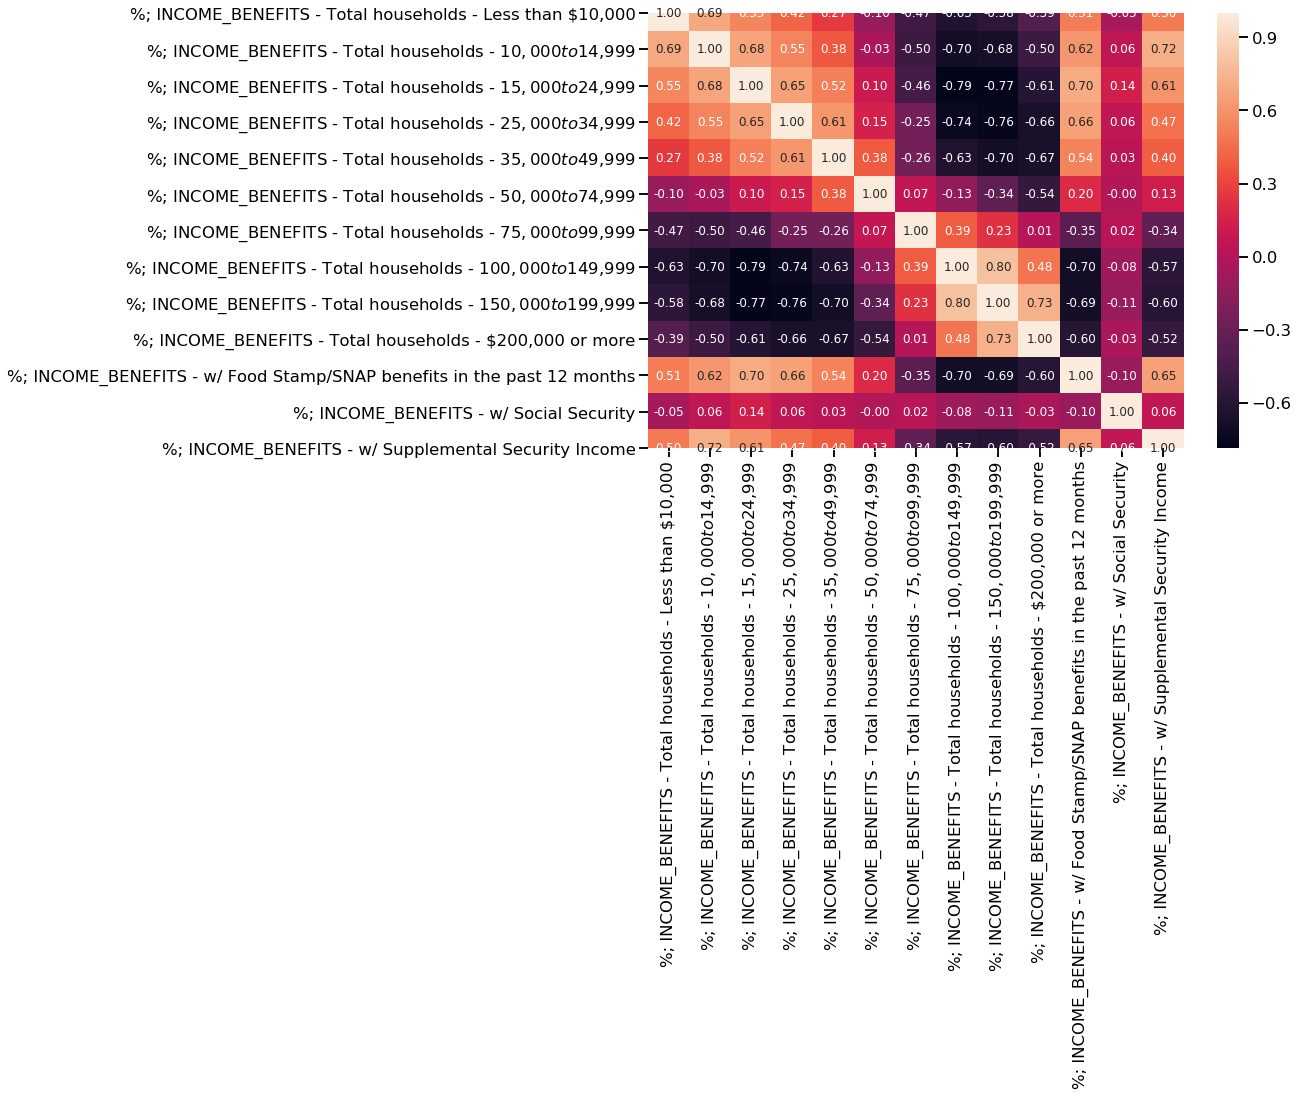

<IPython.core.display.Javascript object>

In [342]:
# Check for correlated and anti-correlated features - done before and after column filtering
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_ib].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [343]:
# Categorical breakdown of percent household income
sns.pairplot(df_state_info_gs_census.loc[:, col_census_pct_ib])

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/seaborn/axisgrid.py:1306: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


Error in callback <function flush_figures at 0x126f74950> (for post_execute):


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [344]:
# Iteration 2 - hand select other columns to account for correlations anti-correlations, etc.

# % cash public assistance correlates with Food Stamp benefits
col_census_pct_ib_final = [
    "%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months",
    "%; INCOME_BENEFITS - w/ Social Security",
    "%; INCOME_BENEFITS - w/ Supplemental Security Income",
]

<IPython.core.display.Javascript object>

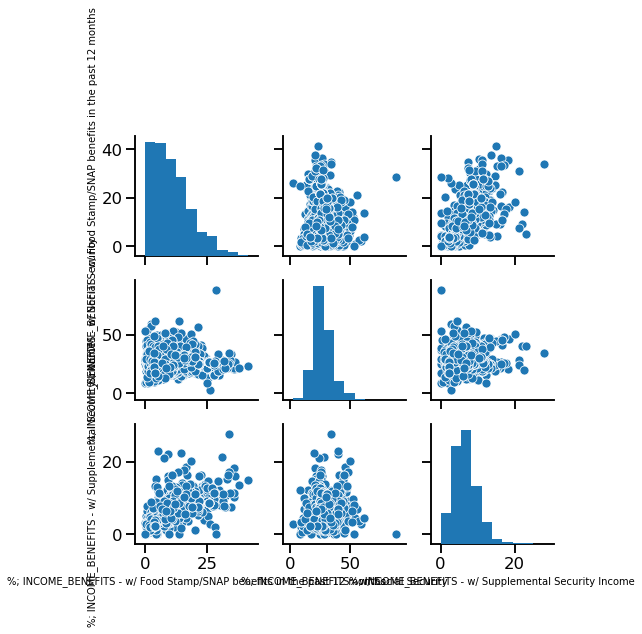

<IPython.core.display.Javascript object>

In [345]:
# Categorical breakdown of percent household income after feature culling
sns.pairplot(df_state_info_gs_census.loc[:, col_census_pct_ib_final]);


In [294]:
# View all correlation values, reshaping table
# df_state_info_gs_census[col_census_pct_ib[0:3]].corr(method='pearson')

<IPython.core.display.Javascript object>

##### Evaluation of estimated income benefits

In [346]:
col_census_est_ib = col_census_est[
    df_state_info_gs_census[col_census_est].columns.str.contains("INCOME_BENEFITS")
]
col_census_est_ib

Index(['Est.; INCOME_BENEFITS - Total households - Median household income ($)',
       'Est.; INCOME_BENEFITS - Total households - Mean household income ($)',
       'Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)',
       'Est.; INCOME_BENEFITS - w/ retirement income',
       'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income',
       'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
       'Est.; INCOME_BENEFITS - Families - Median family income ($)',
       'Est.; INCOME_BENEFITS - Families - Mean family income ($)',
       'Est.; INCOME_BENEFITS - Per capita income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Median nonfamily income ($)',
       'Est.; INCOME_BENEFITS - Nonfamily households - Mean nonfamily income ($)'],
      dtype='object')

<IPython.core.display.Javascript object>

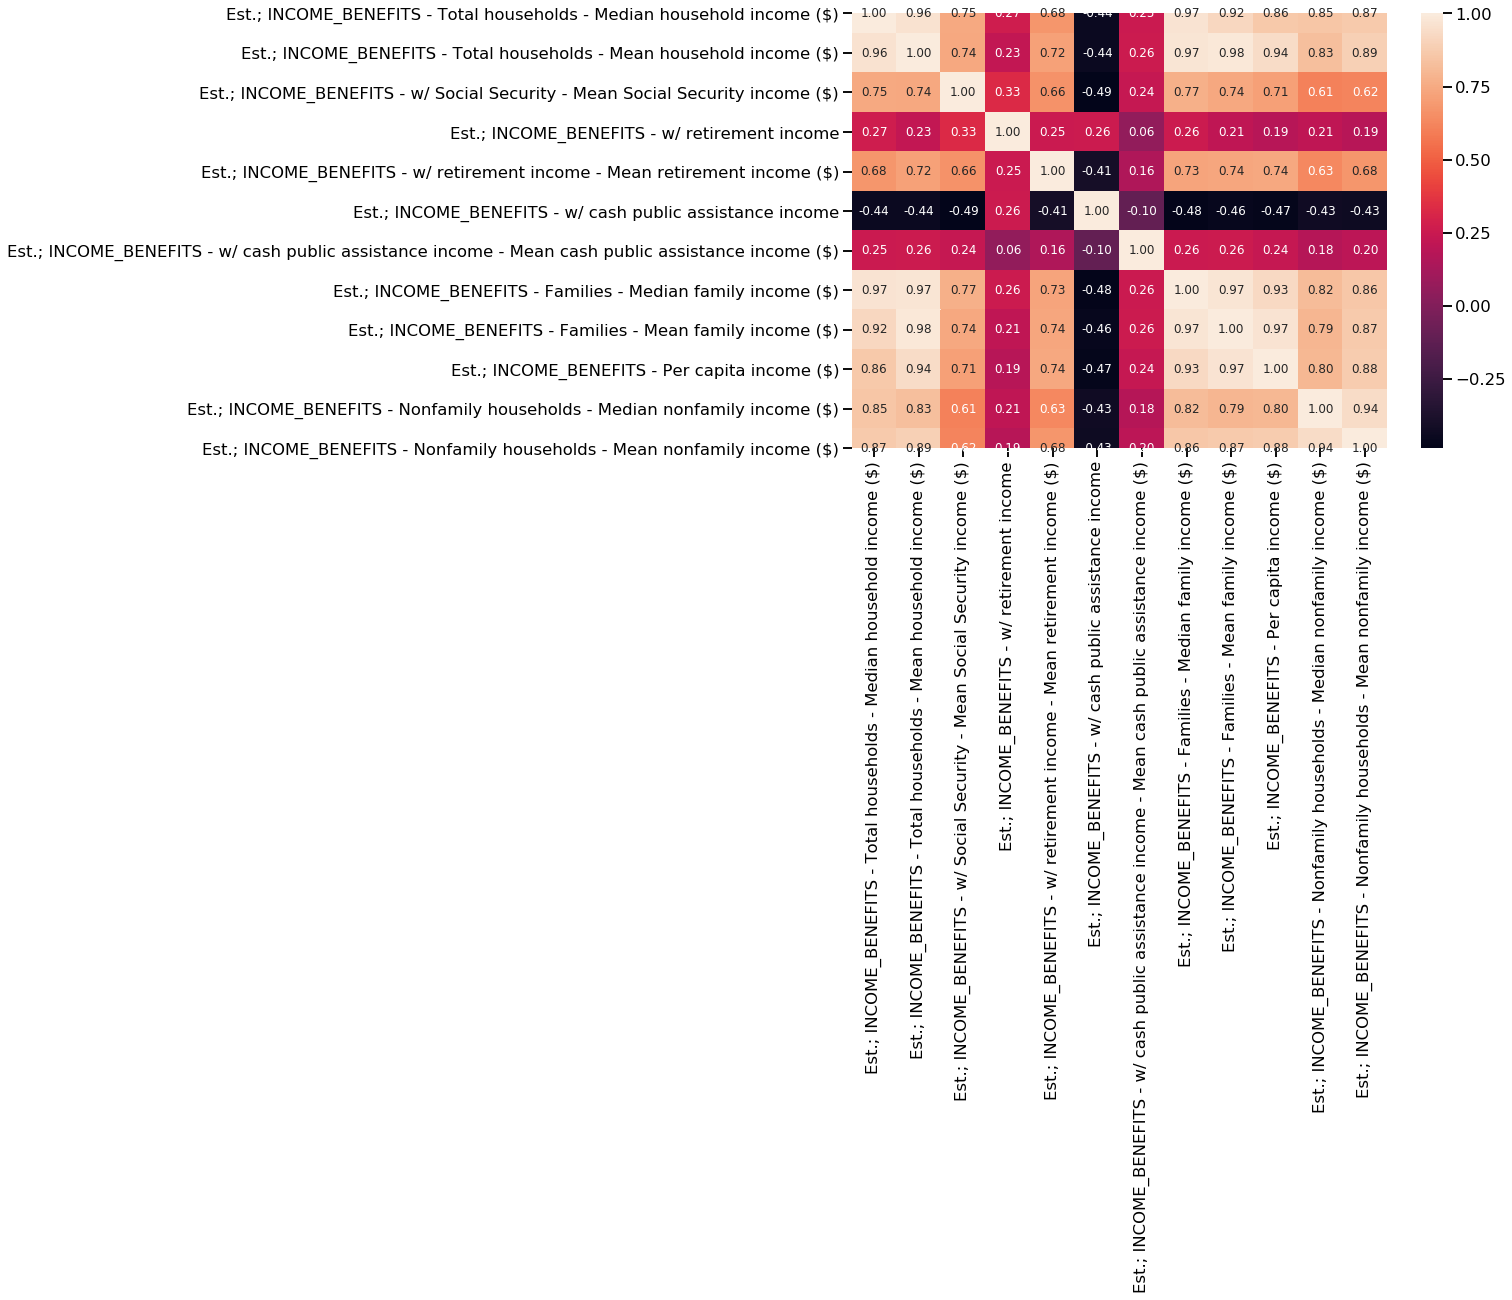

<IPython.core.display.Javascript object>

In [347]:
# Check for correlated and anti-correlated features - done before and after column filtering
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_est_ib].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [348]:
# Iteration 1 - hand select other columns to account for correlations anti-correlations, etc.
col_census_est_ib_final = [
    "Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    "Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)",
    "Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)",
]

<IPython.core.display.Javascript object>

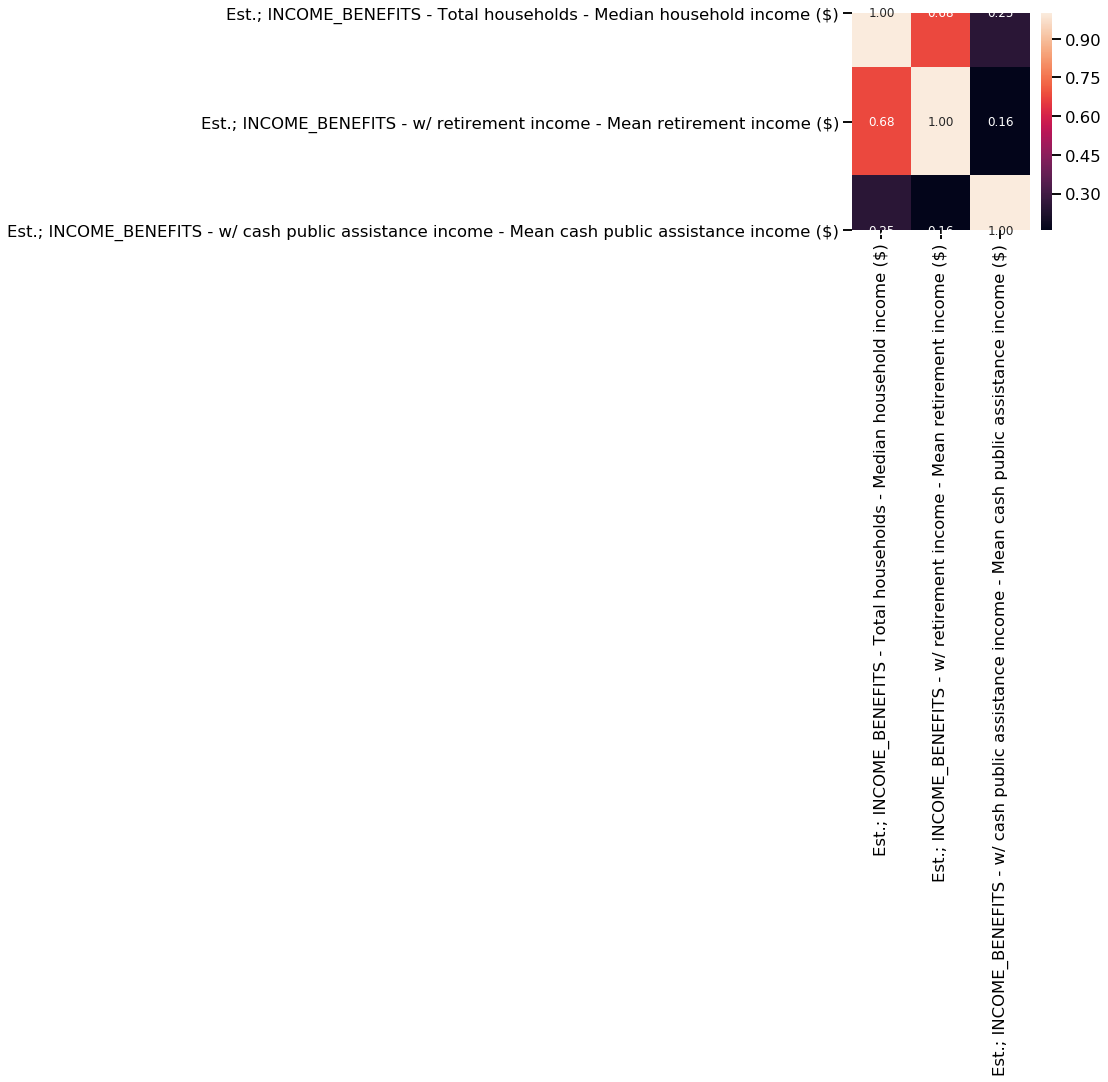

<IPython.core.display.Javascript object>

In [349]:
# Check for correlated and anti-correlated features - done before and after column filtering
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    df_state_info_gs_census[col_census_est_ib_final].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

##### Examination space with text inspection

In [350]:
category_col = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("INCOME_BENEFITS")
]
category_col

Index(['%; INCOME_BENEFITS - w/ retirement income_x',
       '%; INCOME_BENEFITS - w/ cash public assistance income_x',
       '%; INCOME_BENEFITS - Total households - Less than $10,000',
       '%; INCOME_BENEFITS - Total households - $10,000 to $14,999',
       '%; INCOME_BENEFITS - Total households - $15,000 to $24,999',
       '%; INCOME_BENEFITS - Total households - $25,000 to $34,999',
       '%; INCOME_BENEFITS - Total households - $35,000 to $49,999',
       '%; INCOME_BENEFITS - Total households - $50,000 to $74,999',
       '%; INCOME_BENEFITS - Total households - $75,000 to $99,999',
       '%; INCOME_BENEFITS - Total households - $100,000 to $149,999',
       '%; INCOME_BENEFITS - Total households - $150,000 to $199,999',
       '%; INCOME_BENEFITS - Total households - $200,000 or more',
       '%; INCOME_BENEFITS - w/ earnings',
       '%; INCOME_BENEFITS - w/ Social Security',
       '%; INCOME_BENEFITS - w/ retirement income_y',
       '%; INCOME_BENEFITS - w/ Supplement

<IPython.core.display.Javascript object>

In [351]:
category_col = col_census_est[
    df_state_info_gs_census[col_census_est].columns.str.contains("INCOME_BENEFITS")
]
len(category_col)

12

<IPython.core.display.Javascript object>

In [352]:
df_state_info_gs_census[category_col].head()

Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                            32993.0                        
1                                            72884.0                        
2                                            31903.0                        
3                                            31903.0                        
4                                            80970.0                        

   Est.; INCOME_BENEFITS - Total households - Mean household income ($)  \
0                                            55911.0                      
1                                            99612.0                      
2                                            43104.0                      
3                                            43104.0                      
4                                           105995.0                      

   Est.; INCOME_BENEFITS - w/ Social Security - Mean Social Security income ($)  \
0                                            12978.0                              
1                                            17113.0                              
2                                            12293.0                              
3                                            12293.0                              
4                                            17921.0                              

   Est.; INCOME_BENEFITS - w/ retirement income  \
0                                         659.0   
1                                        3804.0   
2                                        1086.0   
3                                        1086.0   
4                                        1085.0   

   Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
0                                            29027.0                           
1                                            32115.0                           
2                                            19269.0                           
3                                            19269.0                           
4                                            36487.0                           

   Est.; INCOME_BENEFITS - w/ cash public assistance income  \
0                                              368.0          
1                                              827.0          
2                                             1268.0          
3                                             1268.0          
4                                               83.0          

   Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)  \
0                                             5055.0                                                   
1                                             4632.0                                                   
2                                             5347.0                                                   
3                                             5347.0                                                   
4                                             4229.0                                                   

   Est.; INCOME_BENEFITS - Families - Median family income ($)  \
0                                            38980.0             
1                                            88693.0             
2                                            34633.0             
3                                            34633.0             
4                                            95880.0             

   Est.; INCOME_BENEFITS - Families - Mean family income ($)  \
0                                            67067.0           
1                                           118416.0           
2                                            44970.0           
3                                            44970.0           
4                                           118328.0           

   Est.; INCOME_

<IPython.core.display.Javascript object>

In [353]:
df_state_info_gs_census[category_col].sum(axis=1)

0       356416.0
1       600439.0
2       254866.0
3       254866.0
4       626472.0
          ...   
1147    434406.0
1148    367796.0
1149    342714.0
1150    342714.0
1151    430859.0
Length: 1152, dtype: float64

<IPython.core.display.Javascript object>

##### Examination space with visualizations of various features

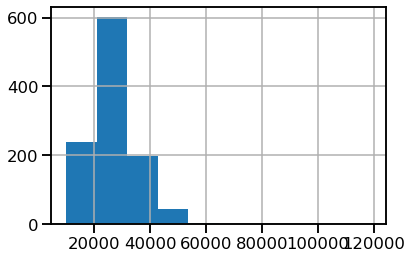

<IPython.core.display.Javascript object>

In [354]:
# Histogram
df_state_info_gs_census[category_col].iloc[:, 4].hist()

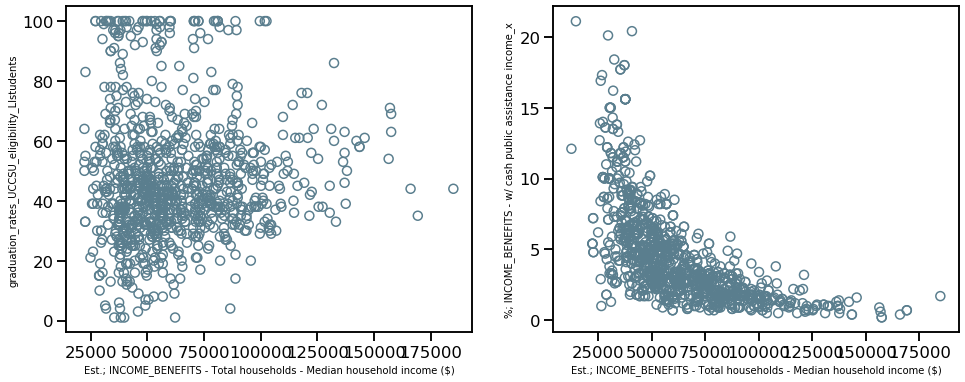

<IPython.core.display.Javascript object>

In [355]:
# Scatter plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(df_state_info_gs_census, 
                          'Est.; INCOME_BENEFITS - Total households - Median household income ($)', 
                          'graduation_rates_UCCSU_eligibility_LIstudents', 
                          ax1)

scatter_plot_open_circles(df_state_info_gs_census, 
                          'Est.; INCOME_BENEFITS - Total households - Median household income ($)', 
                          '%; INCOME_BENEFITS - w/ cash public assistance income_x', 
                          ax2)


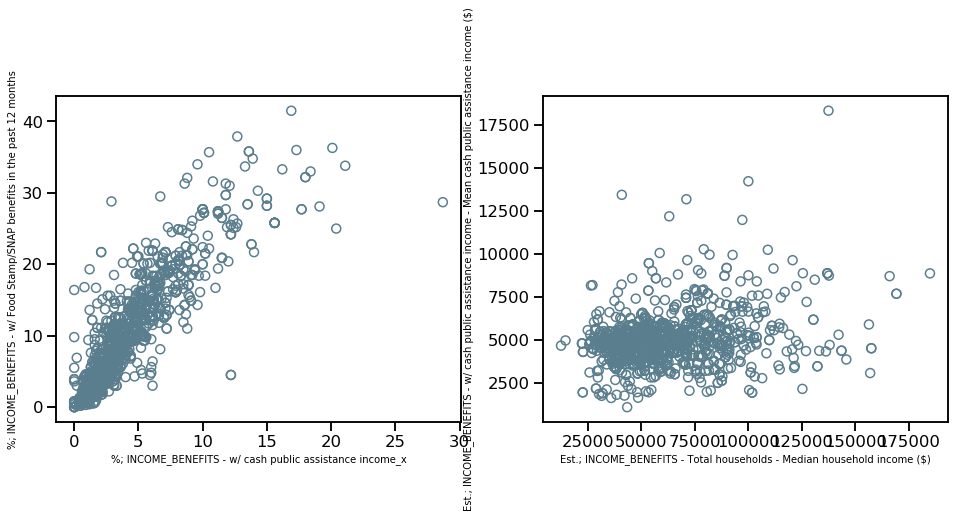

<IPython.core.display.Javascript object>

In [356]:
# Scatter plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(df_state_info_gs_census, 
                          '%; INCOME_BENEFITS - w/ cash public assistance income_x', 
                          '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months', 
                          ax1)

scatter_plot_open_circles(df_state_info_gs_census, 
                          'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
                          'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)', 
                          ax2)


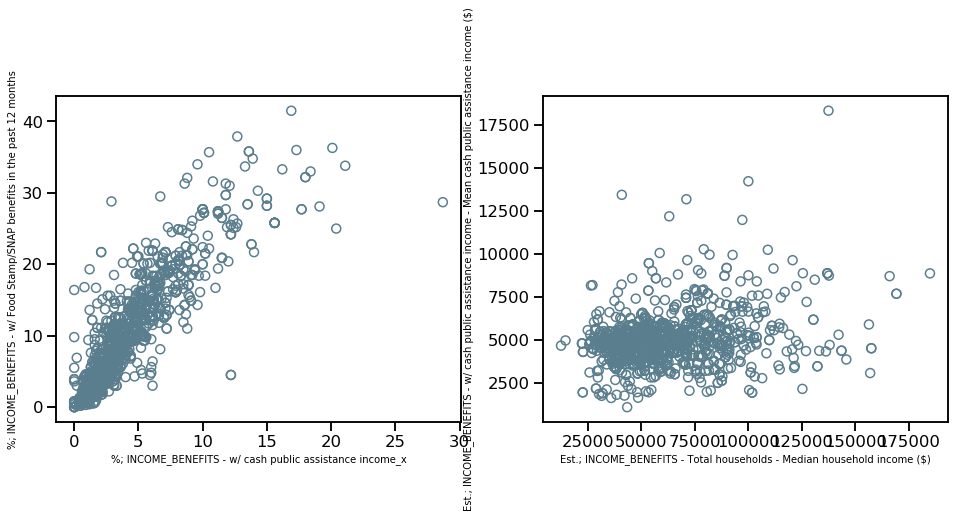

<IPython.core.display.Javascript object>

In [358]:
# Scatter plots - do I need percent and estimated income benefit columns?
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; INCOME_BENEFITS - w/ cash public assistance income_x",
    "%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months",
    ax1,
)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "Est.; INCOME_BENEFITS - Total households - Median household income ($)",
    "Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)",
    ax2,
)

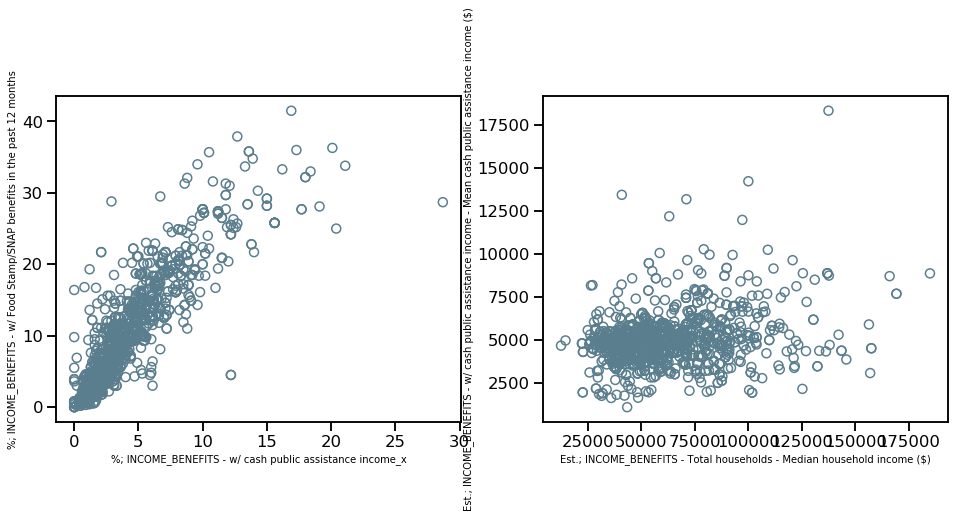

<IPython.core.display.Javascript object>

In [359]:
# Scatter plots - do I need percent and estimated income benefit columns?
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(df_state_info_gs_census, 
                          '%; INCOME_BENEFITS - w/ cash public assistance income_x', 
                          '%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months', 
                          ax1)

scatter_plot_open_circles(df_state_info_gs_census, 
                          'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
                          'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)', 
                          ax2)


#### Health insurance columns

In [360]:
col_census_pct_hi = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("HEALTH_INS")
].tolist()

<IPython.core.display.Javascript object>

In [361]:
col_census_pct_hi

['%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ private health insurance',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - No health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Employed: - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Employed: - w/ health ins coverage - w/ private health insurance',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. 18-64 yrs - In labor force: - Employed: - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized p

<IPython.core.display.Javascript object>

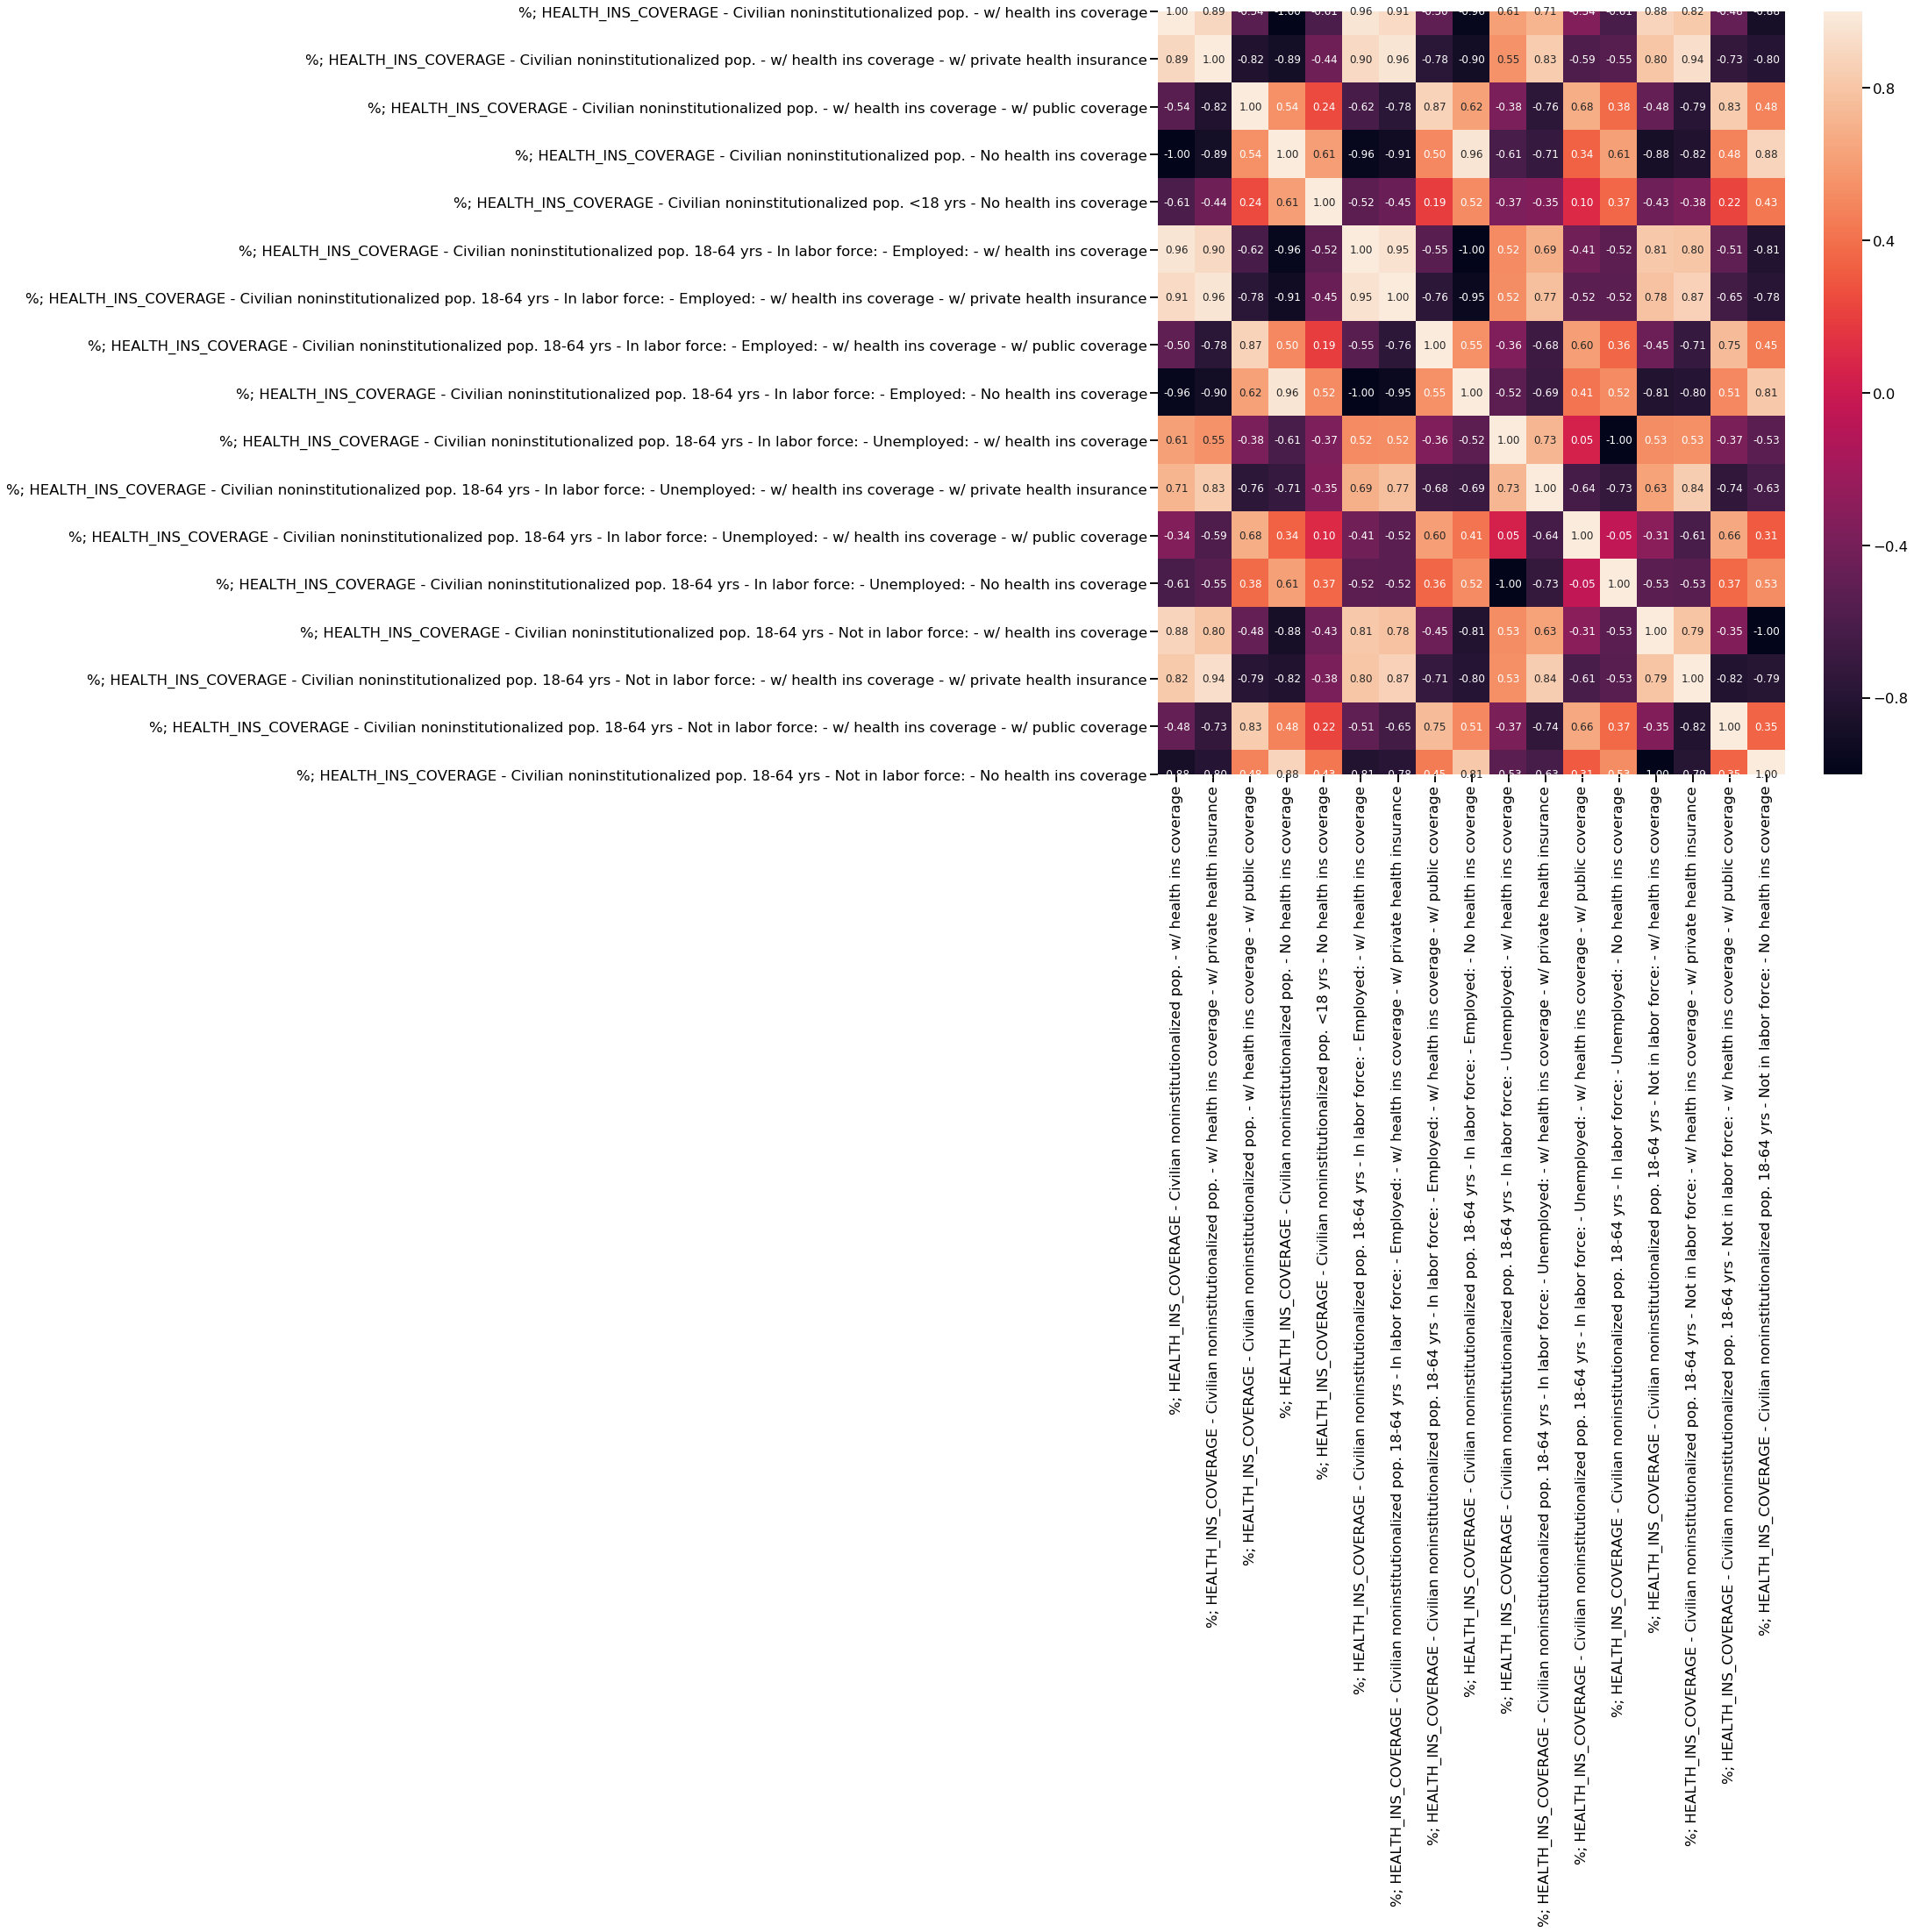

<IPython.core.display.Javascript object>

In [362]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_hi].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [363]:
# Iteration 1 - hand select other columns to account for correlations anti-correlations, etc.
# Removed those with

col_census_pct_hi_v0 = [
    "%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage",
    "%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage",
    "%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage",
]

<IPython.core.display.Javascript object>

In [364]:
df_state_info_gs_census[col_census_pct_hi_v0].corr(method="pearson")

%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage  \
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           1.000000                                      
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                          -0.540853                                      
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                          -0.609231                                      

                                                    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage  \
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                          -0.540853                                                           
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           1.000000                                                           
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           0.242434                                                           

                                                    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage  
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                          -0.609231                                             
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           0.242434                                             
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           1.000000

<IPython.core.display.Javascript object>

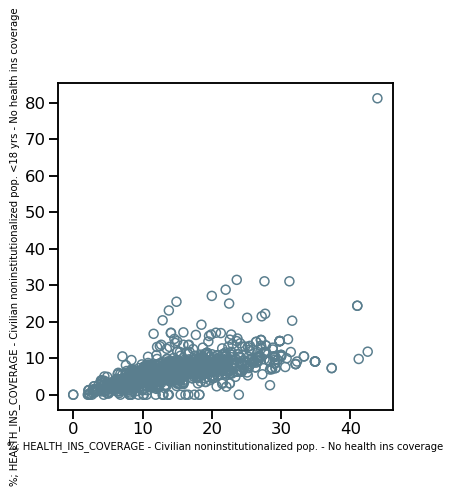

<IPython.core.display.Javascript object>

In [365]:
# Scatter plots - do I need percent and estimated income benefit columns?
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - No health ins coverage",
    "%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage",
    ax1,
)

In [366]:
col_census_pct_hi_final = col_census_pct_hi_v0.copy()
col_census_pct_hi_final

['%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage']

<IPython.core.display.Javascript object>

#### Work commute columns

In [367]:
col_census_pct_wc = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("WORK_COMMUTE")
].tolist()
col_census_pct_wc

['%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Walked',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Other means',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home']

<IPython.core.display.Javascript object>

In [368]:
df_state_info_gs_census[col_census_pct_wc].corr(method="pearson")

%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone  \
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                           1.000000                             
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.134708                             
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                          -0.748350                             
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                            -0.621511                             
%; WORK_COMMUTE - Workers 16 yrs and up - Other...                                          -0.478256                             
%; WORK_COMMUTE - Workers 16 yrs and up - Worke...                                          -0.256264                             

                                                    %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled  \
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.134708                           
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                           1.000000                           
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                          -0.076330                           
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                            -0.187178                           
%; WORK_COMMUTE - Workers 16 yrs and up - Other...                                          -0.069642                           
%; WORK_COMMUTE - Workers 16 yrs and up - Worke...                                          -0.390938                           

                                                    %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)  \
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.748350                                     
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.076330                                     
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                           1.000000                                     
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                             0.287804                                     
%; WORK_COMMUTE - Workers 16 yrs and up - Other...                                           0.195814                                     
%; WORK_COMMUTE - Workers 16 yrs and up - Worke...                                          -0.073084                                     

                                                    %; WORK_COMMUTE - Workers 16 yrs and up - Walked  \
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                         -0.621511   
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                         -0.187178   
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                          0.287804   
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                            1.000000   
%; WORK_COMMUTE - Workers 16 yrs and up - Other...                                          0.385832   
%; WORK_COMMUTE - Workers 16 yrs and up - Worke...                                          0.162550   

                                                    %; WORK_COMMUTE - Workers 16 yrs and up - Other means  \
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.478256       
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.069642       
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                           0.195814       
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                           

<IPython.core.display.Javascript object>

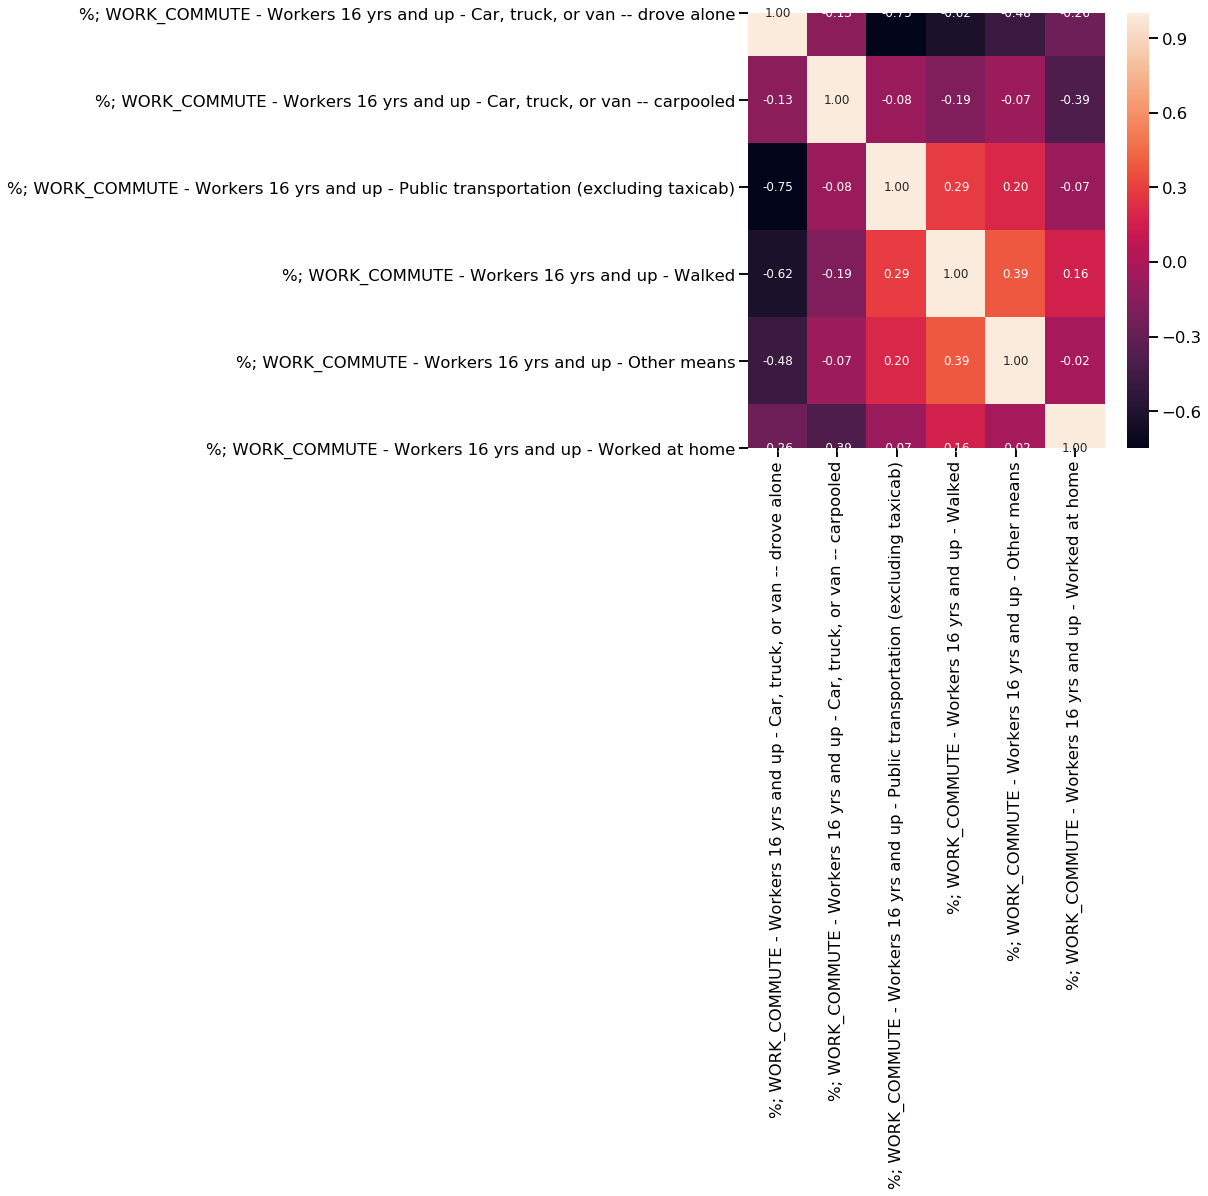

<IPython.core.display.Javascript object>

In [369]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_wc].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

NameError: name 'work_commute_col' is not defined

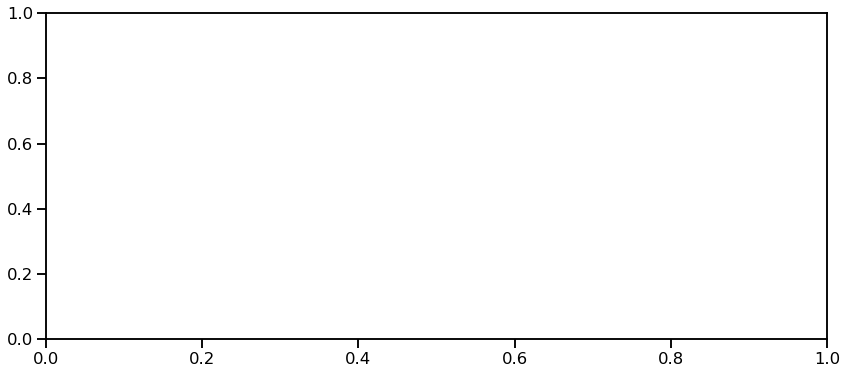

<IPython.core.display.Javascript object>

In [371]:
f, ax1 = plt.subplots(figsize=(14, 6))

ax1.stackplot(
    range(len(df_state_info_gs_census)),
    df_state_info_gs_census[work_commute_col].iloc[:, 0],
    df_state_info_gs_census[work_commute_col].iloc[:, 1],
    df_state_info_gs_census[work_commute_col].iloc[:, 2],
    df_state_info_gs_census[work_commute_col].iloc[:, 3],
    df_state_info_gs_census[work_commute_col].iloc[:, 4],
    df_state_info_gs_census[work_commute_col].iloc[:, 5],
    colors=B_colors_cat[0:6],
    labels=[
        "drove alone",
        "carpool",
        "public transportation",
        "walked",
        "other",
        "worked from home",
    ],
)

ax1.legend()

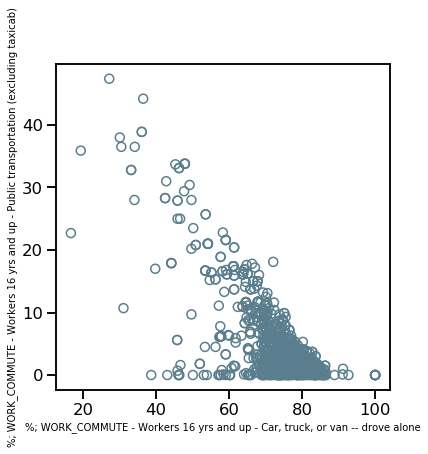

<IPython.core.display.Javascript object>

In [372]:
# Scatter plots - do I need percent and estimated income benefit columns?
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone",
    "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    ax1,
)

**The Pearson is -.0.75. It's borderline, but I'll keep both "drove alone" and "public transportation" since it's possible that they could be giving different information. But I will drop "other" and "work from home"**

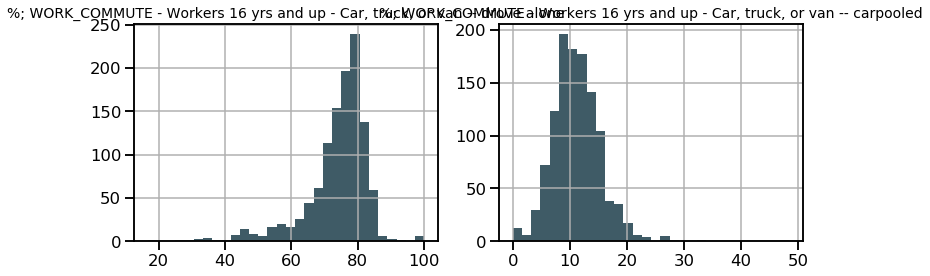

<IPython.core.display.Javascript object>

In [373]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone",
    ax1,
)

hist_plot(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",
    ax2,
)

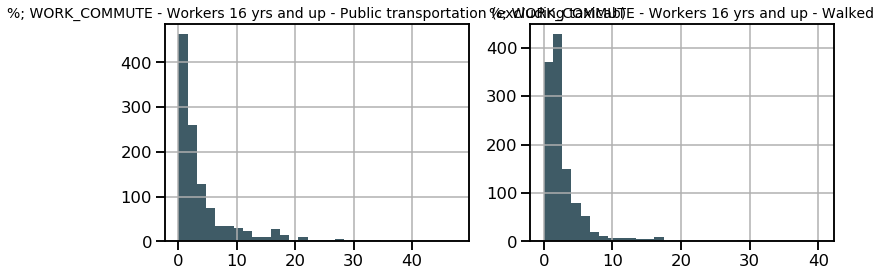

<IPython.core.display.Javascript object>

In [374]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    ax1,
)

hist_plot(
    df_state_info_gs_census, "%; WORK_COMMUTE - Workers 16 yrs and up - Walked", ax2,
)

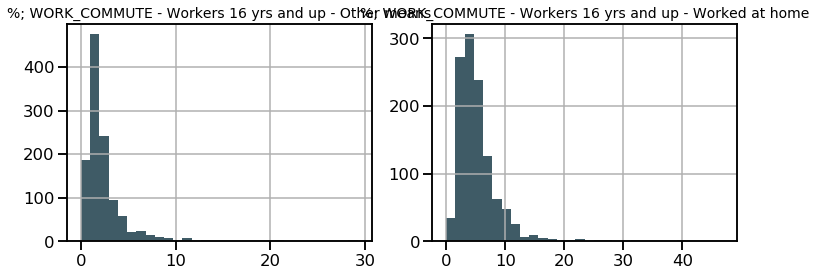

<IPython.core.display.Javascript object>

In [375]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Other means",
    ax1,
)

hist_plot(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home",
    ax2,
)

In [383]:
# Chose these since they had a more normal distribution and minimized correlations/anti-correlations
col_census_pct_wc_final = [
    "%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone",
    "%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled",
    "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    "%; WORK_COMMUTE - Workers 16 yrs and up - Walked",
    "%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home",
]

<IPython.core.display.Javascript object>

#### Occupation and industry columns

In [384]:
col_census_pct_occ = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("OCCUPATION")
].tolist()
col_census_pct_occ

['%; OCCUPATION - Civilian employed pop. 16 yrs and up - Management, business, science, and arts occupations',
 '%; OCCUPATION - Civilian employed pop. 16 yrs and up - Service occupations',
 '%; OCCUPATION - Civilian employed pop. 16 yrs and up - Sales and office occupations',
 '%; OCCUPATION - Civilian employed pop. 16 yrs and up - Natural resources, construction, and maintenance occupations',
 '%; OCCUPATION - Civilian employed pop. 16 yrs and up - Production, transportation, and material moving occupations']

<IPython.core.display.Javascript object>

In [386]:
df_state_info_gs_census[col_census_pct_occ].corr(method="pearson")

%; OCCUPATION - Civilian employed pop. 16 yrs and up - Management, business, science, and arts occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.651119                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.112866                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.637251                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.772026                                                            

                                                    %; OCCUPATION - Civilian employed pop. 16 yrs and up - Service occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.651119                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.005824                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.171893                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.314625                            

                                                    %; OCCUPATION - Civilian employed pop. 16 yrs and up - Sales and office occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.112866                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.005824                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.377559                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.019558                                     

                                                    %; OCCUPATION - Civilian employed pop. 16 yrs and up - Natural resources, construction, and maintenance occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.637251                                                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.171893                                                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.377559                                                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                                                                     
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.327353                                                                     

                                                    %; OCCUPATION - Civilian employed pop. 16 yrs and up - Production, transportation, and material moving occupations  
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.772026                                                                   
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.314

<IPython.core.display.Javascript object>

In [387]:
col_census_pct_industry = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("INDUSTRY")
].tolist()
col_census_pct_industry

['%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Construction',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Wholesale trade',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Retail trade',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Transportation and warehousing, and utilities',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Finance and insurance, and real estate and rental and leasing',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services',
 '%; INDUSTRY - Civilian employed pop. 16 yrs and up - Educational services, and health care and social assistance',
 '%; INDUSTRY - Civilian employed pop. 16 yrs an

<IPython.core.display.Javascript object>

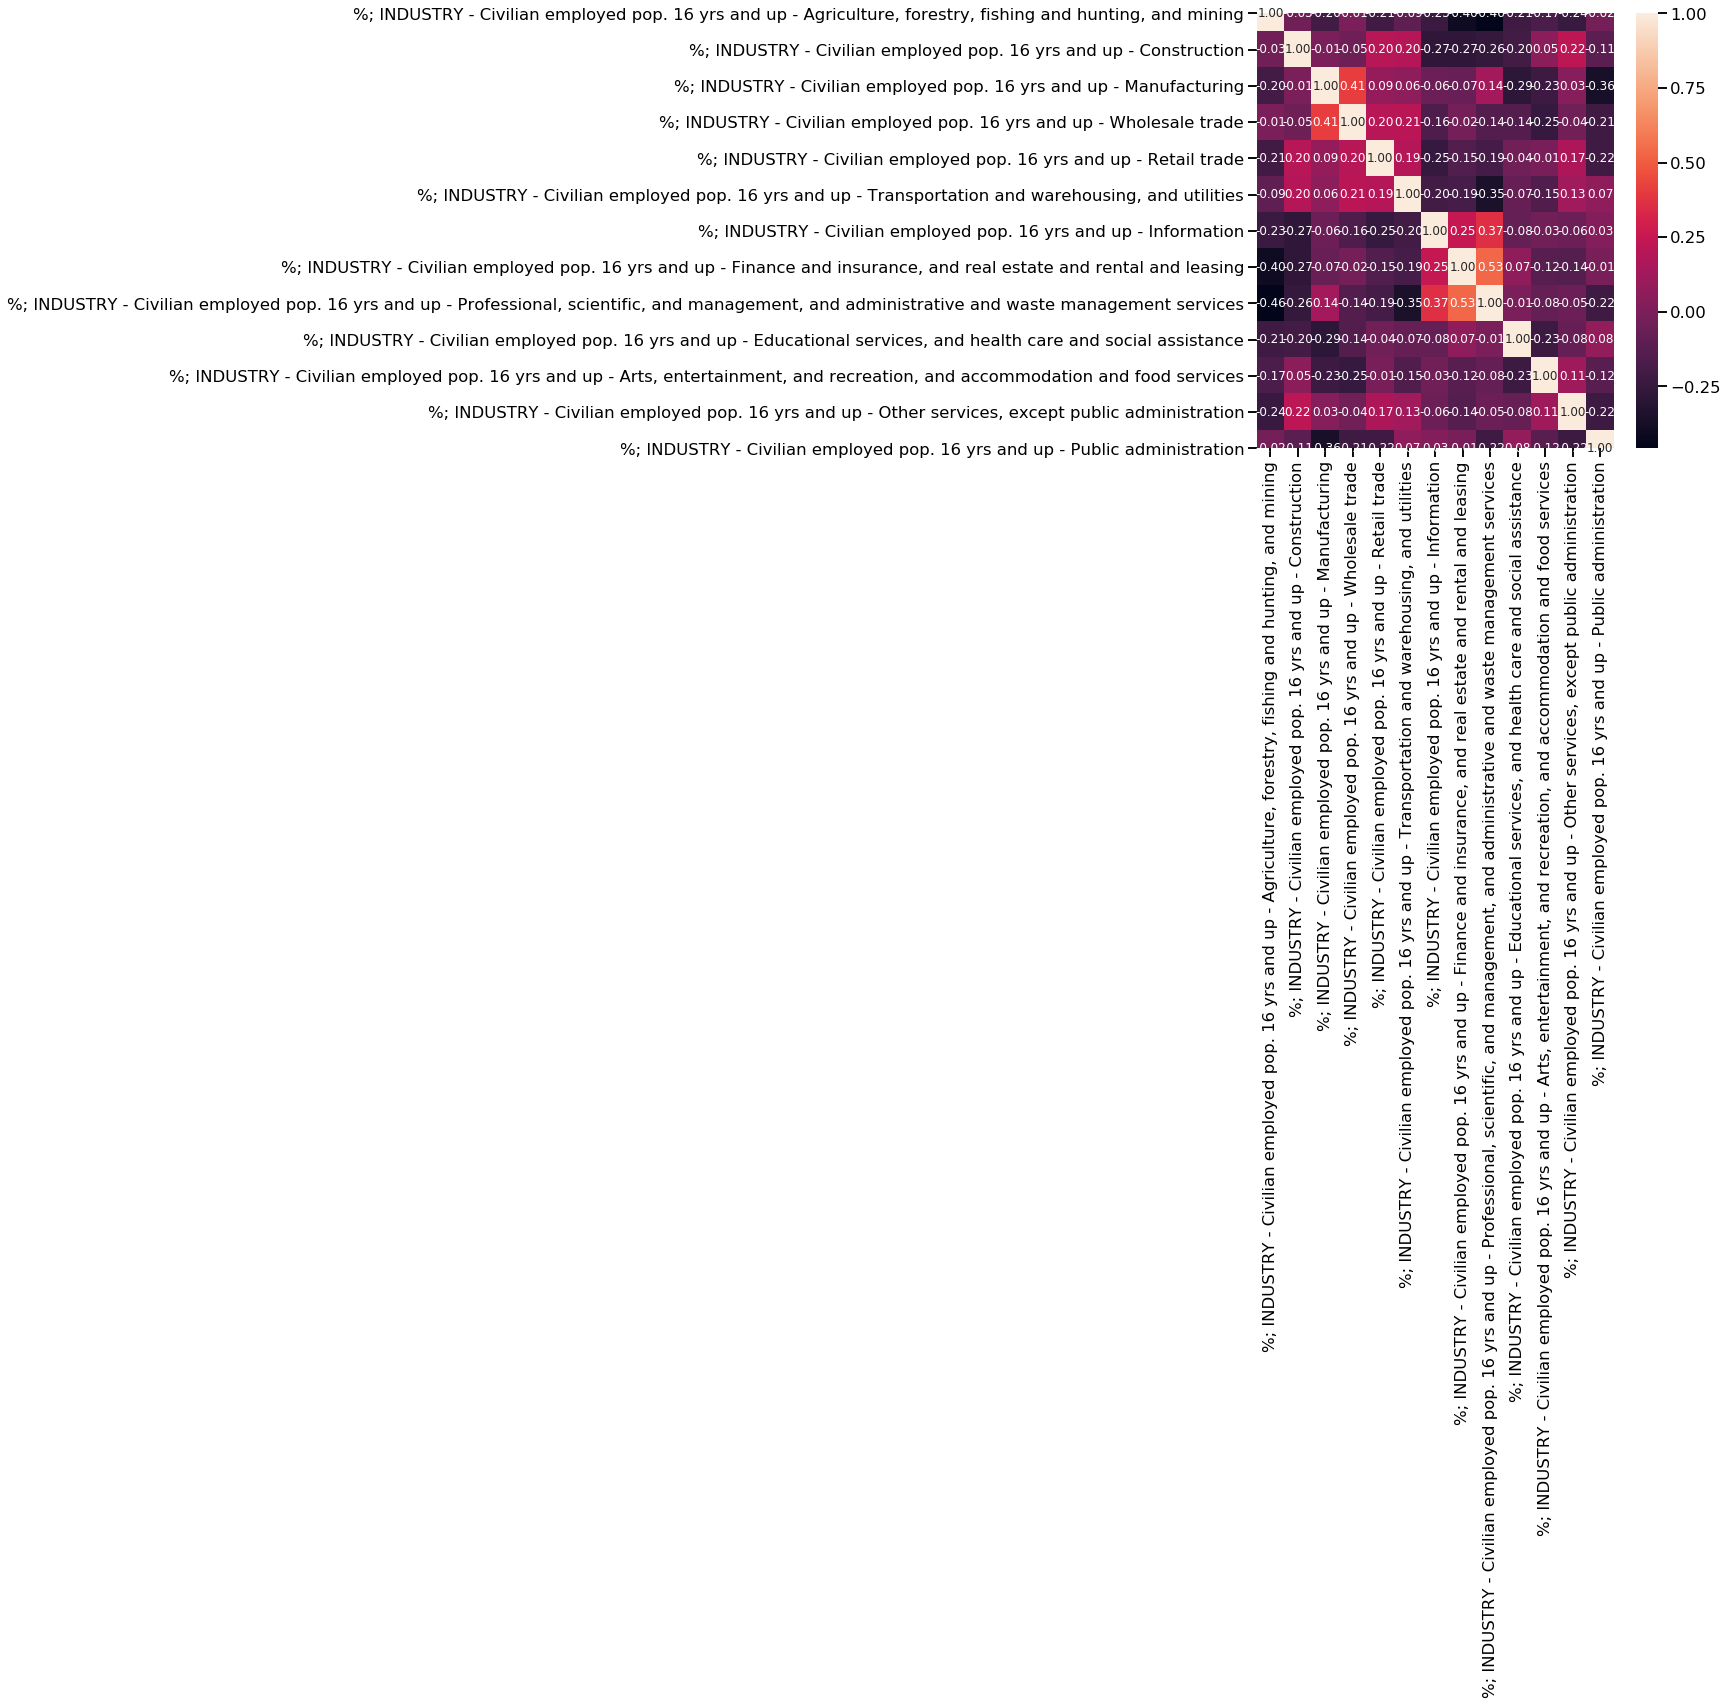

<IPython.core.display.Javascript object>

In [388]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_industry].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [389]:
# df_state_info_gs_census[col_census_pct_industry].corr(method="pearson")

<IPython.core.display.Javascript object>

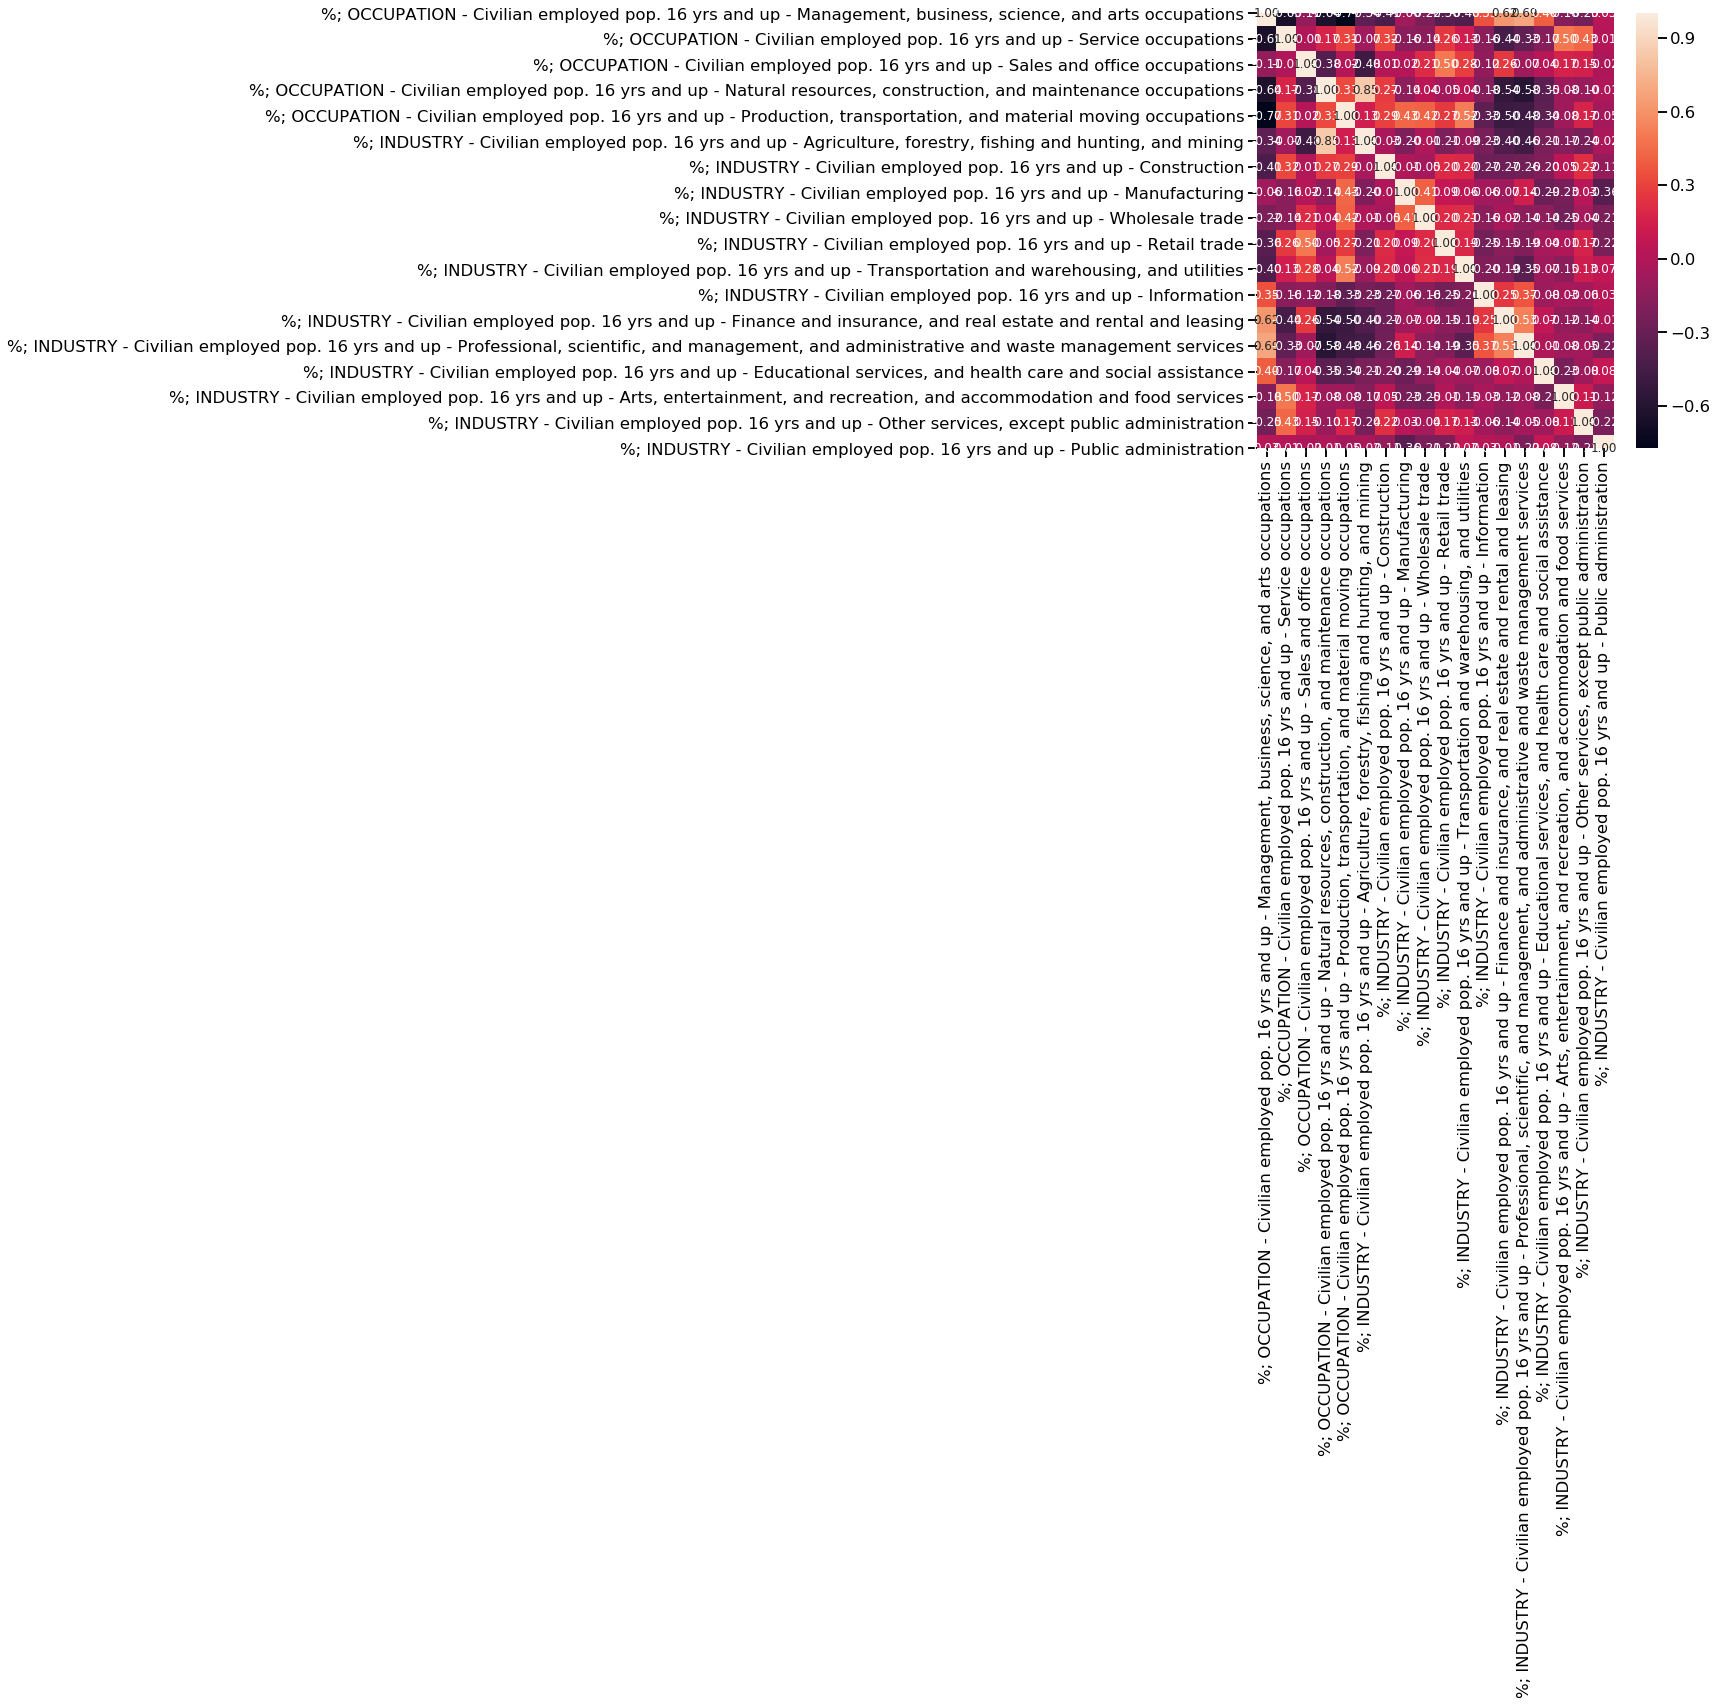

<IPython.core.display.Javascript object>

In [390]:
# Occupational and industry columns
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_occ + col_census_pct_industry].corr(
        method="pearson"
    ),
    annot=True,
    fmt="0.2f",
)

In [391]:
df_state_info_gs_census[col_census_pct_occ + col_census_pct_industry].corr(
    method="pearson"
)

%; OCCUPATION - Civilian employed pop. 16 yrs and up - Management, business, science, and arts occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.651119                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.112866                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.637251                                                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.772026                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.336756                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.412884                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.064357                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.216176                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.359250                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.401320                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.354922                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.619367                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.686628                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.402354                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.181746                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.251939                                                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.029640                                                            

                                                    %; OCCUPATION - Civilian employed pop. 16 yrs and up - Service occupations  \
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.651119                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           1.000000                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                          -0.005824                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.171893                            
%; OCCUPATION - Civilian employed pop. 16 yrs a...                                           0.314625                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.065766                            
%; INDUSTRY - Civilian employed pop. 16 yrs and...             

<IPython.core.display.Javascript object>

**I'll keep the industry columns but drop the occupation columns. The former is more variable and has fewer correlations/anti-correlations.**

In [392]:
col_census_pct_industry_final = col_census_pct_industry.copy()

<IPython.core.display.Javascript object>

#### Worker class columns

In [393]:
col_census_pct_workerclass = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("WORKER_CLASS")
].tolist()

df_state_info_gs_census[col_census_pct_workerclass].corr(method="pearson")

%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers  \
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           1.000000                                          
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.855091                                          
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.424615                                          
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.223774                                          

                                                    %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Government workers  \
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.855091                             
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           1.000000                             
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.084067                             
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           0.050251                             

                                                    %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers  \
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.424615                                                                 
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.084067                                                                 
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           1.000000                                                                 
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           0.072156                                                                 

                                                    %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Unpaid family workers  
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.223774                               
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           0.050251                               
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           0.072156                               
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           1.000000

<IPython.core.display.Javascript object>

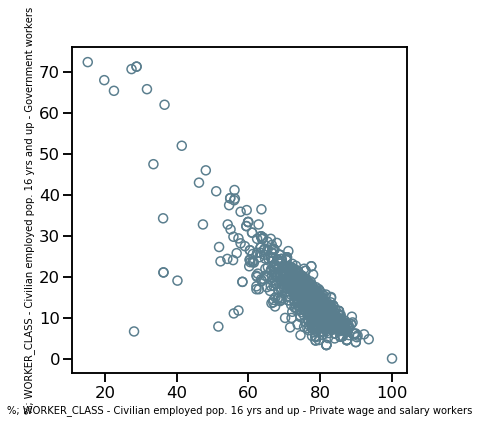

<IPython.core.display.Javascript object>

In [394]:
# Scatter plots - do I need percent and estimated income benefit columns?
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers",
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Government workers",
    ax1,
)

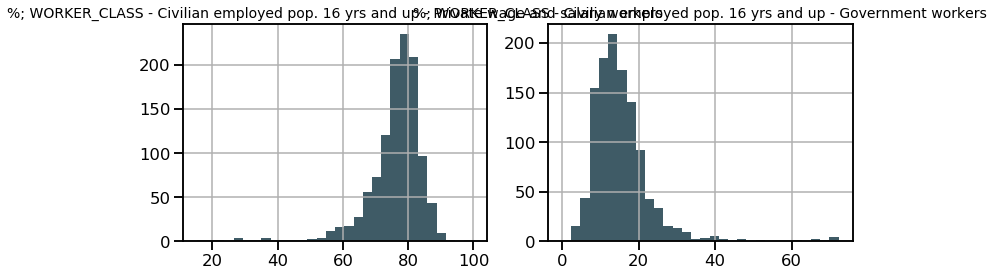

<IPython.core.display.Javascript object>

In [395]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers",
    ax1,
)

hist_plot(
    df_state_info_gs_census,
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Government workers",
    ax2,
)

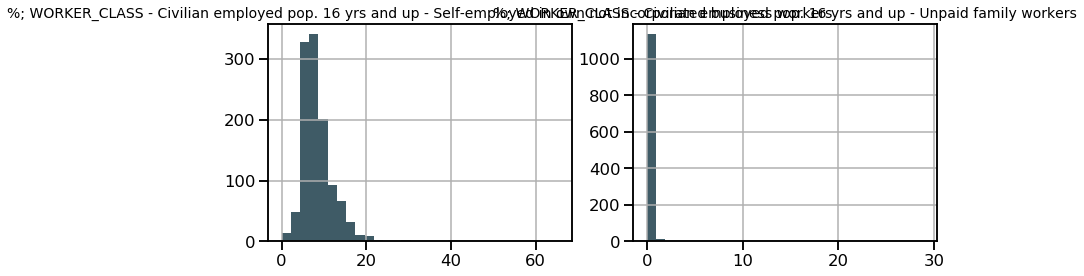

<IPython.core.display.Javascript object>

In [396]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers",
    ax1,
)

hist_plot(
    df_state_info_gs_census,
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Unpaid family workers",
    ax2,
)

**Drop government workers since they're highly correlated with private wage and salary workers. Also drop Unpaid family workers since they're pretty rare.**

In [397]:
col_census_pct_workerclass_final = [
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers",
    "%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Self-employed in own not incorporated business workers",
]

<IPython.core.display.Javascript object>

#### Employment status columns

In [398]:
col_census_pct_employstatus = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains("EMPLOY_STATUS")
].tolist()

df_state_info_gs_census[col_census_pct_employstatus].corr(method="pearson")

%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           1.000000        
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.980370        
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.940891        
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.009738        
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.076908        
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                          -1.000000        
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                          -0.333101        
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.816019        
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.811268        
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.763717        
%; EMPLOY_STATUS - Own children of the househol...                                           0.251985        
%; EMPLOY_STATUS - Own children of the househol...                                           0.337010        

                                                    %; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.980370                               
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           1.000000                               
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.954733                               
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.026683                               
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                          -0.121120                               
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                          -0.980370                               
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                          -0.322781                               
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.806772                               
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.813365                               
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.763647                               
%; EMPLOY_STATUS - Own children of the househol...                                           0.275864                               
%; EMPLOY_STATUS - Own children of the househol...                                           0.339235                               

                                                    %; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.940891                                          
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           0.954733                                          
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                           1.000000                                          
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                          -0.271813                                          
%; EMPLOY_STATUS - Pop. 16 yrs and up - In labo...                                          -0.090588                                          
%; EMPLOY_STATUS - Pop. 16 

<IPython.core.display.Javascript object>

In [399]:
col_census_pct_employstatus

['%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force',
 '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force',
 '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed',
 '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed',
 '%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces',
 '%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force',
 '%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate',
 '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force',
 '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force',
 '%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed',
 '%; EMPLOY_STATUS - Own children of the householder under 6 yrs - All parents in family in labor force',
 '%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force']

<IPython.core.display.Javascript object>

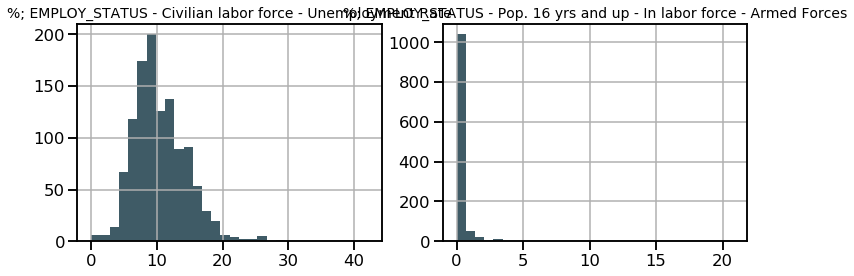

<IPython.core.display.Javascript object>

In [400]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

hist_plot(
    df_state_info_gs_census,
    "%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate",
    ax1,
)

hist_plot(
    df_state_info_gs_census,
    "%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Armed Forces",
    ax2,
)

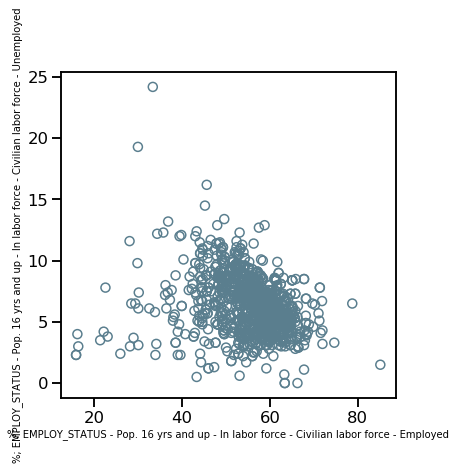

<IPython.core.display.Javascript object>

In [401]:
# Note - I don't entirely understand why
# "In labor force - Civilian labor force - Employed and Civilian labor force" and "Unemployment Rate" are not anti-correlated
# I'll keep only the latter

f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Employed",
    "%; EMPLOY_STATUS - Pop. 16 yrs and up - In labor force - Civilian labor force - Unemployed",
    ax1,
)

In [402]:
col_census_pct_employstatus_final = [
    "%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force",
    "%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate",
    "%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed",
    "%; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force",
]

<IPython.core.display.Javascript object>

In [403]:
df_state_info_gs_census[col_census_pct_employstatus_final].corr(method="pearson")

%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                           1.000000            
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                           0.333101            
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                          -0.763717            
%; EMPLOY_STATUS - Own children of the househol...                                          -0.337010            

                                                    %; EMPLOY_STATUS - Civilian labor force - Unemployment Rate  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                           0.333101             
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                           1.000000             
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                          -0.570974             
%; EMPLOY_STATUS - Own children of the househol...                                          -0.190993             

                                                    %; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed  \
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                          -0.763717                                             
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                          -0.570974                                             
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           1.000000                                             
%; EMPLOY_STATUS - Own children of the househol...                                           0.490307                                             

                                                    %; EMPLOY_STATUS - Own children of the householder 6 to 17 yrs - All parents in family in labor force  
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                          -0.337010                                                      
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                          -0.190993                                                      
%; EMPLOY_STATUS - Females 16 yrs and up - In l...                                           0.490307                                                      
%; EMPLOY_STATUS - Own children of the househol...                                           1.000000

<IPython.core.display.Javascript object>

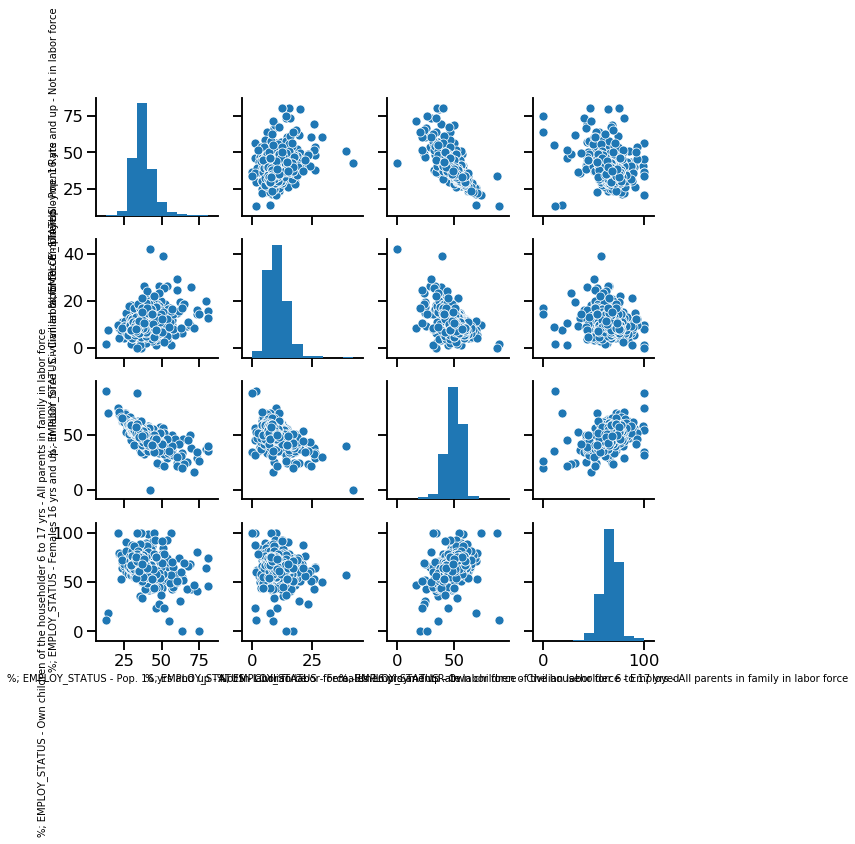

<IPython.core.display.Javascript object>

In [404]:
sns.pairplot(df_state_info_gs_census[col_census_pct_employstatus_final])

#### Percentage of families below poverty line columns

In [405]:
col_census_pct_povertyline = col_census_pct[
    df_state_info_gs_census[col_census_pct].columns.str.contains(
        "AGE_FAMILIES_INCOME_BELOW_POVERTY"
    )
].tolist()

df_state_info_gs_census[col_census_pct_povertyline].corr(method="pearson")

%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families  \
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                                           1.000000       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                                           0.954137       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Marrie...                                           0.926511       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Marrie...                                           0.873690       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All pe...                                           0.938880       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.937910       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.938793       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.909696       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs...                                           0.888291       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs                                           0.863695       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.665770       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.985584       
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.665761       

                                                    %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families - w/ related children of the householder <18 yrs  \
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                                           0.954137                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                                           1.000000                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Marrie...                                           0.862861                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Marrie...                                           0.889190                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All pe...                                           0.924765                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.976169                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.976855                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Under ...                                           0.935318                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18 yrs...                                           0.863638                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 18-64 yrs                                           0.860427                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.598186                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.962573                                                        
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - 65 yrs...                                           0.636493                                                        

                                                    %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - Married couple families  \
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                                           0.926511                  
%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All fa...                      

<IPython.core.display.Javascript object>

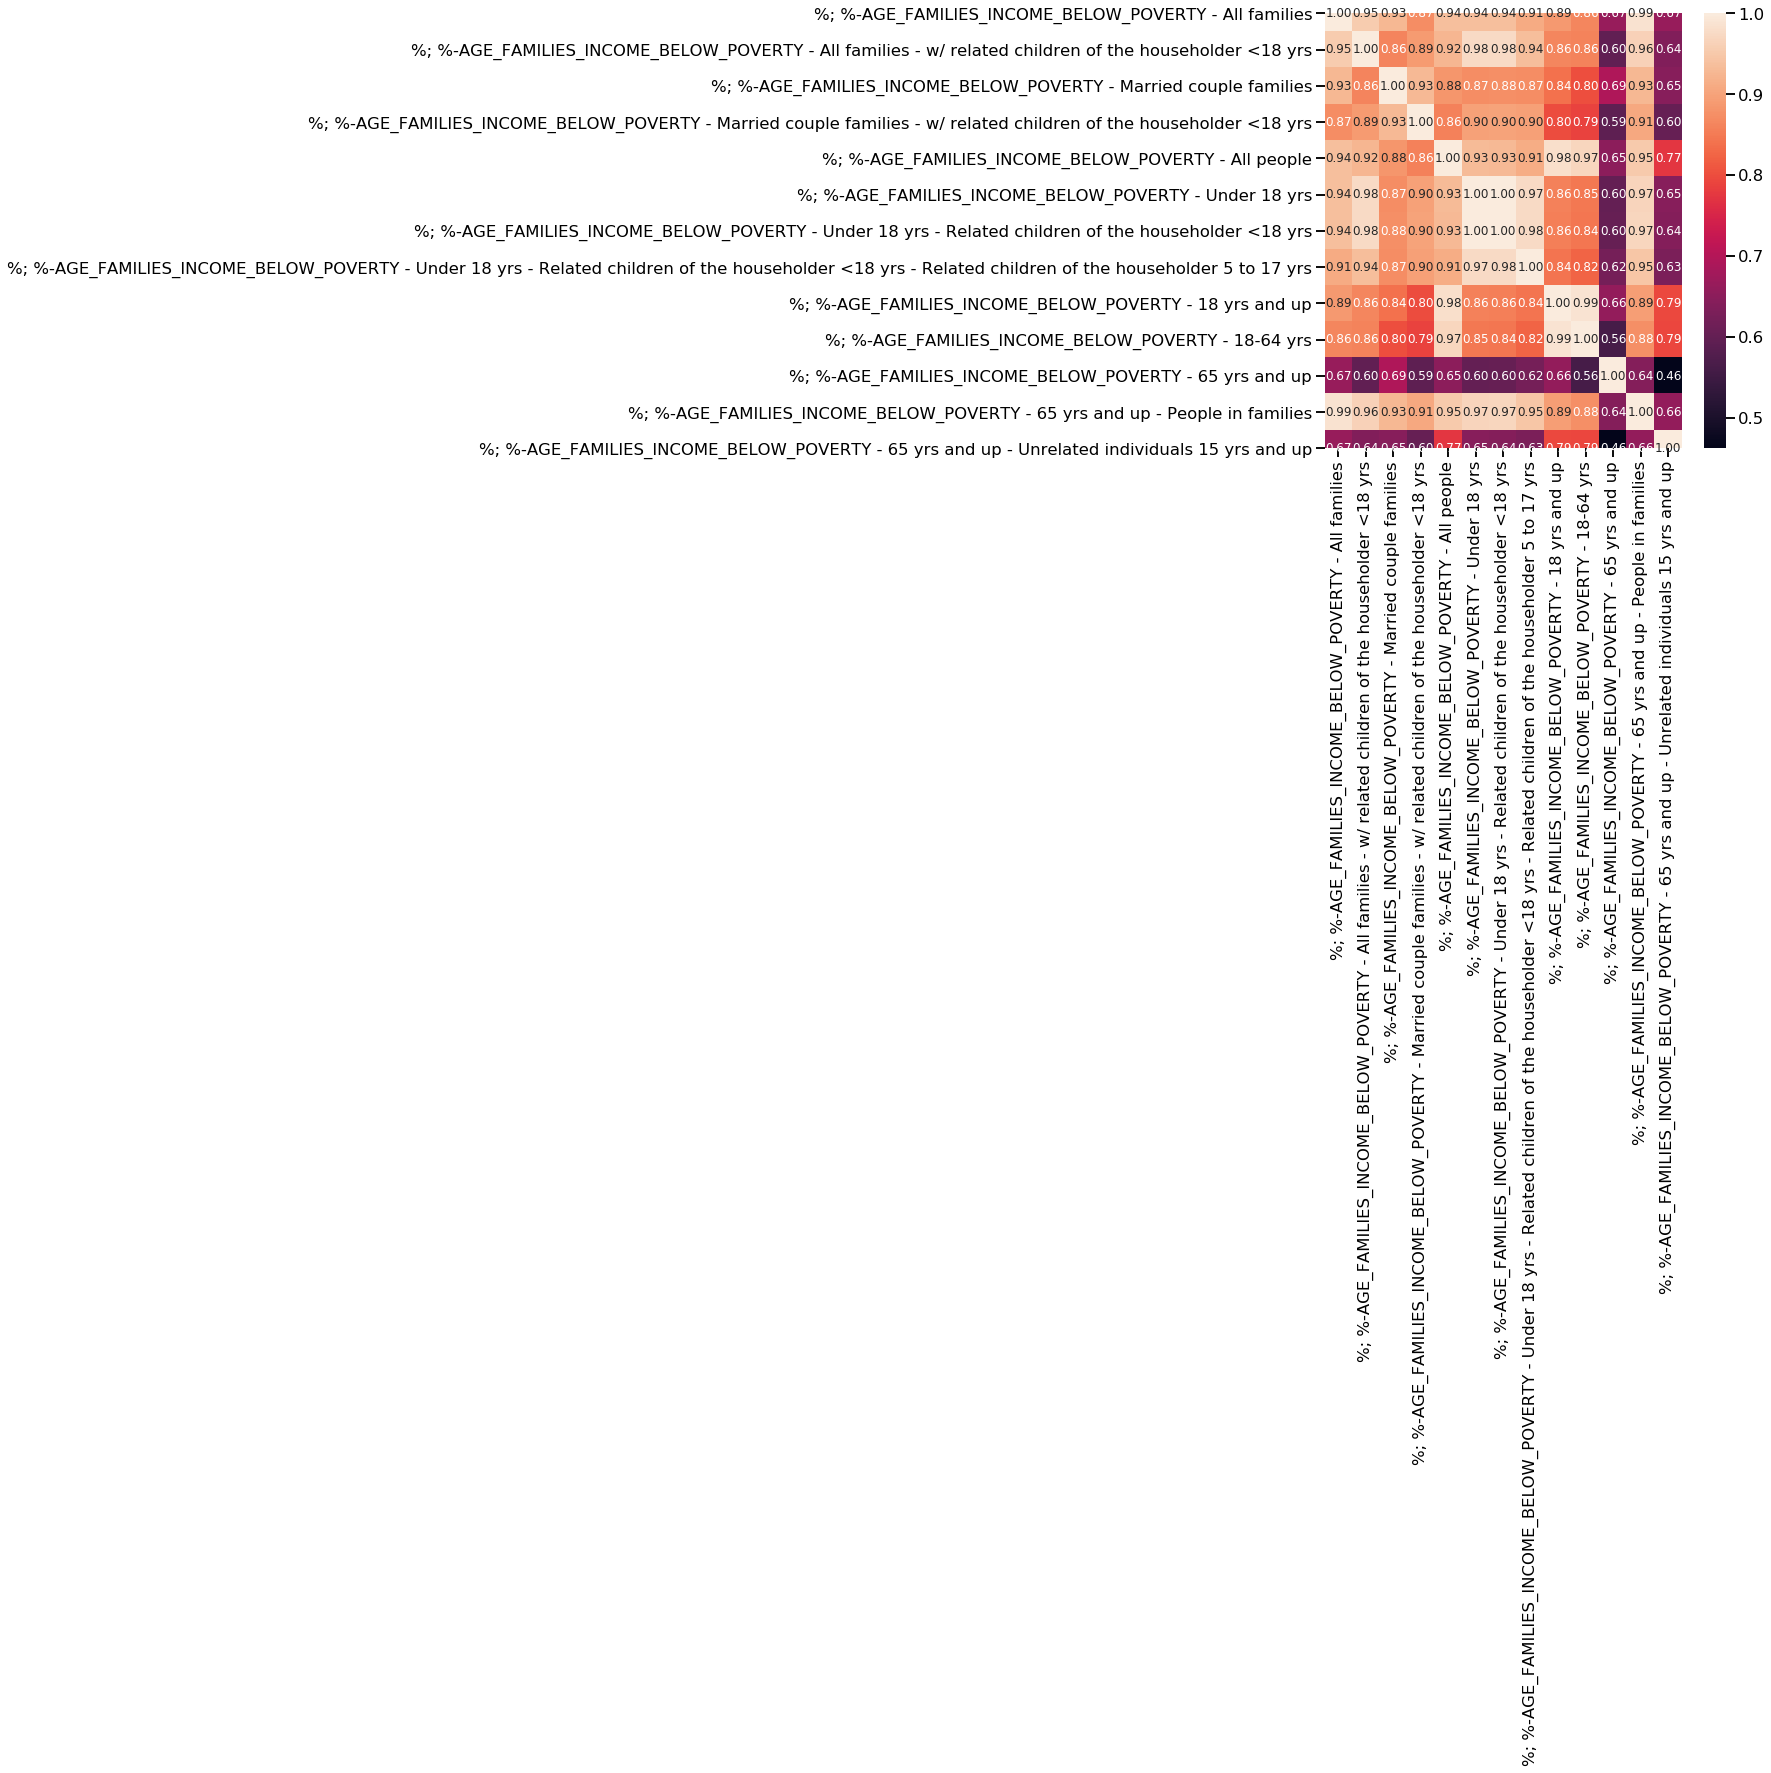

<IPython.core.display.Javascript object>

In [406]:
# Below poverty line columns
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    df_state_info_gs_census[col_census_pct_povertyline].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [407]:
# Just keep this simple - pick one element that's mostly correlated with the others
col_census_pct_povertyline_final = [
    "%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families"
]

<IPython.core.display.Javascript object>

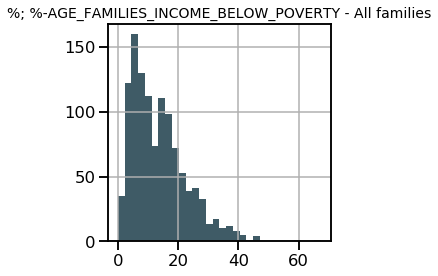

<IPython.core.display.Javascript object>

In [408]:
f, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

hist_plot(
    df_state_info_gs_census,
    "%; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All families",
    ax1,
)



#### Combine final census features, check for other correlations

Before filtering:
- INCOME_BENEFITS - percentage (28 columns) - check for redundant columns and correlated and anti-correlated features
- INCOME_BENEFITS - estimated values - (12 columns) - manually select features
- HEALTH_INS_COVERAGE (17 columns) - manually select columns
- WORK_COMMUTE - adds to 100% (6 columns) - interesting to keep, but drop rare categories
- OCCUPATION - adds to 100% (5 columns) - perhaps drop - may be redundant with industry
- INDUSTRY - adds to 100% (13 columns) - interesting to keep but inspect
- WORKER_CLASS - adds to 100% (4 columns) - OK to keep but inspect
- EMPLOY_STATUS - (12 columns) - OK to keep but inspect
- %-AGE_FAMILIES_INCOME_BELOW_POVERTY (13 columns) - follow up

After filtering:
- INCOME_BENEFITS - percentage (3 columns)
- INCOME_BENEFITS - estimated values - (3 columns)
- HEALTH_INS_COVERAGE (3 columns)
- WORK_COMMUTE - (5 columns)
- OCCUPATION - (0 columns)
- INDUSTRY - (13 columns)
- WORKER_CLASS - (2 columns)
- EMPLOY_STATUS - (4 columns)
- %-AGE_FAMILIES_INCOME_BELOW_POVERTY (1 columns)

In [409]:
print(
    "\n income benefits, percentage - ",
    len(col_census_pct_ib_final),
    "\n income benefits, estimated - ",
    len(col_census_est_ib_final),
    "\n health insurance - ",
    len(col_census_pct_hi_final),
    "\n work commute - ",
    len(col_census_pct_wc_final),
    "\n industry - ",
    len(col_census_pct_industry_final),
    "\n worker class - ",
    len(col_census_pct_workerclass_final),
    "\n employment status - ",
    len(col_census_pct_employstatus_final),
    "\n percent below poverty line - ",
    len(col_census_pct_povertyline_final),
)


 income benefits, percentage -  3 
 income benefits, estimated -  3 
 health insurance -  3 
 work commute -  5 
 industry -  13 
 worker class -  2 
 employment status -  4 
 percent below poverty line -  1


<IPython.core.display.Javascript object>

In [410]:
census_col_final = (
    col_census_pct_ib_final
    + col_census_est_ib_final
    + col_census_pct_hi_final
    + col_census_pct_wc_final
    + col_census_pct_industry_final
    + col_census_pct_workerclass_final
    + col_census_pct_employstatus_final
    + col_census_pct_povertyline_final
)

<IPython.core.display.Javascript object>

In [411]:
col_census_pct_wc_final



['%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Walked',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Worked at home']

<IPython.core.display.Javascript object>

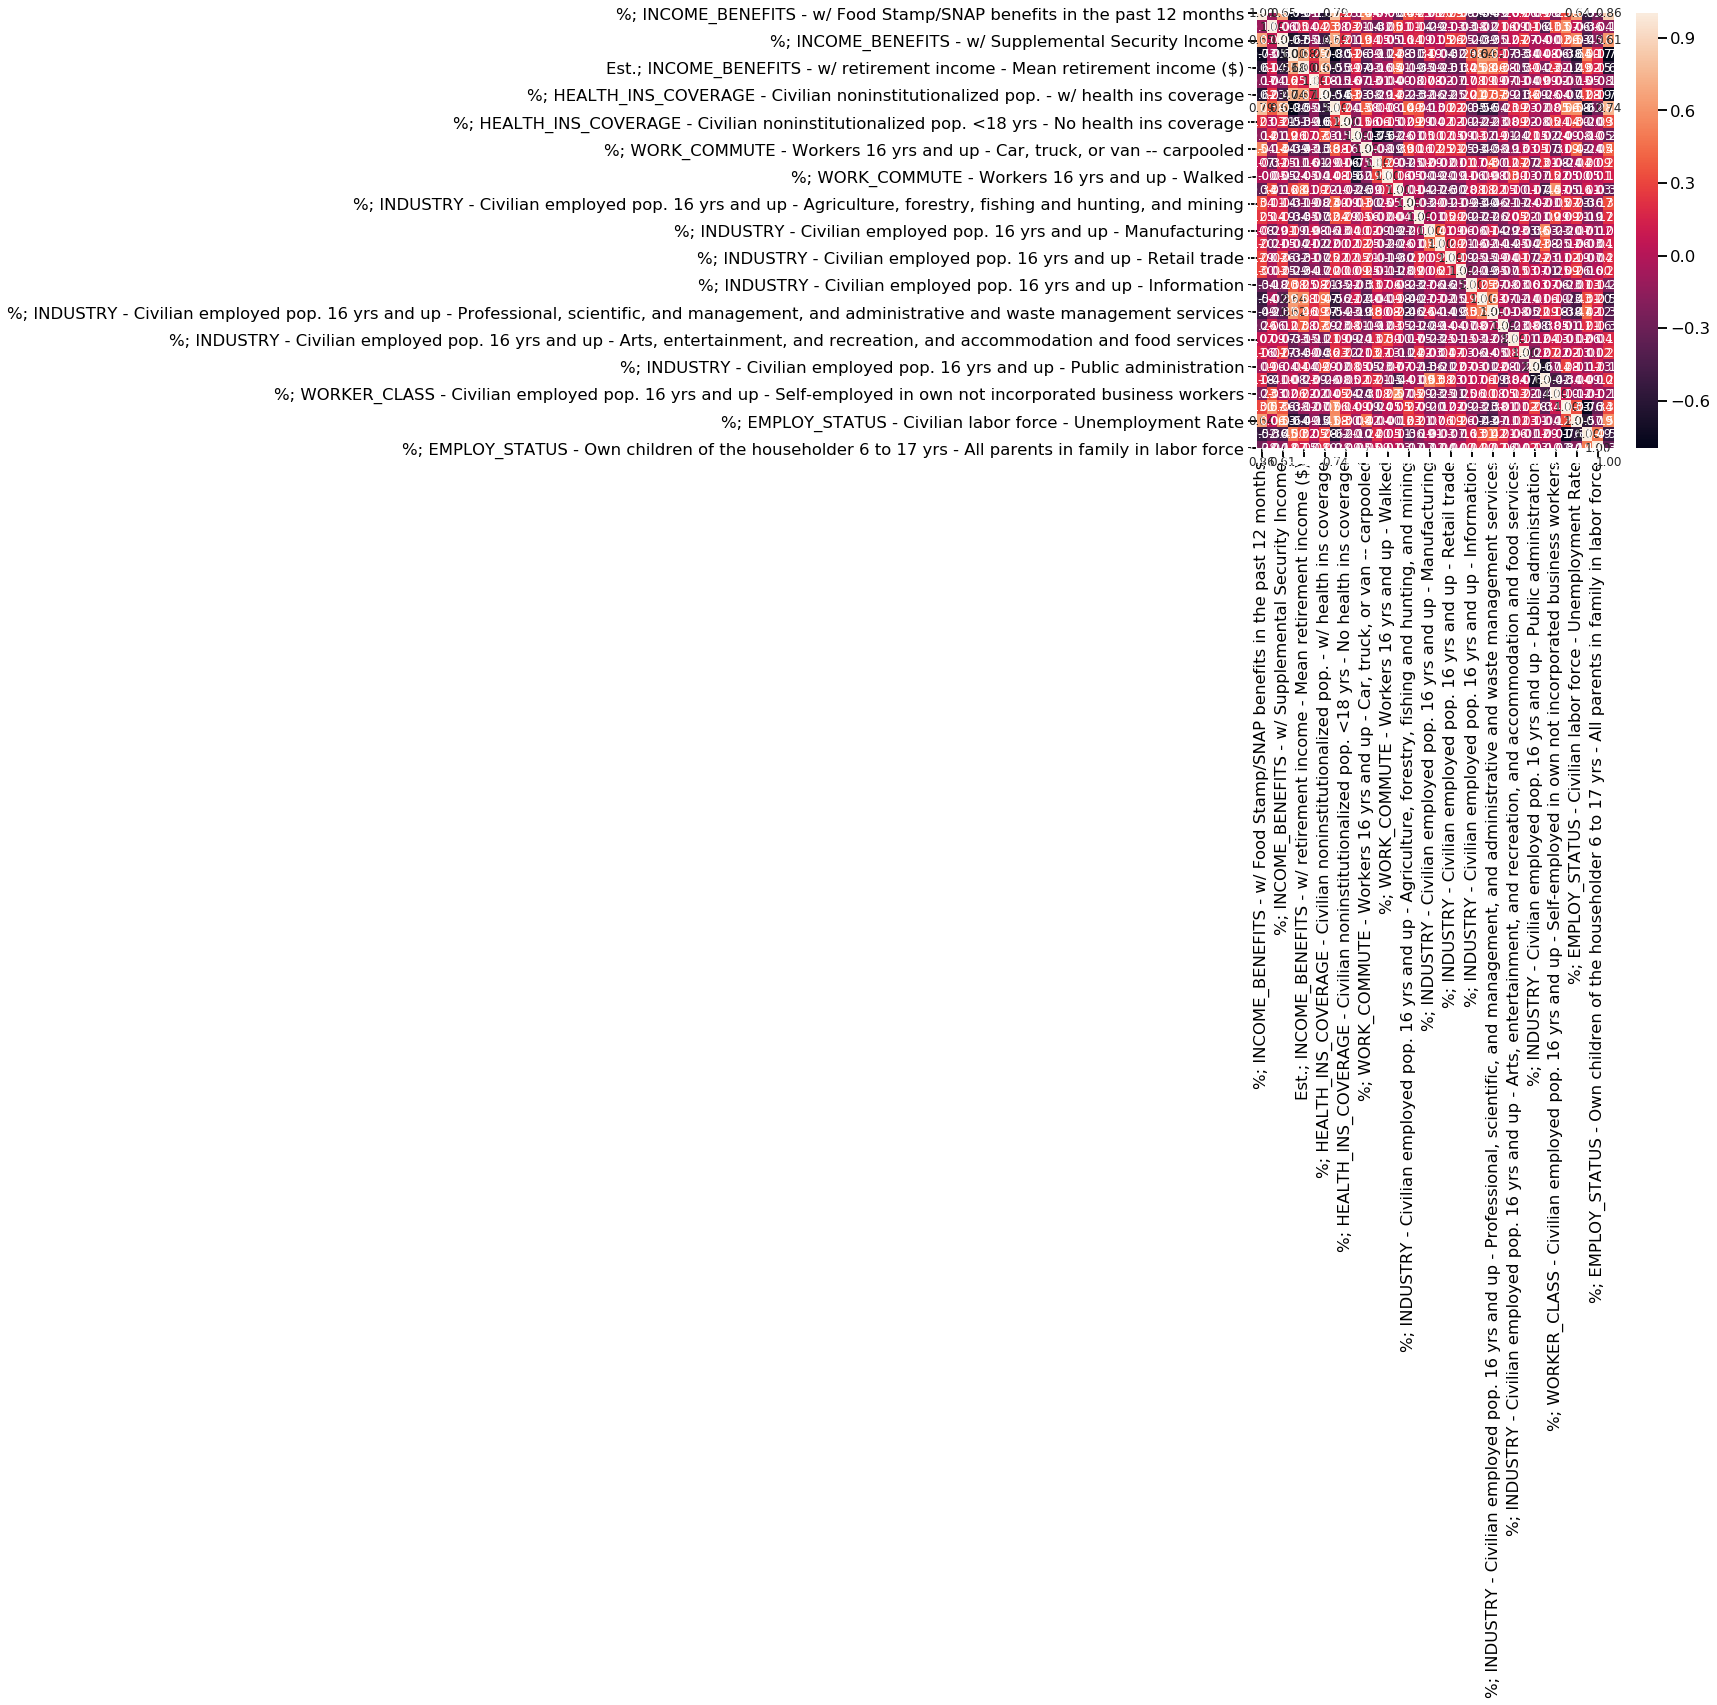

<IPython.core.display.Javascript object>

In [412]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    df_state_info_gs_census[census_col_final].corr(method="pearson"),
    annot=True,
    fmt="0.2f",
)

In [470]:
df_state_info_gs_census[census_col_final].corr(method="pearson")

%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefit...                                           1.000000                        
%; INCOME_BENEFITS - w/ Social Security                                                     -0.099427                        
%; INCOME_BENEFITS - w/ Supplemental Security I...                                           0.653882                        
Est.; INCOME_BENEFITS - Total households - Medi...                                          -0.729109                        
Est.; INCOME_BENEFITS - w/ retirement income - ...                                          -0.614616                        
Est.; INCOME_BENEFITS - w/ cash public assistan...                                          -0.167118                        
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                          -0.619386                        
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           0.785270                        
%; HEALTH_INS_COVERAGE - Civilian noninstitutio...                                           0.234384                        
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                          -0.144824                        
%; WORK_COMMUTE - Workers 16 yrs and up - Car, ...                                           0.542275                        
%; WORK_COMMUTE - Workers 16 yrs and up - Publi...                                           0.067329                        
%; WORK_COMMUTE - Workers 16 yrs and up - Walked                                            -0.004341                        
%; WORK_COMMUTE - Workers 16 yrs and up - Worke...                                          -0.343786                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.338377                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.246800                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.078687                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.204452                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.288541                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.297420                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.339406                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.542654                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.491081                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.256482                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.069423                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                           0.163684                        
%; INDUSTRY - Civilian employed pop. 16 yrs and...                                          -0.090993                        
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                           0.176016                        
%; WORKER_CLASS - Civilian employed pop. 16 yrs...                                          -0.234750                        
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in ...                                           0.304361                        
%; EMPLOY_STATUS - Civilian labor force - Unemp...                                           0.641352                        
%; EMPLOY_STATUS - F

<IPython.core.display.Javascript object>

In [413]:
print("No. of census features ", len(census_col_final))

No. of census features  34


<IPython.core.display.Javascript object>

In [414]:
df_state_info_gs_census[census_col_final[0:2]].corr(method="pearson")

%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefit...                                           1.000000                        
%; INCOME_BENEFITS - w/ Social Security                                                     -0.099427                        

                                                    %; INCOME_BENEFITS - w/ Social Security  
%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefit...                                -0.099427  
%; INCOME_BENEFITS - w/ Social Security                                            1.000000

<IPython.core.display.Javascript object>

In [415]:
def melt_corr_df(df_corr):
    df = df_corr.where(np.triu(np.ones(df_corr.shape)).astype(np.bool))
    df = df.stack().reset_index()
    df.columns = ["Row", "Column", "Pearson r"]

    # Remove self-correlated Pearson r
    df = df[df["Pearson r"] != 1].copy()

    return df

<IPython.core.display.Javascript object>

In [419]:
df_corr_melted_census = melt_corr_df(
    df_state_info_gs_census[census_col_final].corr(method="pearson")
)

<IPython.core.display.Javascript object>

In [420]:
df_corr_melted_census.sort_values(by="Pearson r", ascending=False).head(10)

Row  \
33   %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
7    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
243  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
102  Est.; INCOME_BENEFITS - Total households - Med...   
72   %; INCOME_BENEFITS - w/ Supplemental Security ...   
100  Est.; INCOME_BENEFITS - Total households - Med...   
132  Est.; INCOME_BENEFITS - w/ retirement income -...   
2    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
30   %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
117  Est.; INCOME_BENEFITS - Total households - Med...   

                                                Column  Pearson r  
33   %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All f...   0.863977  
7    %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.785270  
243  %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All f...   0.741289  
102  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.740037  
72   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.692272  
100  Est.; INCOME_BENEFITS - w/ retirement income -...   0.678153  
132  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.669048  
2    %; INCOME_BENEFITS - w/ Supplemental Security ...   0.653882  
30   %; EMPLOY_STATUS - Civilian labor force - Unem...   0.641352  
117  %; INDUSTRY - Civilian employed pop. 16 yrs an...   0.636850

<IPython.core.display.Javascript object>

In [418]:
[
    print(i)
    for i in df_corr_melted.sort_values(by="Pearson r", ascending=False)
    .head(10)
    .loc[:, "Column"]
]

NameError: name 'df_corr_melted' is not defined

<IPython.core.display.Javascript object>

In [421]:
df_corr_melted_census.sort_values(by="Pearson r", ascending=False).tail(10)

Row  \
159  Est.; INCOME_BENEFITS - w/ retirement income -...   
126  Est.; INCOME_BENEFITS - Total households - Med...   
68   %; INCOME_BENEFITS - w/ Supplemental Security ...   
560  %; INDUSTRY - Civilian employed pop. 16 yrs an...   
216  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
3    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
272  %; WORK_COMMUTE - Workers 16 yrs and up - Car,...   
582  %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...   
129  Est.; INCOME_BENEFITS - Total households - Med...   
103  Est.; INCOME_BENEFITS - Total households - Med...   

                                                Column  Pearson r  
159  %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All f...  -0.632089  
126  %; EMPLOY_STATUS - Civilian labor force - Unem...  -0.637943  
68   Est.; INCOME_BENEFITS - Total households - Med...  -0.668726  
560  %; WORKER_CLASS - Civilian employed pop. 16 yr...  -0.674441  
216  %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All f...  -0.728354  
3    Est.; INCOME_BENEFITS - Total households - Med...  -0.729109  
272  %; WORK_COMMUTE - Workers 16 yrs and up - Publ...  -0.748350  
582  %; EMPLOY_STATUS - Females 16 yrs and up - In ...  -0.763717  
129  %; %-AGE_FAMILIES_INCOME_BELOW_POVERTY - All f...  -0.778418  
103  %; HEALTH_INS_COVERAGE - Civilian noninstituti...  -0.796097

<IPython.core.display.Javascript object>

In [422]:
# I'll drop the poverty line element since it correlates with % of families with food stamps and it's not actionable
census_col_final_filt = (
    col_census_pct_ib_final
    + col_census_est_ib_final
    + col_census_pct_hi_final
    + col_census_pct_wc_final
    + col_census_pct_industry_final
    + col_census_pct_workerclass_final
    + col_census_pct_employstatus_final
)

<IPython.core.display.Javascript object>

In [423]:
len(census_col_final_filt)

33

<IPython.core.display.Javascript object>

### Update features - focus on actionable features

4/4/20: added enrollment (school size)

In [424]:
all_features_filt_wcensuscheck = census_col_final_filt + [
    "enrollment",
    "pct_LI_students",
    "Magnet_cat_encoded",
    "Charter_cat_encoded",
    "college_readiness",
    "students_per_teacher",
    "students_per_counselor",
    "pct_teachers_3years_or_more",
    "pct_teachers_who_r_certified",
    "avg_teacher_salary",
    "test_score_rating_LIstudents",
    "test_score_rating_notLIstudents",
    "test_scores_english_LIstudents",
    "test_scores_math_LIstudents",
    "test_scores_math_LIstudents_n_students",
    "graduation_rates_gradRates_eligibility_allStudents",
    "graduation_rates_gradRates_eligibility_LIstudents",
    "graduation_rates_UCCSU_eligibility_allStudents",
    "graduation_rates_UCCSU_eligibility_LIstudents",
]

<IPython.core.display.Javascript object>

In [425]:
len(all_features_filt_wcensuscheck)

52

<IPython.core.display.Javascript object>

In [426]:
df_state_info_gs_census_corr = melt_corr_df(
    df_state_info_gs_census[all_features_filt_wcensuscheck].corr(method="pearson")
)

<IPython.core.display.Javascript object>

In [427]:
df_state_info_gs_census_corr.sort_values(by="Pearson r", ascending=False).head(20)

Row  \
1334                       test_score_rating_LIstudents   
1369  graduation_rates_gradRates_eligibility_allStud...   
1376     graduation_rates_UCCSU_eligibility_allStudents   
7     %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
1351                     test_scores_english_LIstudents   
156   Est.; INCOME_BENEFITS - Total households - Med...   
108   %; INCOME_BENEFITS - w/ Supplemental Security ...   
154   Est.; INCOME_BENEFITS - Total households - Med...   
1202                                         enrollment   
204   Est.; INCOME_BENEFITS - w/ retirement income -...   
34    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
2     %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
30    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
171   Est.; INCOME_BENEFITS - Total households - Med...   
370   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
172   Est.; INCOME_BENEFITS - Total households - Med...   
1267                                  college_readiness   
187   Est.; INCOME_BENEFITS - Total households - Med...   
328   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
366   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   

                                                 Column  Pearson r  
1334                    test_score_rating_notLIstudents   0.985217  
1369  graduation_rates_gradRates_eligibility_LIstudents   0.984875  
1376      graduation_rates_UCCSU_eligibility_LIstudents   0.926377  
7     %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.785270  
1351                        test_scores_math_LIstudents   0.763117  
156   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.740037  
108   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.692272  
154   Est.; INCOME_BENEFITS - w/ retirement income -...   0.678153  
1202             test_scores_math_LIstudents_n_students   0.674502  
204   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.669048  
34                                      pct_LI_students   0.663581  
2     %; INCOME_BENEFITS - w/ Supplemental Security ...   0.653882  
30    %; EMPLOY_STATUS - Civilian labor force - Unem...   0.641352  
171   %; INDUSTRY - Civilian employed pop. 16 yrs an...   0.636850  
370                                     pct_LI_students   0.626857  
172   %; INDUSTRY - Civilian employed pop. 16 yrs an...   0.621783  
1267                        test_scores_math_LIstudents   0.619354  
187                                   college_readiness   0.592663  
328                                   college_readiness   0.581785  
366   %; EMPLOY_STATUS - Civilian labor force - Unem...   0.578243

<IPython.core.display.Javascript object>

In [428]:
df_state_info_gs_census_corr.sort_values(by="Pearson r", ascending=False).tail(20)

Row  \
357   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
1126  %; EMPLOY_STATUS - Civilian labor force - Unem...   
37    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
299   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
4     %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
6     %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
367   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
435   %; WORK_COMMUTE - Workers 16 yrs and up - Car,...   
232   Est.; INCOME_BENEFITS - w/ retirement income -...   
180   Est.; INCOME_BENEFITS - Total households - Med...   
1217                                    pct_LI_students   
104   %; INCOME_BENEFITS - w/ Supplemental Security ...   
1028  %; INDUSTRY - Civilian employed pop. 16 yrs an...   
184   Est.; INCOME_BENEFITS - Total households - Med...   
3     %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
325   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
434   %; WORK_COMMUTE - Workers 16 yrs and up - Car,...   
1104  %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...   
157   Est.; INCOME_BENEFITS - Total households - Med...   
1210                                    pct_LI_students   

                                                 Column  Pearson r  
357   %; INDUSTRY - Civilian employed pop. 16 yrs an...  -0.560158  
1126  %; EMPLOY_STATUS - Females 16 yrs and up - In ...  -0.570974  
37                                    college_readiness  -0.585722  
299   %; HEALTH_INS_COVERAGE - Civilian noninstituti...  -0.609231  
4     Est.; INCOME_BENEFITS - w/ retirement income -...  -0.614616  
6     %; HEALTH_INS_COVERAGE - Civilian noninstituti...  -0.619386  
367   %; EMPLOY_STATUS - Females 16 yrs and up - In ...  -0.620097  
435    %; WORK_COMMUTE - Workers 16 yrs and up - Walked  -0.621511  
232                                     pct_LI_students  -0.621814  
180   %; EMPLOY_STATUS - Civilian labor force - Unem...  -0.637943  
1217                    test_score_rating_notLIstudents  -0.652173  
104   Est.; INCOME_BENEFITS - Total households - Med...  -0.668726  
1028  %; WORKER_CLASS - Civilian employed pop. 16 yr...  -0.674441  
184                                     pct_LI_students  -0.717426  
3     Est.; INCOME_BENEFITS - Total households - Med...  -0.729109  
325                                     pct_LI_students  -0.736647  
434   %; WORK_COMMUTE - Workers 16 yrs and up - Publ...  -0.748350  
1104  %; EMPLOY_STATUS - Females 16 yrs and up - In ...  -0.763717  
157   %; HEALTH_INS_COVERAGE - Civilian noninstituti...  -0.796097  
1210                                  college_readiness  -0.820530

<IPython.core.display.Javascript object>

In [429]:
# Look at what correlated best with the target

bool_target = df_state_info_gs_census_corr["Row"].str.contains(
    "graduation_rates_UCCSU_eligibility_LIstudents"
) | df_state_info_gs_census_corr["Column"].str.contains(
    "graduation_rates_UCCSU_eligibility_LIstudents"
)

df_state_info_gs_census_corr_target = (
    df_state_info_gs_census_corr.loc[bool_target, :]
    .sort_values(by="Pearson r", ascending=False)
    .copy()
)

<IPython.core.display.Javascript object>

In [430]:
df_state_info_gs_census_corr_target

Row  \
1376     graduation_rates_UCCSU_eligibility_allStudents   
1257                                Charter_cat_encoded   
557   %; WORK_COMMUTE - Workers 16 yrs and up - Publ...   
1356                     test_scores_english_LIstudents   
1362                        test_scores_math_LIstudents   
942   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
881   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1077  %; WORKER_CLASS - Civilian employed pop. 16 yr...   
1167  %; EMPLOY_STATUS - Females 16 yrs and up - In ...   
747   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1341                       test_score_rating_LIstudents   
1026  %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1374  graduation_rates_gradRates_eligibility_LIstudents   
1224                                    pct_LI_students   
999   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
912   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
782   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1272                                  college_readiness   
1187  %; EMPLOY_STATUS - Own children of the househo...   
1371  graduation_rates_gradRates_eligibility_allStud...   
597    %; WORK_COMMUTE - Workers 16 yrs and up - Walked   
1349                    test_score_rating_notLIstudents   
1241                                 Magnet_cat_encoded   
201   Est.; INCOME_BENEFITS - Total households - Med...   
296   Est.; INCOME_BENEFITS - w/ cash public assista...   
1101  %; WORKER_CLASS - Civilian employed pop. 16 yr...   
1286                               students_per_teacher   
636   %; WORK_COMMUTE - Workers 16 yrs and up - Work...   
249   Est.; INCOME_BENEFITS - w/ retirement income -...   
152   %; INCOME_BENEFITS - w/ Supplemental Security ...   
849   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
51    %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefi...   
431   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
971   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
816   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
516   %; WORK_COMMUTE - Workers 16 yrs and up - Car,...   
711   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1332                                 avg_teacher_salary   
1146  %; EMPLOY_STATUS - Civilian labor force - Unem...   
1206                                         enrollment   
1322                       pct_teachers_who_r_certified   
1299                             students_per_counselor   
342   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
1367             test_scores_math_LIstudents_n_students   
387   %; HEALTH_INS_COVERAGE - Civilian noninstituti...   
1311                        pct_teachers_3years_or_more   
674   %; INDUSTRY - Civilian employed pop. 16 yrs an...   
1052  %; INDUSTRY - Civilian employed pop. 16 yrs an...   
474   %; WORK_COMMUTE - Workers 16 yrs and up - Car,...   
1124  %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...   
102             %; INCOME_BENEFITS - w/ Social Security   

                                             Column  Pearson r  
1376  graduation_rates_UCCSU_eligibility_LIstudents   0.926377  
1257  graduation_rates_UCCSU_eligibility_LIstudents   0.488653  
557   graduation_rates_UCCSU_eligibility_LIstudents   0.389259  
1356  graduation_rates_UCCSU_eligibility_LIstudents   0.388377  
1362  graduation_rates_UCCSU_eligibility_LIstudents   0.378830  
942   graduation_rates_UCCSU_eligibility_LIstudents   0.260068  
881   graduation_rates_UCCSU_eligibility_LIstudents   0.248058  
1077  graduation_rates_UCCSU_eligibility_LIstudents   0.227108  
1167  graduation_rates_UCCSU_eligibility_LIstudents   0.191105  
747   graduation_rates_UCCSU_eligibility_LIstudents   0.139005  
1341  graduation_rates_UCCSU_eligibility_LIstudents   0.131787  
1026  graduation_rates_UCCSU_eligibility_LIstudents   0.115975  
1374  graduation_rates_UCCSU_eligibility_LIstudents   0.105101  
1224  graduation_rates_UCCSU_eligibility_LIstudents   0.098925  
999   gr

<IPython.core.display.Javascript object>

## Exploratory data analysis

In [431]:
[print(i) for i in df_state_info_gs_census.columns]

Unnamed: 0
CDSCode
NCESDist
NCESSchool
StatusType
County
District
School
Street
StreetAbr
City
Zip
State
MailStreet
MailStrAbr
MailCity
MailZip
MailState
Phone
Ext
WebSite
OpenDate
ClosedDate
Charter
CharterNum
FundingType
DOC
DOCType
SOC
SOCType
EdOpsCode
EdOpsName
EILCode
EILName
GSoffered
GSserved
Virtual
Magnet
YearRoundYN
FederalDFCDistrictID
Latitude
Longitude
AdmFName1
AdmLName1
AdmEmail1
AdmFName2
AdmLName2
AdmEmail2
AdmFName3
AdmLName3
AdmEmail3
LastUpDate
zip_code
gsId
name
type
gradeRange
enrollment
gsRating
parentRating
city
state
districtId
district
districtNCESId
address
phone
fax
website
ncesId
lat
lon
overviewLink
ratingsLink
reviewsLink
schoolStatsLink
college_readiness
test_scores
advanced_courses
equity_overview
race_ethnicity
low_income
disabilities
students_per_teacher
students_per_counselor
pct_teachers_3years_or_more
pct_teachers_who_r_certified
avg_teacher_salary
test_score_rating_allStudents
test_score_rating_LIstudents
test_score_rating_notLIstudents
test_scor

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<IPython.core.display.Javascript object>

In [432]:
df_state_info_gs_census["enrollment"].quantile([0.1, 0.2, 0.5, 0.75, 1])

0.10     214.0
0.20     435.0
0.50    1409.0
0.75    2100.5
1.00    4794.0
Name: enrollment, dtype: float64

<IPython.core.display.Javascript object>

In [433]:
df_state_info_gs_census["SOCType"].value_counts()

High Schools (Public)                 1146
County Community                         3
Special Education Schools (Public)       2
Continuation High Schools                1
Name: SOCType, dtype: int64

<IPython.core.display.Javascript object>

In [434]:
df_state_info_gs_census.sort_values(by="enrollment")[
    [
        "School",
        "SOCType",
        "pct_LI_students",
        "enrollment",
        "graduation_rates_UCCSU_eligibility_LIstudents",
    ]
].head(50)

School                SOCType  \
475                              Yosemite Park High  High Schools (Public)   
1112                              Cold Springs High  High Schools (Public)   
190                Clear Passage Educational Center  High Schools (Public)   
1111                                South Fork High  High Schools (Public)   
132                    Mattole Triple Junction High  High Schools (Public)   
488                                Whale Gulch High  High Schools (Public)   
489                             Leggett Valley High  High Schools (Public)   
146                       Death Valley High Academy  High Schools (Public)   
462                              Mountain Oaks High  High Schools (Public)   
1013                 Downieville Junior-Senior High  High Schools (Public)   
148                               Owens Valley High  High Schools (Public)   
865                   Life Learning Academy Charter  High Schools (Public)   
506                                 Lee Vining High  High Schools (Public)   
1081                          Southern Trinity High  High Schools (Public)   
636         Moreno Valley Community Learning Center  High Schools (Public)   
1116                                 Don Pedro High  High Schools (Public)   
760                                      Baker High  High Schools (Public)   
145                                   Big Pine High  High Schools (Public)   
122                    Elk Creek Junior-Senior High  High Schools (Public)   
501                            Surprise Valley High  High Schools (Public)   
1065                                Oakdale Charter  High Schools (Public)   
949                             Middle College High  High Schools (Public)   
1115                                     Tioga High  High Schools (Public)   
340   Collegiate Charter High School of Los Angeles  High Schools (Public)   
1016                                Happy Camp High  High Schools (Public)   
185                                    Herlong High  High Schools (Public)   
505                                  Coleville High  High Schools (Public)   
904                                    Shandon High  High Schools (Public)   
184                                    Herlong High  High Schools (Public)   
1015                                  Dunsmuir High  High Schools (Public)   
460                     Sherman Thomas Charter High  High Schools (Public)   
936                              Cuyama Valley High  High Schools (Public)   
1038                     Gateway to College Academy  High Schools (Public)   
25                    Civicorps Corpsmember Academy  High Schools (Public)   
161                                   Maricopa High  High Schools (Public)   
955              B. Roberto Cruz Leadership Academy  High Schools (Public)   
187                                   Westwood High  High Schools (Public)   
1137            The High School at Moorpark College  High Schools (Public)   
487                              Potter Valley High  High Schools (Public)   
1080                                   Hayfork High  High Schools (Public)   
1020                              Butte Valley High  High Schools (Public)   
1079                                   Hayfork High  High Schools (Public)   
608                   Greenville Junior/Senior High  High Schools (Public)   
183                         Big Valley Jr. Sr. High  High Schools (Public)   
481                               Round Valley High  High Schools (Public)   
80             EDUHSD Virtual Academy at Shenandoah  High Schools (Public)   
851                       Warner Junior/Senior High  High Schools (Public)   
124                         Six Rivers Charter High  High Schools (Public)   
915                                  Pescadero High  High Schools (Public)   
121                    Princeton Junior-Senior High  High Schools (Public)   

      pct_LI_students  enrollment  \
475               NaN        

<IPython.core.display.Javascript object>

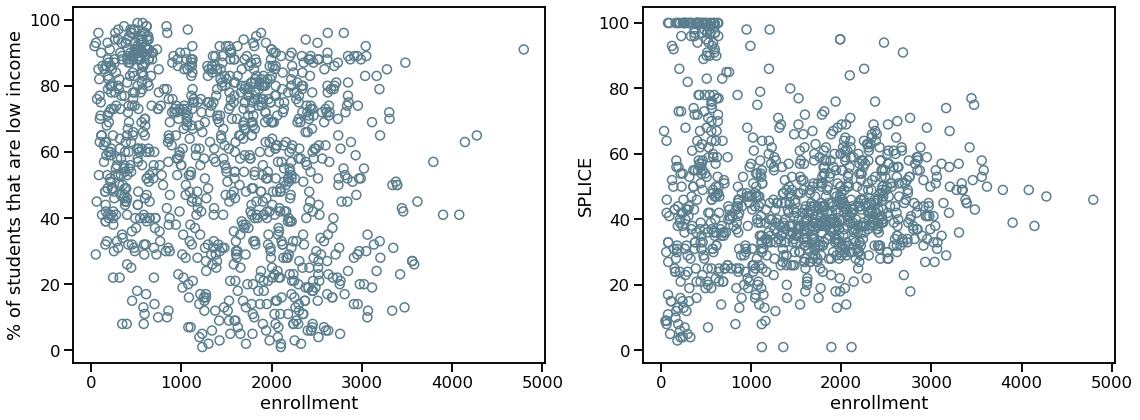

<IPython.core.display.Javascript object>

In [435]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(df_state_info_gs_census, "enrollment", "pct_LI_students", ax1)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "enrollment",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax2,
)

ax1.set_xlabel("enrollment", fontsize=18)
ax1.set_ylabel("% of students that are low income", fontsize=18)
ax2.set_xlabel("enrollment", fontsize=18)
ax2.set_ylabel("SPLICE", fontsize=18)
plt.tight_layout()

### Most correlated features

In [436]:
df_state_info_gs_census[
    "graduation_rates_UCCSU_eligibility_allStudents"
] * df_state_info_gs_census["pct_LI_students"] / 100

0       67.00
1       11.88
2         NaN
3       80.00
4       10.71
        ...  
1147    26.46
1148    26.04
1149    29.48
1150    20.46
1151    19.24
Length: 1152, dtype: float64

<IPython.core.display.Javascript object>

In [437]:
df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]

0       100.0
1        50.0
2       100.0
3       100.0
4        45.0
        ...  
1147     38.0
1148     30.0
1149     72.0
1150     29.0
1151     51.0
Name: graduation_rates_UCCSU_eligibility_LIstudents, Length: 1152, dtype: float64

<IPython.core.display.Javascript object>

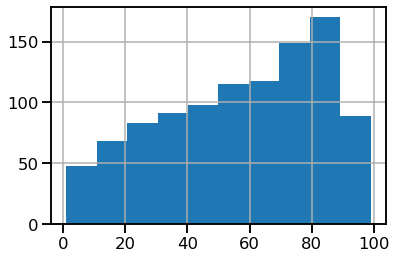

<IPython.core.display.Javascript object>

In [439]:
df_state_info_gs_census["pct_LI_students"].hist()

''

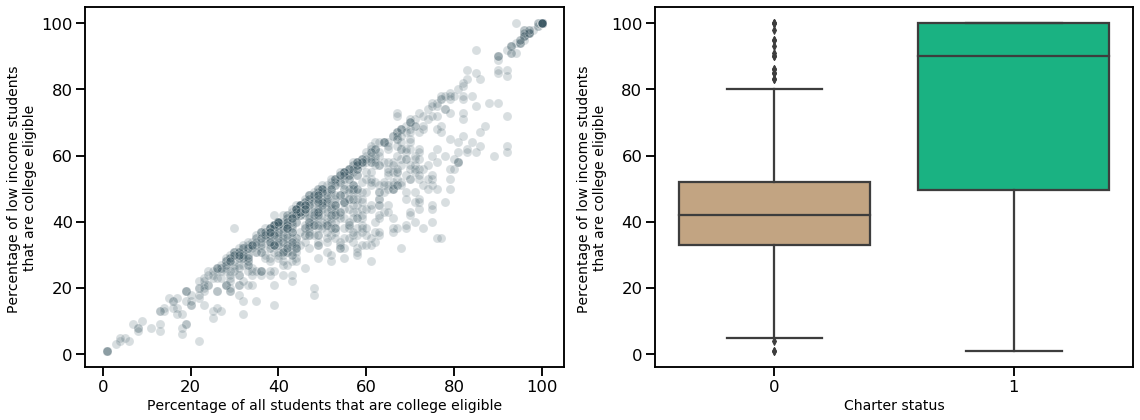

<IPython.core.display.Javascript object>

In [440]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
# scatter_plot_open_circles(
#     df_state_info_gs_census,
#     "graduation_rates_UCCSU_eligibility_allStudents",
#     "graduation_rates_UCCSU_eligibility_LIstudents",
#     ax1,
# )

sns.scatterplot(
    data=df_state_info_gs_census,
    x="graduation_rates_UCCSU_eligibility_allStudents",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    ax=ax1,
    alpha=0.2,
    color=B_slate,
    legend=False,
)
ax1.set_xlabel("Percentage of all students that are college eligible", fontsize=14)
ax1.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)


sns.boxplot(
    data=df_state_info_gs_census,
    x="Charter_cat_encoded",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    palette=[B_beige, B_green],
)
ax2.set_xlabel("Charter status", fontsize=14)
ax2.set_ylabel(
    "Percentage of low income students \nthat are college eligible", fontsize=14
)
plt.tight_layout()
;

In [441]:
df_state_info_gs_census["Charter_cat_encoded"].sum()

208

<IPython.core.display.Javascript object>

### Distribution of target

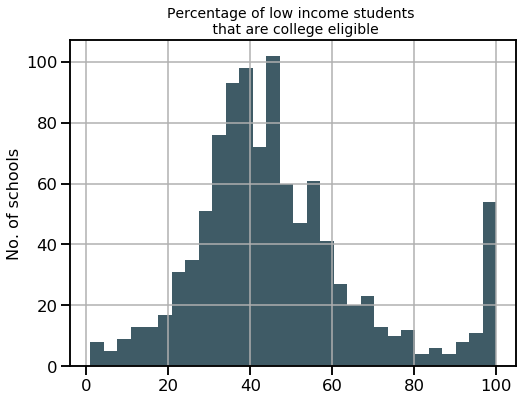

<IPython.core.display.Javascript object>

In [442]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);


mean:  46.7021484375
mean +/- 1SD:  25.971879691038332 67.43241718396166
mean + 2SD:  5.241610944576664 88.16268593042334


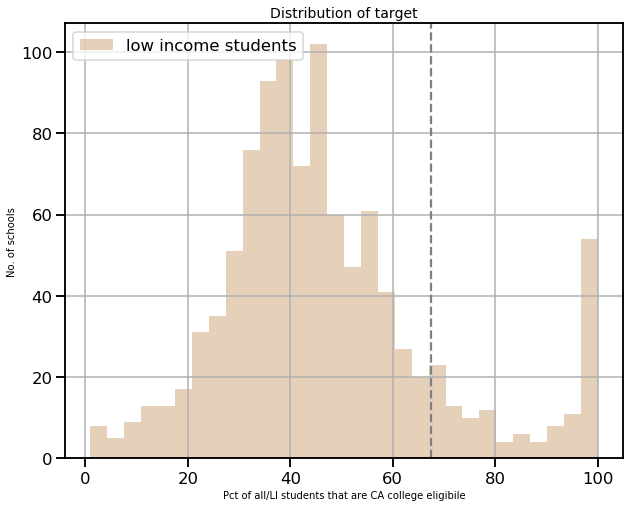

<IPython.core.display.Javascript object>

In [443]:
f, ax1 = plt.subplots(figsize=(10, 8))
df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"].hist(
    bins=30, ax=ax1, color=B_beige, alpha=0.5, label="low income students"
)
# df_state_info_gs_census["graduation_rates_UCCSU_eligibility_allStudents"].hist(
#     bins=30, ax=ax1, color=B_green, alpha=0.5, label="all students"
# )


ax1.axvline(67.4, c="gray", linestyle="dashed")
ax1.set_title("Distribution of target")
ax1.set_xlabel("Pct of all/LI students that are CA college eligibile")
ax1.set_ylabel("No. of schools")
ax1.legend()

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd)
print("mean + 2SD: ", target_mean - 2 * target_sd, target_mean + 2 * target_sd)

## RF regression, target as the percentage of low income students that are college eligble

- Used RF to be allow for possibly correlated features (despite filtering above)
- Splitting on MSE


- Use Gridsearch
- Apply train-test-validation splits

In [446]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

<IPython.core.display.Javascript object>

In [451]:
def get_split_data(X, y, testsize):

    # Keep rows only if there are no null values for that feature and target
    k_rows2keep = pd.merge(X, y, left_index=True, right_index=True).notnull().sum(
        axis=1
    ) == (X.shape[1] + 1)
    print(
        "No. of total schools before splitting (no null values for feature set or target): ",
        sum(k_rows2keep),
    )

    X = X.loc[k_rows2keep, :].copy()
    y = y[k_rows2keep].copy()

    # Split data between train and test_(and_holdout?)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

Is it necessary to run a separate kfold cross-validation?
- oob_scorebool = True (look like this would be like the validation)

In [455]:
all_features_filt_wcensuscheck_notarget = all_features_filt_wcensuscheck[:-2].copy()
target = "graduation_rates_UCCSU_eligibility_LIstudents"

<IPython.core.display.Javascript object>

In [457]:
X_rf = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y_rf = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [458]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = get_split_data(X_rf, y_rf, 0.4)

No. of total schools before splitting (no null values for feature set or target):  825


<IPython.core.display.Javascript object>

**Run a hyperparameter grid search**

See [here](https://scikit-learn.org/stable/modules/grid_search.html)
- try randomized parameter optimization since more values can be tested
- try doing multiple metrics - R2, MSE, etc.
- note: don't have to do pruning because of RF design (see [here](https://stats.stackexchange.com/questions/36298/why-is-pruning-not-needed-for-random-forest-trees))

In [450]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

<IPython.core.display.Javascript object>

**Example to show how to get evaluation metrics**

In [463]:
# Instantiate model - note haven't used oob_scorebool parameter
rf = RandomForestRegressor()

# Rn search using 5-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=5,  # no. of paramter settings sampled
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    refit=False,
    scoring=[
        "r2",
        "neg_root_mean_squared_error",
    ],  # look at multiple evaluation metrics
    return_train_score=True,  # computationally expensive, but output here for insight
)

rf_random.fit(X_train_rf, y_train_rf)

# y_pred = rf.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   32.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

<IPython.core.display.Javascript object>

In [465]:
df_cv_results = pd.DataFrame(rf_random.cv_results_)
df_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.201855      0.009524         0.017208        0.003216   
1       2.464949      0.058422         0.095641        0.008640   
2       8.634557      0.155000         0.130753        0.027033   
3       7.002390      0.162154         0.300850        0.045100   
4      12.333402      1.108649         0.097150        0.023601   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                 50                      10                      2   
1                483                      10                      4   
2                483                       2                      2   
3               1350                       5                      1   
4                916                      10                      1   

  param_max_features param_max_depth param_bootstrap  ...  \
0               sqrt              50            True  ...   
1               sqrt              90           False  ...   
2               auto              60           False  ...   
3               sqrt              30            True  ...   
4               auto              80           False  ...   

  split1_test_neg_root_mean_squared_error  \
0                              -12.958028   
1                              -12.519228   
2                              -17.969204   
3                              -12.835190   
4                              -17.460767   

   split2_test_neg_root_mean_squared_error  \
0                               -12.484583   
1                               -12.120172   
2                               -15.098020   
3                               -12.203817   
4                               -14.433979   

   mean_test_neg_root_mean_squared_error  \
0                             -12.956614   
1                             -12.607428   
2                             -16.490868   
3                             -12.733398   
4                             -16.154508   

   std_test_neg_root_mean_squared_error  \
0                              0.384835   
1                              0.438310   
2                              1.173714   
3                              0.397417   
4                              1.269928   

   rank_test_neg_root_mean_squared_error  \
0                                      3   
1                                      1   
2                                      5   
3                                      2   
4                                      4   

   split0_train_neg_root_mean_squared_error  \
0                                 -7.156356   
1                                 -4.900607   
2                                 -3.039502   
3                                 -5.067640   
4                                 -4.482788   

   split1_train_neg_root_mean_squared_error  \
0                                 -7.932654   
1                                 -5.750714   
2                                 -2.937701   
3                                 -5.615367   
4                                 -4.268203   

   split2_train_neg_root_mean_squared_error  \
0                                 -7.665670   
1                                 -5.365745   
2                                 -3.175054   
3                                 -5.453703   
4                                 -5.640109   

   mean_train_neg_root_mean_squared_error  \
0                               -7.584894   
1                               -5.339022   
2                               -3.050752   
3                               -5.378903   
4                               -4.797033   

   std_train_neg_root_mean_squared_error  
0                               0.322029  
1                               0.347569  
2                               0.097225  
3                               0.229779  
4                               0.602547  

[5 rows x 33 columns]

<IPython.core.display.Javascript object>

**Running to get real results**

In [468]:
# Instantiate model - note haven't used oob_scorebool parameter
rf = RandomForestRegressor()

# Rn search using 5-fold cross-validation
rf_random = RandomizedSearchCV(
    estimator=rf,  # the model
    param_distributions=random_grid,  # from above
    n_iter=100,  # no. of paramter settings sampled
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

rf_random.fit(X_train_rf, y_train_rf)

# y_pred = rf.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.0min


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [ ]:
rf_random.best_params_

This takes a while

In [656]:
def run_randomforest_v0(X_train, y_train, X_test, y_test):
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators=100, random_state=19, )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    df_eval = pd.DataFrame({"test": y_test, "pred": y_pred})

    return rf, df_eval

<IPython.core.display.Javascript object>

In [891]:
X_train_rf.shape

(495, 49)

<IPython.core.display.Javascript object>

In [660]:
rf_v0, df_eval_v0 = run_randomforest_v0(X_train_rf, y_train_rf, X_test_rf, y_test_rf)

<IPython.core.display.Javascript object>

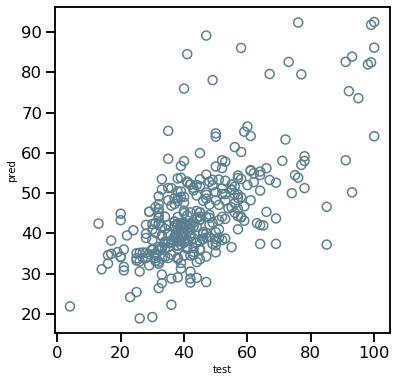

<IPython.core.display.Javascript object>

In [661]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v0, "test", "pred", ax1)

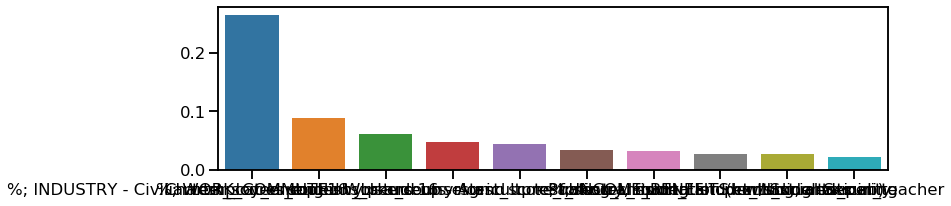

<IPython.core.display.Javascript object>

In [662]:
# Show most important features
features = X_train_rf.columns.tolist()
feature_imp = pd.Series(rf_v0.feature_importances_, index=features).sort_values(ascending=False)

# Creating a bar plot
plt.figure(figsize=(12,3))
ax = sns.barplot(y=feature_imp[0:10], x=feature_imp.index[0:10])
ax.xtick_labels


In [663]:
# Top 10
feature_imp[0:10]

Charter_cat_encoded                                                                                            0.264666
test_scores_english_LIstudents                                                                                 0.089539
students_per_counselor                                                                                         0.060808
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining    0.048641
%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)                            0.043851
test_score_rating_LIstudents                                                                                   0.034672
test_scores_math_LIstudents                                                                                    0.032194
%; INCOME_BENEFITS - w/ Social Security                                                                        0.027822
pct_LI_students                         

<IPython.core.display.Javascript object>

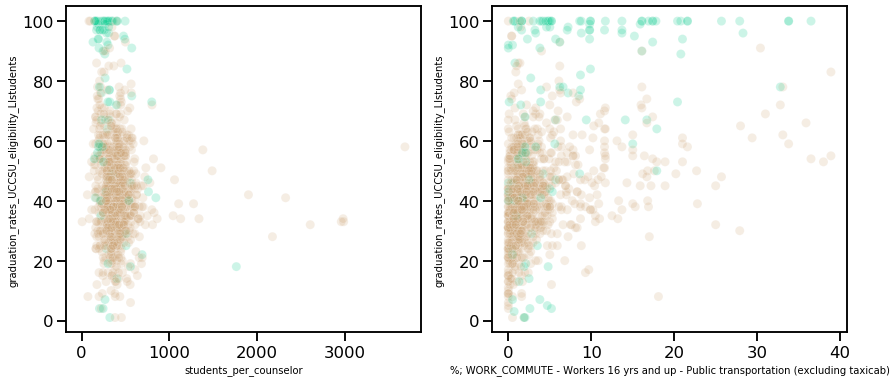

<IPython.core.display.Javascript object>

In [670]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="students_per_counselor",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

sns.scatterplot(
    data=df_state_info_gs_census,
    x="%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax2,
    alpha=0.2,
    legend=False,
)

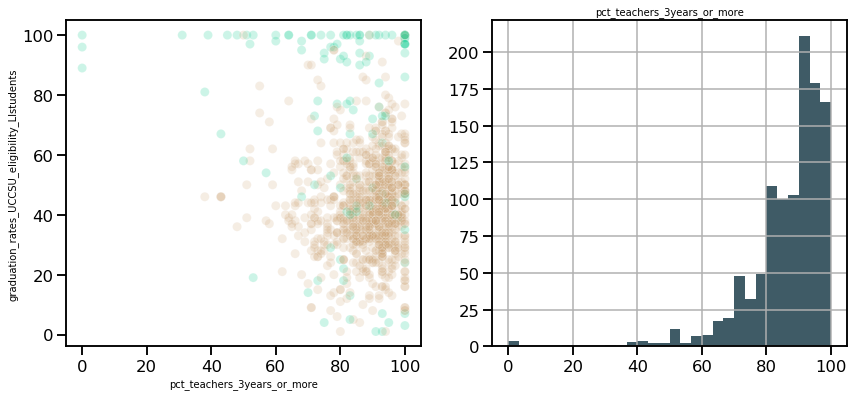

<IPython.core.display.Javascript object>

In [676]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="pct_teachers_3years_or_more",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

hist_plot(df_state_info_gs_census, "pct_teachers_3years_or_more", ax=ax2)

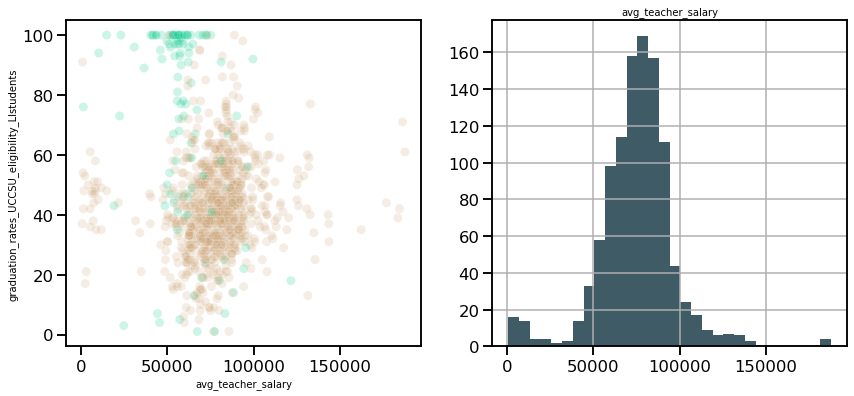

<IPython.core.display.Javascript object>

In [680]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="avg_teacher_salary",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

hist_plot(df_state_info_gs_census, "avg_teacher_salary", ax=ax2)

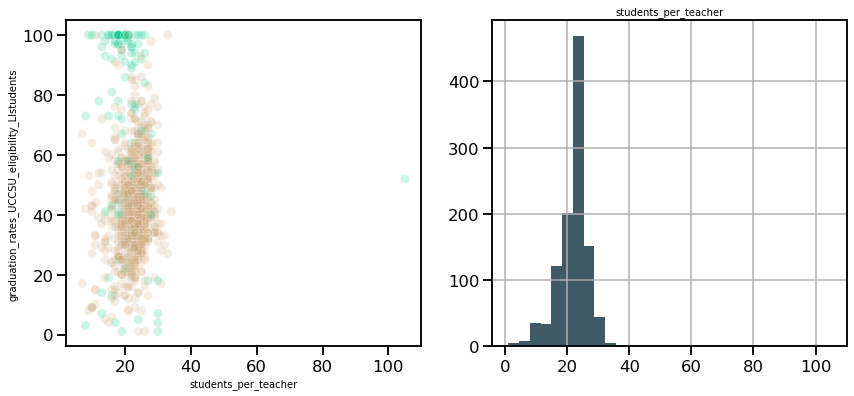

<IPython.core.display.Javascript object>

In [681]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(
    data=df_state_info_gs_census,
    x="students_per_teacher",
    y="graduation_rates_UCCSU_eligibility_LIstudents",
    hue="Charter_cat_encoded",
    palette=[B_beige, B_green],
    ax=ax1,
    alpha=0.2,
    legend=False,
)

hist_plot(df_state_info_gs_census, "students_per_teacher", ax=ax2)

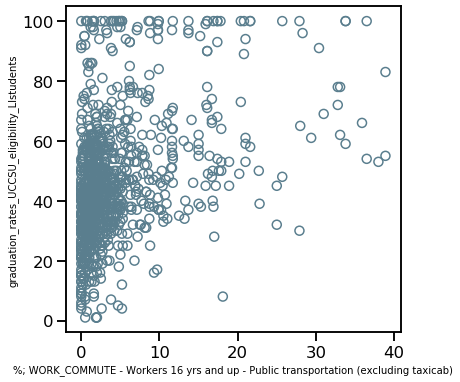

<IPython.core.display.Javascript object>

In [666]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax1,
)

In [667]:
print("R2 score: ", rf_v0.score(X_test_rf, y_test_rf))

R2 score:  0.43454237447381516


<IPython.core.display.Javascript object>

## RF regression, target as difference between percent low income and percent of all students college eligible

In [685]:
df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_LI_all_diff"] = df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_LIstudents"] - df_state_info_gs_census.loc[:, "graduation_rates_UCCSU_eligibility_allStudents"]


<IPython.core.display.Javascript object>

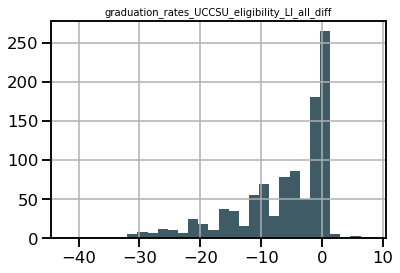

<IPython.core.display.Javascript object>

In [687]:
f, ax1 = plt.subplots()
hist_plot(
    df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LI_all_diff", ax1
)

In [694]:
target = "graduation_rates_UCCSU_eligibility_LI_all_diff"

<IPython.core.display.Javascript object>

In [695]:
X_rf_v1 = df_state_info_gs_census[all_features_filt_wcensuscheck_notarget].copy()
y_rf_v1 = df_state_info_gs_census[target].copy()

<IPython.core.display.Javascript object>

In [697]:
X_train_rf_v1, X_test_rf_v1, y_train_rf_v1, y_test_rf_v1 = get_split_data(
    X_rf_v1, y_rf_v1, 0.4
)

No. of total schools before splitting (no null values for feature set or target):  825


<IPython.core.display.Javascript object>

In [698]:
rf_v1, df_eval_v1 = run_randomforest_v0(
    X_train_rf_v1, y_train_rf_v1, X_test_rf_v1, y_test_rf_v1
)

<IPython.core.display.Javascript object>

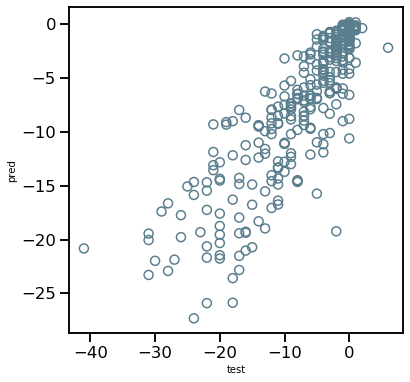

<IPython.core.display.Javascript object>

In [699]:
f, (ax1) = plt.subplots(1, 1, figsize=(6, 6))
scatter_plot_open_circles(df_eval_v1, "test", "pred", ax1)

In [701]:
print("R2 score: ", rf_v1.score(X_test_rf_v1, y_test_rf_v1))

R2 score:  0.7376636998668289


<IPython.core.display.Javascript object>

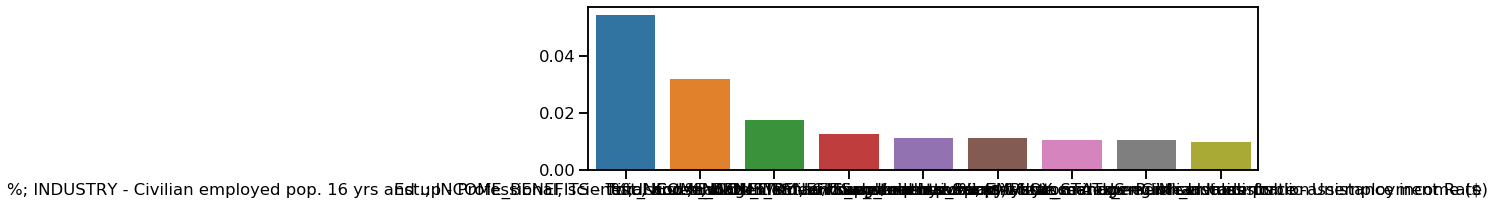

<IPython.core.display.Javascript object>

In [708]:
# Show most important features
features = X_train_rf_v1.columns.tolist()
feature_imp = pd.Series(rf_v1.feature_importances_, index=features).sort_values(
    ascending=False
)

# Creating a bar plot
plt.figure(figsize=(12, 3))
ax = sns.barplot(y=feature_imp[1:10], x=feature_imp.index[1:10])

In [703]:
feature_imp.head(10)

pct_LI_students                                                                                                                                    0.642368
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services    0.054382
Est.; INCOME_BENEFITS - Total households - Median household income ($)                                                                             0.031948
test_scores_math_LIstudents_n_students                                                                                                             0.017409
%; INCOME_BENEFITS - w/ Supplemental Security Income                                                                                               0.012607
avg_teacher_salary                                                                                                                                 0.011402
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public admi

<IPython.core.display.Javascript object>

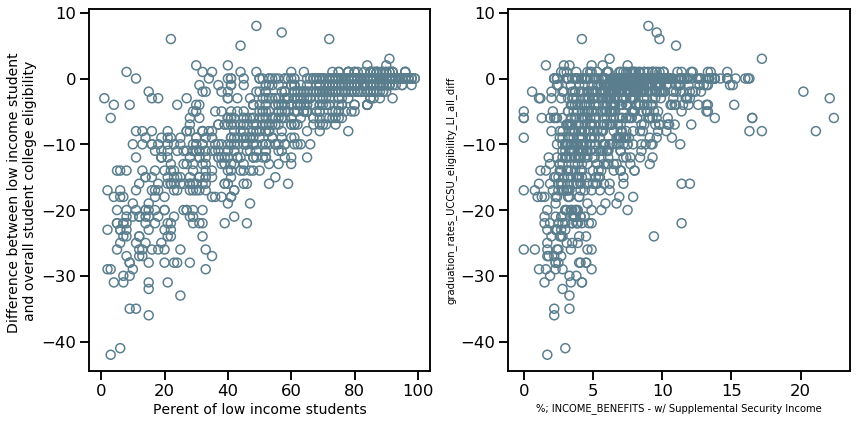

<IPython.core.display.Javascript object>

In [743]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)
ax1.set_xlabel("Perent of low income students", fontsize=14)
ax1.set_ylabel(
    "Difference between low income student \nand overall student college eligibility",
    fontsize=14,
)


scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; INCOME_BENEFITS - w/ Supplemental Security Income",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

plt.tight_layout()

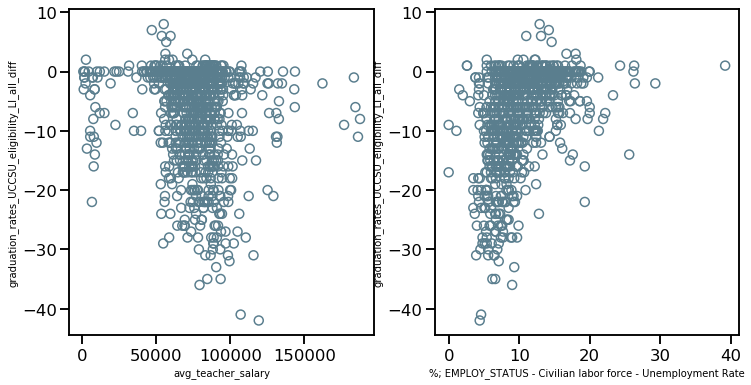

<IPython.core.display.Javascript object>

In [710]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "avg_teacher_salary",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; EMPLOY_STATUS - Civilian labor force - Unemployment Rate",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

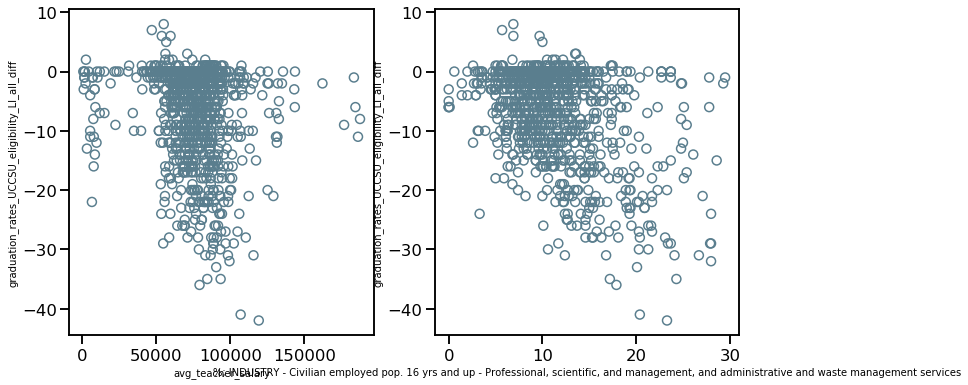

<IPython.core.display.Javascript object>

In [723]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "avg_teacher_salary",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)

scatter_plot_open_circles(
    df_state_info_gs_census,
    "%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax2,
)

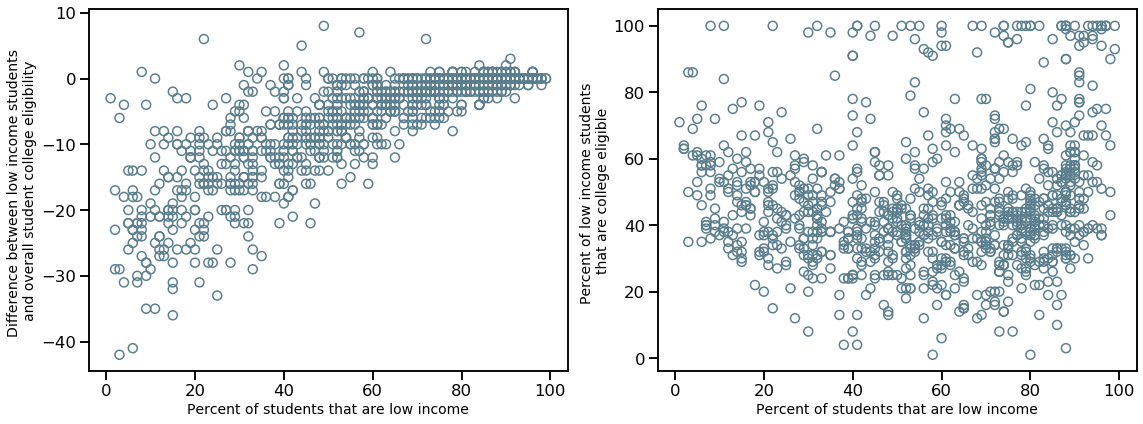

<IPython.core.display.Javascript object>

In [899]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LI_all_diff",
    ax1,
)
ax1.set_xlabel("Percent of students that are low income", fontsize=14)
ax1.set_ylabel(
    "Difference between low income students \nand overall student college eligibility",
    fontsize=14,
)


scatter_plot_open_circles(
    df_state_info_gs_census,
    "pct_LI_students",
    "graduation_rates_UCCSU_eligibility_LIstudents",
    ax2,
)

ax2.set_xlabel("Percent of students that are low income", fontsize=14)
ax2.set_ylabel(
    "Percent of low income students \nthat are college eligible", fontsize=14,
)
plt.tight_layout()

In [721]:
df_state_info_gs_census.sort_values(
    by="graduation_rates_UCCSU_eligibility_LI_all_diff", ascending=False
).loc[
    :,
    ["School", "City"]
    + all_features_filt_wcensuscheck_notarget
    + ["graduation_rates_UCCSU_eligibility_LIstudents", target],
].head(
    10
)

School             City  \
1009                      Fall River Junior-Senior High         McArthur   
482                            Redwood Academy of Ukiah            Ukiah   
174                         Lemoore Middle College High          Lemoore   
685                                 New Technology High       Sacramento   
1149            Marysville Charter Academy for the Arts       Marysville   
1015                                      Dunsmuir High         Dunsmuir   
654                            NOVA Academy - Coachella        Coachella   
850                         High Tech High North County       San Marcos   
377   Humanities and Arts (HARTS) Academy of Los Ang...      Harbor City   
307   Linda Esperanza Marquez High A Huntington Park...  Huntington Park   

      %; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
1009                                                2.5                        
482                                                14.0                        
174                                                11.1                        
685                                                16.5                        
1149                                               19.9                        
1015                                               13.2                        
654                                                23.0                        
850                                                 2.6                        
377                                                10.3                        
307                                                19.8                        

      %; INCOME_BENEFITS - w/ Social Security  \
1009                                     42.3   
482                                      33.8   
174                                      18.4   
685                                      32.4   
1149                                     31.2   
1015                                     48.3   
654                                      15.1   
850                                      31.8   
377                                      29.7   
307                                      23.4   

      %; INCOME_BENEFITS - w/ Supplemental Security Income  \
1009                                                9.0      
482                                                 9.6      
174                                                 4.2      
685                                                 9.8      
1149                                               11.0      
1015                                               17.2      
654                                                 6.2      
850                                                 2.9      
377                                                 4.9      
307                                                 7.5      

      Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
1009                                                NaN                        
482                                             44596.0                        
174                                             48953.0                        
685                                             45801.0                        
1149                                            44852.0                        
1015                                            28241.0                        
654                                             37969.0                        
850                                             59778.0                        
377                                             52294.0                        
307                                             35917.0                        

      Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
1009                                                NaN                           
482                                             30849.0      

<IPython.core.display.Javascript object>

## Statistical analysis, evaluate top and bottom performing schools

In [782]:
def run_mannwhitneyu(df, metric_col, bin_col):
    class0 = sorted(df[bin_col].unique())[0]
    class1 = sorted(df[bin_col].unique())[1]
    x = df.loc[df[bin_col] == class0, metric_col]
    y = df.loc[df[bin_col] == class1, metric_col]
    mwu_statistic, mwu_pval = mannwhitneyu(x, y, use_continuity=True, alternative=None)
    return mwu_pval

<IPython.core.display.Javascript object>

mean:  46.7021484375
mean +/- 1SD:  25.971879691038332 67.43241718396166


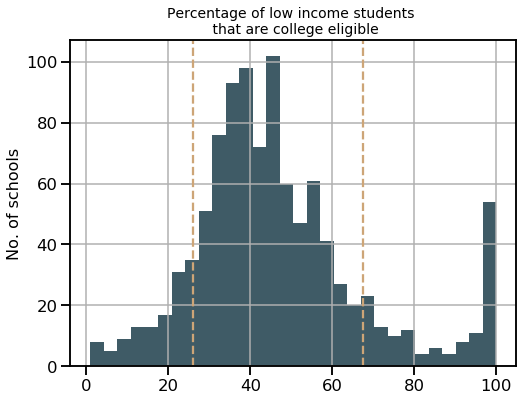

<IPython.core.display.Javascript object>

In [753]:
f, ax1 = plt.subplots(figsize=(8,6))
hist_plot(df_state_info_gs_census, "graduation_rates_UCCSU_eligibility_LIstudents", ax1)
ax1.set_ylabel("No. of schools", fontsize=16)
ax1.set_title("Percentage of low income students \n that are college eligible", fontsize=14);

target = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
target_mean = target.mean()
target_sd = target.std()

# or top and bottom quantile

ax1.axvline(target_mean-target_sd, c=B_beige, linestyle="dashed")
ax1.axvline(target_mean+target_sd, c=B_beige, linestyle="dashed")

print("mean: ", target_mean)
print("mean +/- 1SD: ", target_mean - target_sd, target_mean + target_sd);


In [760]:
print(
    "No. of low performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        < target_mean - target_sd
    ).sum(),
)

print(
    "No. of high performing schools: ",
    (
        df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"]
        > target_mean + target_sd
    ).sum(),
)

No. of low performing schools:  111
No. of high performing schools:  137


<IPython.core.display.Javascript object>

In [764]:
df_state_info_gs_census["LI_performance_status"] = "middle"

bool_low = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] < (
    target_mean - target_sd
)
df_state_info_gs_census.loc[bool_low, "LI_performance_status"] = "low"

bool_high = df_state_info_gs_census["graduation_rates_UCCSU_eligibility_LIstudents"] > (
    target_mean + target_sd
)
df_state_info_gs_census.loc[bool_high, "LI_performance_status"] = "high"

df_state_info_gs_census["LI_performance_status"].value_counts()

middle    904
high      137
low       111
Name: LI_performance_status, dtype: int64

<IPython.core.display.Javascript object>

In [771]:
feat_for_mw = all_features_filt_wcensuscheck[:-4]
feat_for_mw

['%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months',
 '%; INCOME_BENEFITS - w/ Social Security',
 '%; INCOME_BENEFITS - w/ Supplemental Security Income',
 'Est.; INCOME_BENEFITS - Total households - Median household income ($)',
 'Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)',
 'Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage',
 '%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs - No health ins coverage',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- carpooled',
 '%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)',
 '%; WORK_COMMUTE - Workers

<IPython.core.display.Javascript object>

In [774]:
status2keep = ["low", "high"]

df_state_info_gs_census_forMW = df_state_info_gs_census.loc[
    df_state_info_gs_census["LI_performance_status"].isin(status2keep),
    feat_for_mw + ["LI_performance_status"],
].copy()

<IPython.core.display.Javascript object>

In [775]:
df_state_info_gs_census_forMW.head()

%; INCOME_BENEFITS - w/ Food Stamp/SNAP benefits in the past 12 months  \
0                                                 9.2                        
2                                                28.4                        
3                                                28.4                        
13                                                9.9                        
19                                                4.5                        

    %; INCOME_BENEFITS - w/ Social Security  \
0                                      24.0   
2                                      20.0   
3                                      20.0   
13                                     29.0   
19                                     25.8   

    %; INCOME_BENEFITS - w/ Supplemental Security Income  \
0                                                16.0      
2                                                13.4      
3                                                13.4      
13                                                8.1      
19                                                5.5      

    Est.; INCOME_BENEFITS - Total households - Median household income ($)  \
0                                             32993.0                        
2                                             31903.0                        
3                                             31903.0                        
13                                            76773.0                        
19                                            86757.0                        

    Est.; INCOME_BENEFITS - w/ retirement income - Mean retirement income ($)  \
0                                             29027.0                           
2                                             19269.0                           
3                                             19269.0                           
13                                            20501.0                           
19                                            20687.0                           

    Est.; INCOME_BENEFITS - w/ cash public assistance income - Mean cash public assistance income ($)  \
0                                              5055.0                                                   
2                                              5347.0                                                   
3                                              5347.0                                                   
13                                             4077.0                                                   
19                                             4531.0                                                   

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage  \
0                                                82.2                                      
2                                                80.2                                      
3                                                80.2                                      
13                                               90.3                                      
19                                               90.4                                      

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage  \
0                                                41.3                                                           
2                                                48.5                                                           
3                                                48.5                                                           
13                                               29.4                                                           
19                                               29.6                                                           

    %; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. <18 yrs 

<IPython.core.display.Javascript object>

In [811]:
df_sig_features = pd.DataFrame()
df_sig_features["feature"] = None
df_sig_features["raw_pval"] = None


for i, feature in enumerate(feat_for_mw):
    mwu_pval_feature = run_mannwhitneyu(
        df_state_info_gs_census_forMW, feature, "LI_performance_status"
    )
    if mwu_pval_feature < 0.05:
        df_sig_features.loc[i, "feature"] = feature
        df_sig_features.loc[i, "raw_pval"] = mwu_pval_feature

df_sig_features = df_sig_features.sort_values(
    by="raw_pval", ascending=True
).reset_index()

bonferroni_reject, bonferroni_p_val_corrected = multitest.multipletests(
    df_sig_features["raw_pval"], alpha=0.05, method="bonferroni"
)[0:2]

df_sig_features["corr_p_val_rej"] = bonferroni_reject
df_sig_features["corr_p_val"] = bonferroni_p_val_corrected

<IPython.core.display.Javascript object>

In [831]:
df_sig_features.loc[df_sig_features["corr_p_val_rej"], ["feature", "corr_p_val"]]

feature   corr_p_val
0   %; WORK_COMMUTE - Workers 16 yrs and up - Publ...  5.07987e-19
1   %; INDUSTRY - Civilian employed pop. 16 yrs an...  7.23522e-17
2             %; INCOME_BENEFITS - w/ Social Security  5.22535e-14
3   %; WORKER_CLASS - Civilian employed pop. 16 yr...  1.01559e-13
4                      test_scores_english_LIstudents  4.72221e-13
5                                 Charter_cat_encoded  2.54253e-12
6   %; INDUSTRY - Civilian employed pop. 16 yrs an...  1.23895e-11
7   %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in...  1.76531e-11
8   %; INDUSTRY - Civilian employed pop. 16 yrs an...  4.63625e-11
9   %; INDUSTRY - Civilian employed pop. 16 yrs an...  2.34242e-09
10                        test_scores_math_LIstudents   1.0673e-08
11                       test_score_rating_LIstudents  2.19737e-07
12  %; EMPLOY_STATUS - Females 16 yrs and up - In ...  1.86992e-06
13  %; WORK_COMMUTE - Workers 16 yrs and up - Car,...  4.88815e-06
14  %; HEALTH_INS_COVERAGE - Civilian noninstituti...   0.00195228
15  %; INDUSTRY - Civilian employed pop. 16 yrs an...   0.00352555

<IPython.core.display.Javascript object>

In [834]:
[print(i, feature) for i, feature in enumerate(df_sig_features["feature"])]

0 %; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
1 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
2 %; INCOME_BENEFITS - w/ Social Security
3 %; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
4 test_scores_english_LIstudents
5 Charter_cat_encoded
6 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
7 %; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
8 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
9 %; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
10 test_scores_math_LIstudents
11 test_score_rating_LIstudents
12 %; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed
13 %; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
14 %; HEALTH_INS_COVERAGE - 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

### First pass of boxplots - by order of significance

%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INCOME_BENEFITS - w/ Social Security


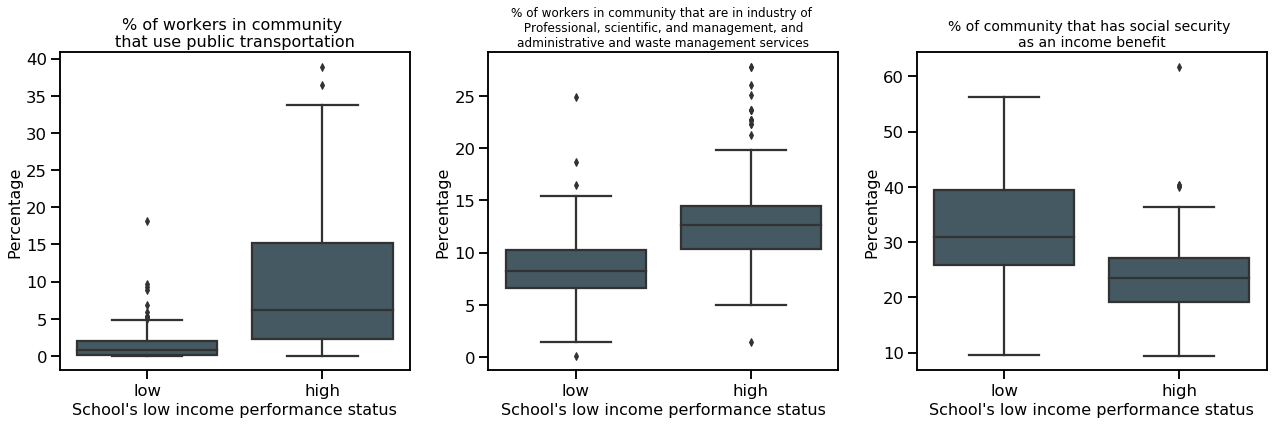

<IPython.core.display.Javascript object>

In [833]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [0,1,2]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in community \nthat use public transportation", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in community that are in industry of \n Professional, scientific, and management, and \nadministrative and waste management services", fontsize=12)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of community that has social security \nas an income benefit", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)


plt.tight_layout();



%; WORKER_CLASS - Civilian employed pop. 16 yrs and up - Private wage and salary workers
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force


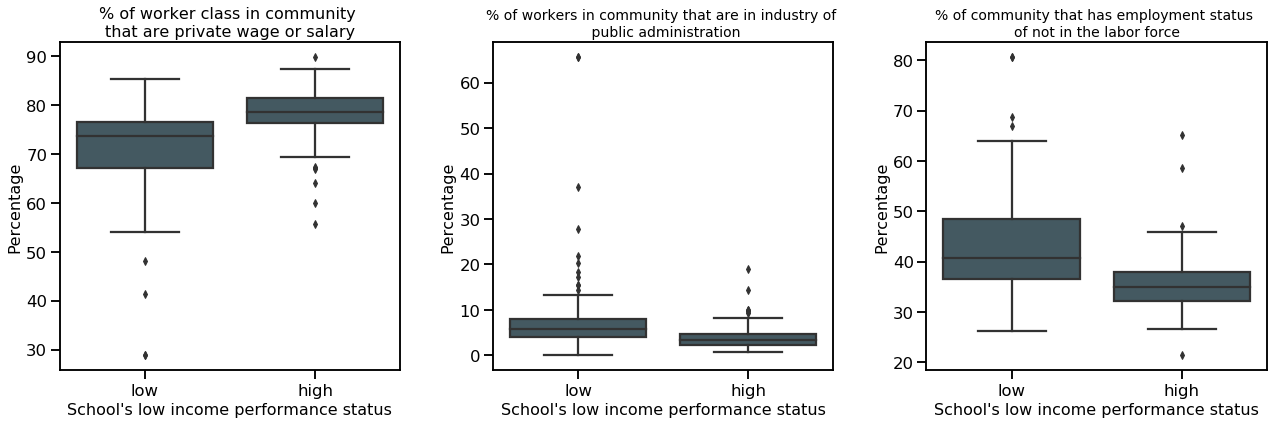

<IPython.core.display.Javascript object>

In [838]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [3, 6, 7]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of worker class in community \nthat are private wage or salary", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n public administration",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of community that has employment status \nof not in the labor force", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


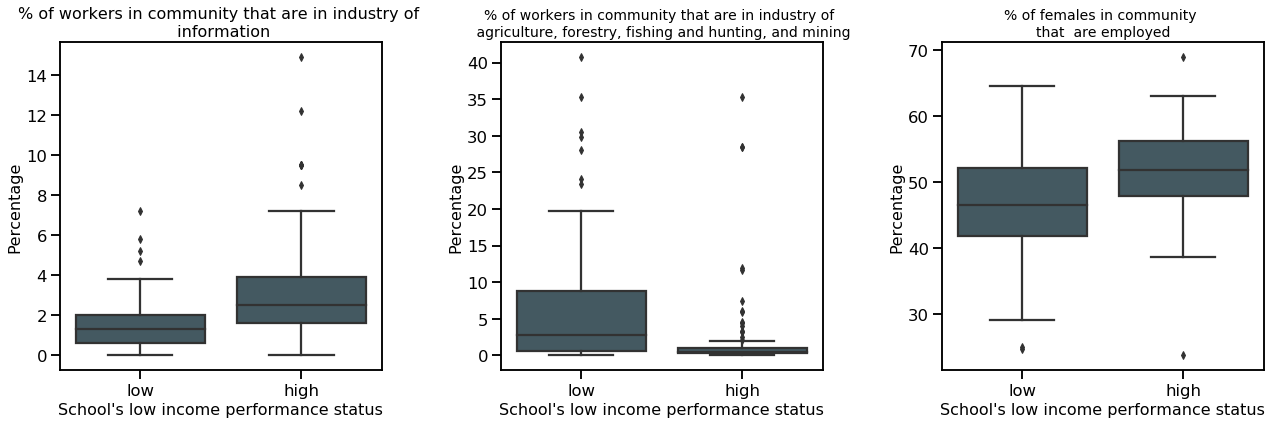

<IPython.core.display.Javascript object>

In [840]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [8, 9, 12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title(
    "% of workers in community that are in industry of \n information", fontsize=16
)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of workers in community that are in industry of \n agriculture, forestry, fishing and hunting, and mining",
    fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of females in community \nthat  are employed", fontsize=14)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


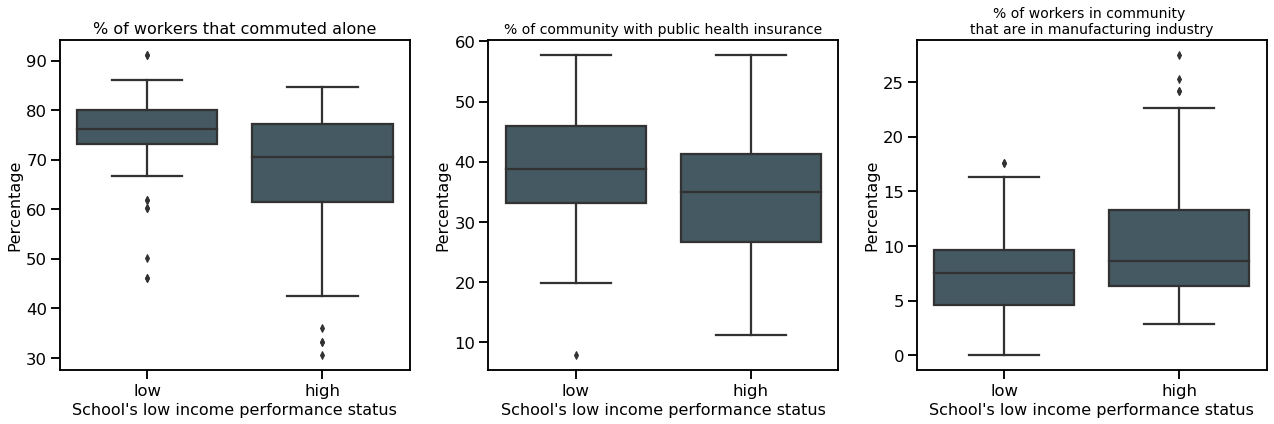

<IPython.core.display.Javascript object>

In [842]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [13, 14, 15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commuted alone", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title(
    "% of community with public health insurance", fontsize=14,
)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title(
    "% of workers in community \nthat are in manufacturing industry", fontsize=14
)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout()

### Second pass of boxplots - by category

%; INDUSTRY - Civilian employed pop. 16 yrs and up - Professional, scientific, and management, and administrative and waste management services
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Information
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Manufacturing


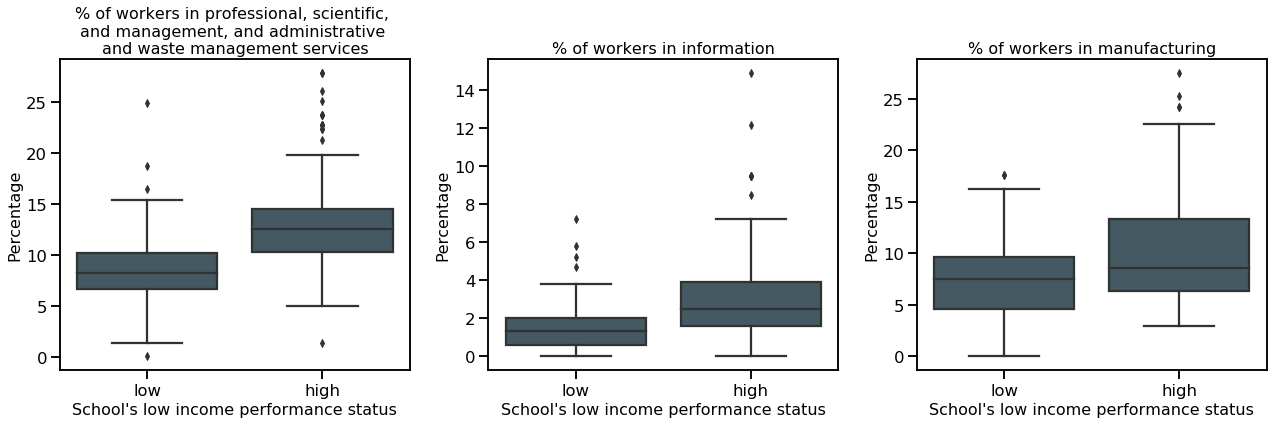

<IPython.core.display.Javascript object>

In [851]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

feature_rank_to_plot = [1,8,15]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in professional, scientific, \nand management, and administrative \nand waste management services", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in information", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

# Third feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[2], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[2], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax3,
)

ax3.set_title("% of workers in manufacturing", fontsize=16)
ax3.set_xlabel("School's low income performance status", fontsize=16)
ax3.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INDUSTRY - Civilian employed pop. 16 yrs and up - Public administration
%; INDUSTRY - Civilian employed pop. 16 yrs and up - Agriculture, forestry, fishing and hunting, and mining


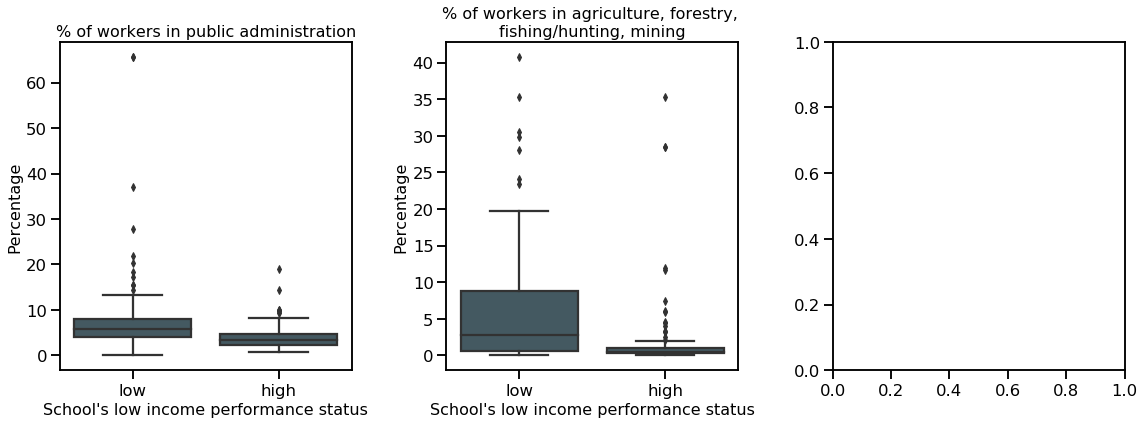

<IPython.core.display.Javascript object>

In [858]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [6,9]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers in public administration", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers in agriculture, forestry, \nfishing/hunting, mining", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



%; EMPLOY_STATUS - Pop. 16 yrs and up - Not in labor force
%; EMPLOY_STATUS - Females 16 yrs and up - In labor force - Civilian labor force - Employed


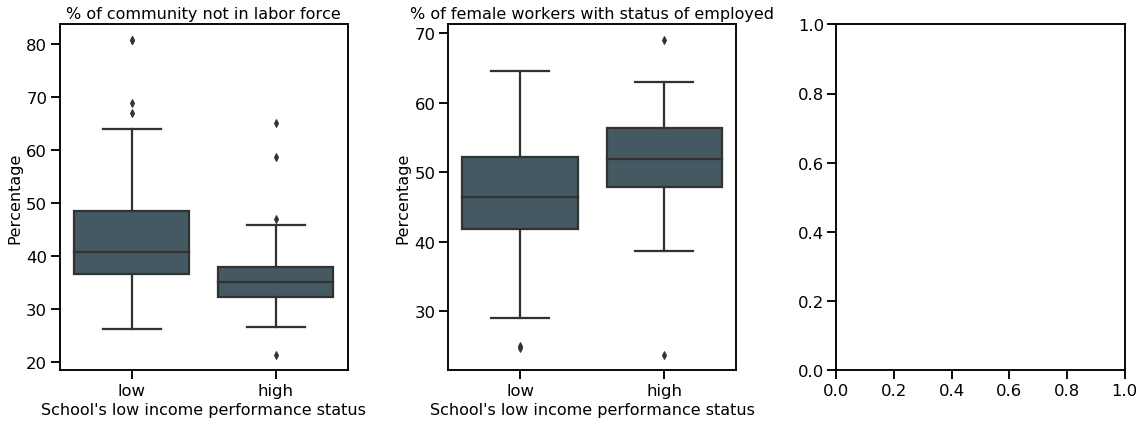

<IPython.core.display.Javascript object>

In [856]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [7,12]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community not in labor force", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of female workers with status of employed", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; WORK_COMMUTE - Workers 16 yrs and up - Public transportation (excluding taxicab)
%; WORK_COMMUTE - Workers 16 yrs and up - Car, truck, or van -- drove alone


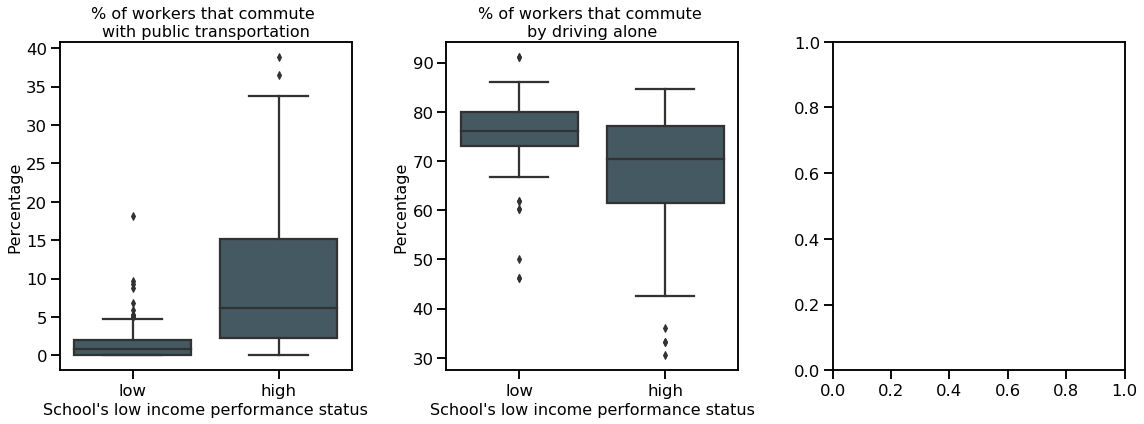

<IPython.core.display.Javascript object>

In [855]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [0,13]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of workers that commute \nwith public transportation", fontsize=16)
ax1.set_xlabel("School's low incomae performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of workers that commute \nby driving alone", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();


%; INCOME_BENEFITS - w/ Social Security
%; HEALTH_INS_COVERAGE - Civilian noninstitutionalized pop. - w/ health ins coverage - w/ public coverage


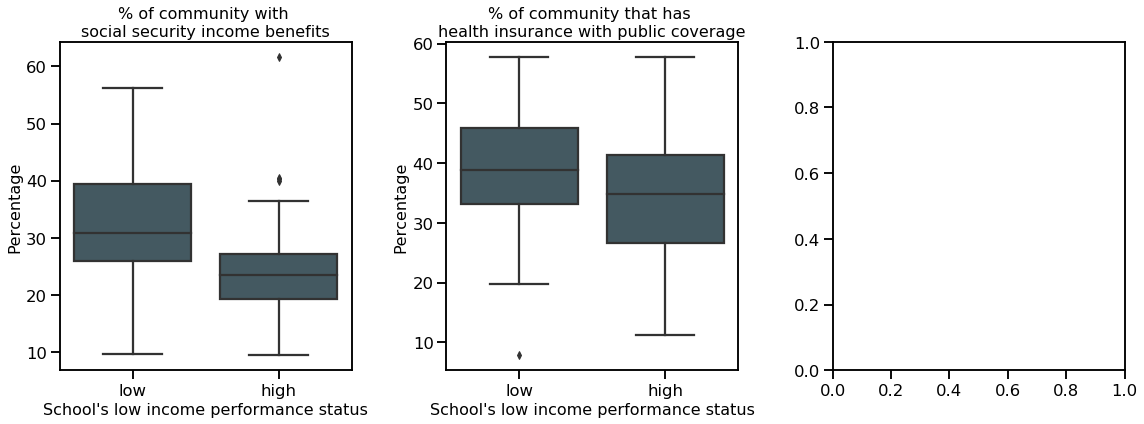

<IPython.core.display.Javascript object>

In [861]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

feature_rank_to_plot = [2,14]

# First feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[0], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[0], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax1,
)

ax1.set_title("% of community with \nsocial security income benefits", fontsize=16)
ax1.set_xlabel("School's low income performance status", fontsize=16)
ax1.set_ylabel("Percentage", fontsize=16)

# Second feature/boxplot
print(df_sig_features.loc[feature_rank_to_plot[1], "feature"])
sns.boxplot(
    data=df_state_info_gs_census_forMW,
    x="LI_performance_status",
    y=df_sig_features.loc[feature_rank_to_plot[1], "feature"],
    color=B_slate,
    order=["low", "high"],
    ax=ax2,
)

ax2.set_title("% of community that has \nhealth insurance with public coverage", fontsize=16)
ax2.set_xlabel("School's low income performance status", fontsize=16)
ax2.set_ylabel("Percentage", fontsize=16)

plt.tight_layout();



## Conclusion and summary

This project identified features that are associated with low income student success. Some features have varying degrees of "actionability": some can be affected directly by policy changes, while others could be indirectly related.

For example, it is clear that schools where all students perform well (by college eligibility rates) is a significantly good predictor in how well their low income students are also doing. Superficially, it is not completely surprising, but it highlights how the right environment benefits all demographics of students.

Other features are not as influential but indicate that some public programs reap benefits. Communities where low income students do well receive some welfare benefits (in the form of supplemental and social security income) and have workers that use public transportation. Therefore policies that adversely affect the recipients of these programs might indirectly be detrimental to the school performance of their children or grandchildren.

It is also notable what features did *not* show benefits for low income student performance. While teacher salary was positively correlated with student performance, student-to-teacher ratio or whether teachers had 3 or more years of experience were not features that predicted whether a school was exceptionally performing. The magnet or charter status of a school were also not predictive features despite their perception. Of course, adding data from other states or evaluating schools longitudinally would help inform how robust these conclusions are.

New data would also be informative. For example, recently (October 2019) the state of [California will start mandating later high school start times](https://www.washingtonpost.com/opinions/students-need-more-sleep-good-for-california-for-giving-them-a-later-school-start/2019/10/18/f5dfc0d2-f047-11e9-8693-f487e46784aa_story.html). While the sleep benefits to students are clear, it is debatable whether this could disproportionately affect low income communities.

Other interesting data would be seeing whether and how much tech usage could be impactful. Do the schools encourage teachers and students to reference Khan Academy as lesson supplements? Or do they use Remind to facilitate communication?